In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

Welcome to JupyROOT 6.24/06


In [27]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

In [97]:
# energy_list = [1, 2, 5, 10, 50, 100, 1000]
energy_list = [0.5, 1, 3, 10]


results={}
for muon_energy in energy_list:
    print("Processing energy ",muon_energy, "GeV")
    
    data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
    files=glob.glob(f"{data_dir}/pion_{muon_energy}_GeV_manual/*/*/stat0.root",)
    files=util.Utils.sortByExt(files)
    
    tfile = root.TFile.Open(files[0])
    Tree = tfile.Get("integral_tree")
    nevents = int(Tree.GetEntries())    

    truth=[]
    recon=[]
    recon_unc=[]
    ievent=[]
    ifile=[]
    ndigi=[]
    chi2=[]
    n_events=np.zeros(nevents)
    n_failed=np.zeros(nevents)

    for i,filename in enumerate(tqdm(files)):
        tfile = root.TFile.Open(filename)
        tree_name = ["integral_tree","box_run"][0]
        Tree = tfile.Get(tree_name)

        for Entry in range(nevents):
            Tree.GetEntry(Entry)
            
            
            # Find the track with exactly 7 hits
            digi_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
            digi_hit_len = np.array([len(i) for i in digi_hit_inds])
    
            
            try:
#             if 1:
                n_events[Entry]+=1
                # Events with no reconstruction will fail here
                track_ind = int(np.argmax(digi_hit_len==7))
                
                ndigi.append(len(Tree.Digi_x))
                recon.append([Tree.Track_k_m_z0[track_ind], Tree.Track_k_m_x0[track_ind], Tree.Track_k_m_y0[track_ind], Tree.Track_k_m_t0[track_ind],Tree.Track_k_m_velZ[track_ind], Tree.Track_k_m_velX[track_ind], Tree.Track_k_m_velY[track_ind]])
                recon_unc.append([Tree.Track_k_m_ErrorZ0[track_ind], Tree.Track_k_m_ErrorX0[track_ind], Tree.Track_k_m_ErrorY0[track_ind], Tree.Track_k_m_ErrorT0[track_ind],Tree.Track_k_m_ErrorVz[track_ind], Tree.Track_k_m_ErrorVx[track_ind], Tree.Track_k_m_ErrorVy[track_ind]])
                
                # Get truth (speed need to be calculated by hand)
                dt=Tree.Hit_time[1]-Tree.Hit_time[0]
                vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
                vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
                vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
                truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],vz,vx,vy])
                ievent.append(Entry)
                ifile.append(i)
                chi2.append(Tree.Track_k_m_smooth_chi_sum[track_ind])
            except:
                n_failed[Entry]+=1
                
    results[muon_energy]={
        "truth":np.array(truth),
        "recon":np.array(recon),
        "recon_unc":np.array(recon_unc),
        "ievent":np.array(ievent),
        "ifile":np.array(ifile),
        "ndigi":np.array(ndigi),
        "chi2":np.array(chi2),
        "n_events":n_events,
        "n_failed":n_failed
    }

Processing energy  0.5 GeV


100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


Processing energy  1 GeV


100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


Processing energy  3 GeV


100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


Processing energy  10 GeV


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


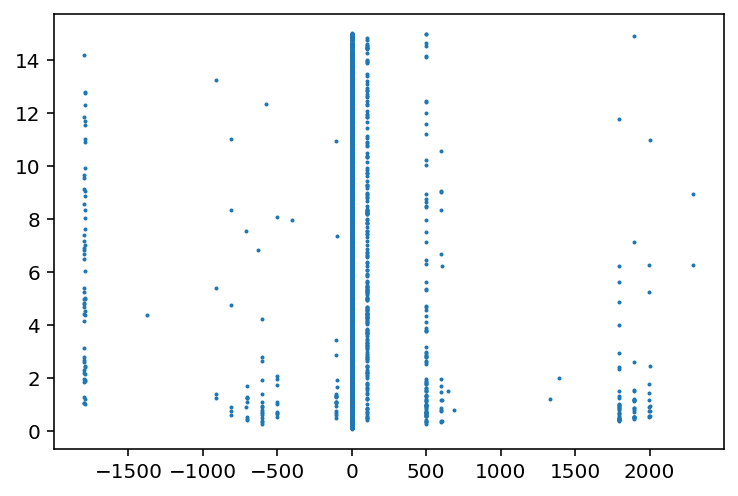

In [113]:
# plt.hist(results[0.5]["chi2"],bins=100,log=1);
# plt.scatter(results[0.5]["recon"][:,2]-results[0.5]["truth"][:,2],results[0.5]["chi2"],s=1,alpha=1);

In [98]:
# barnches = ev.Tree.GetListOfBranches()
# nevents = int(ev.Tree.GetEntries())
# branch_list = [barnches[i].GetName() for i in range(len(barnches))]
# print(branch_list)

In [5]:
# gdiv = TGraphAsymmErrors()
# chi_mask=dict()

# gdiv.Divide(h1, h0, "c1=0.683 b(1,1) mode");
# gdiv.Draw()


Energy 0.5 GeV
  36193.0/39998.0 events with Kalman Filter reconstruction (0.905+/- 0.00656)
Energy 1 GeV
  37642.0/39999.0 events with Kalman Filter reconstruction (0.941+/- 0.00676)
Energy 3 GeV
  39616.0/40000.0 events with Kalman Filter reconstruction (0.99+/- 0.00702)
Energy 10 GeV
  39898.0/40000.0 events with Kalman Filter reconstruction (0.997+/- 0.00706)


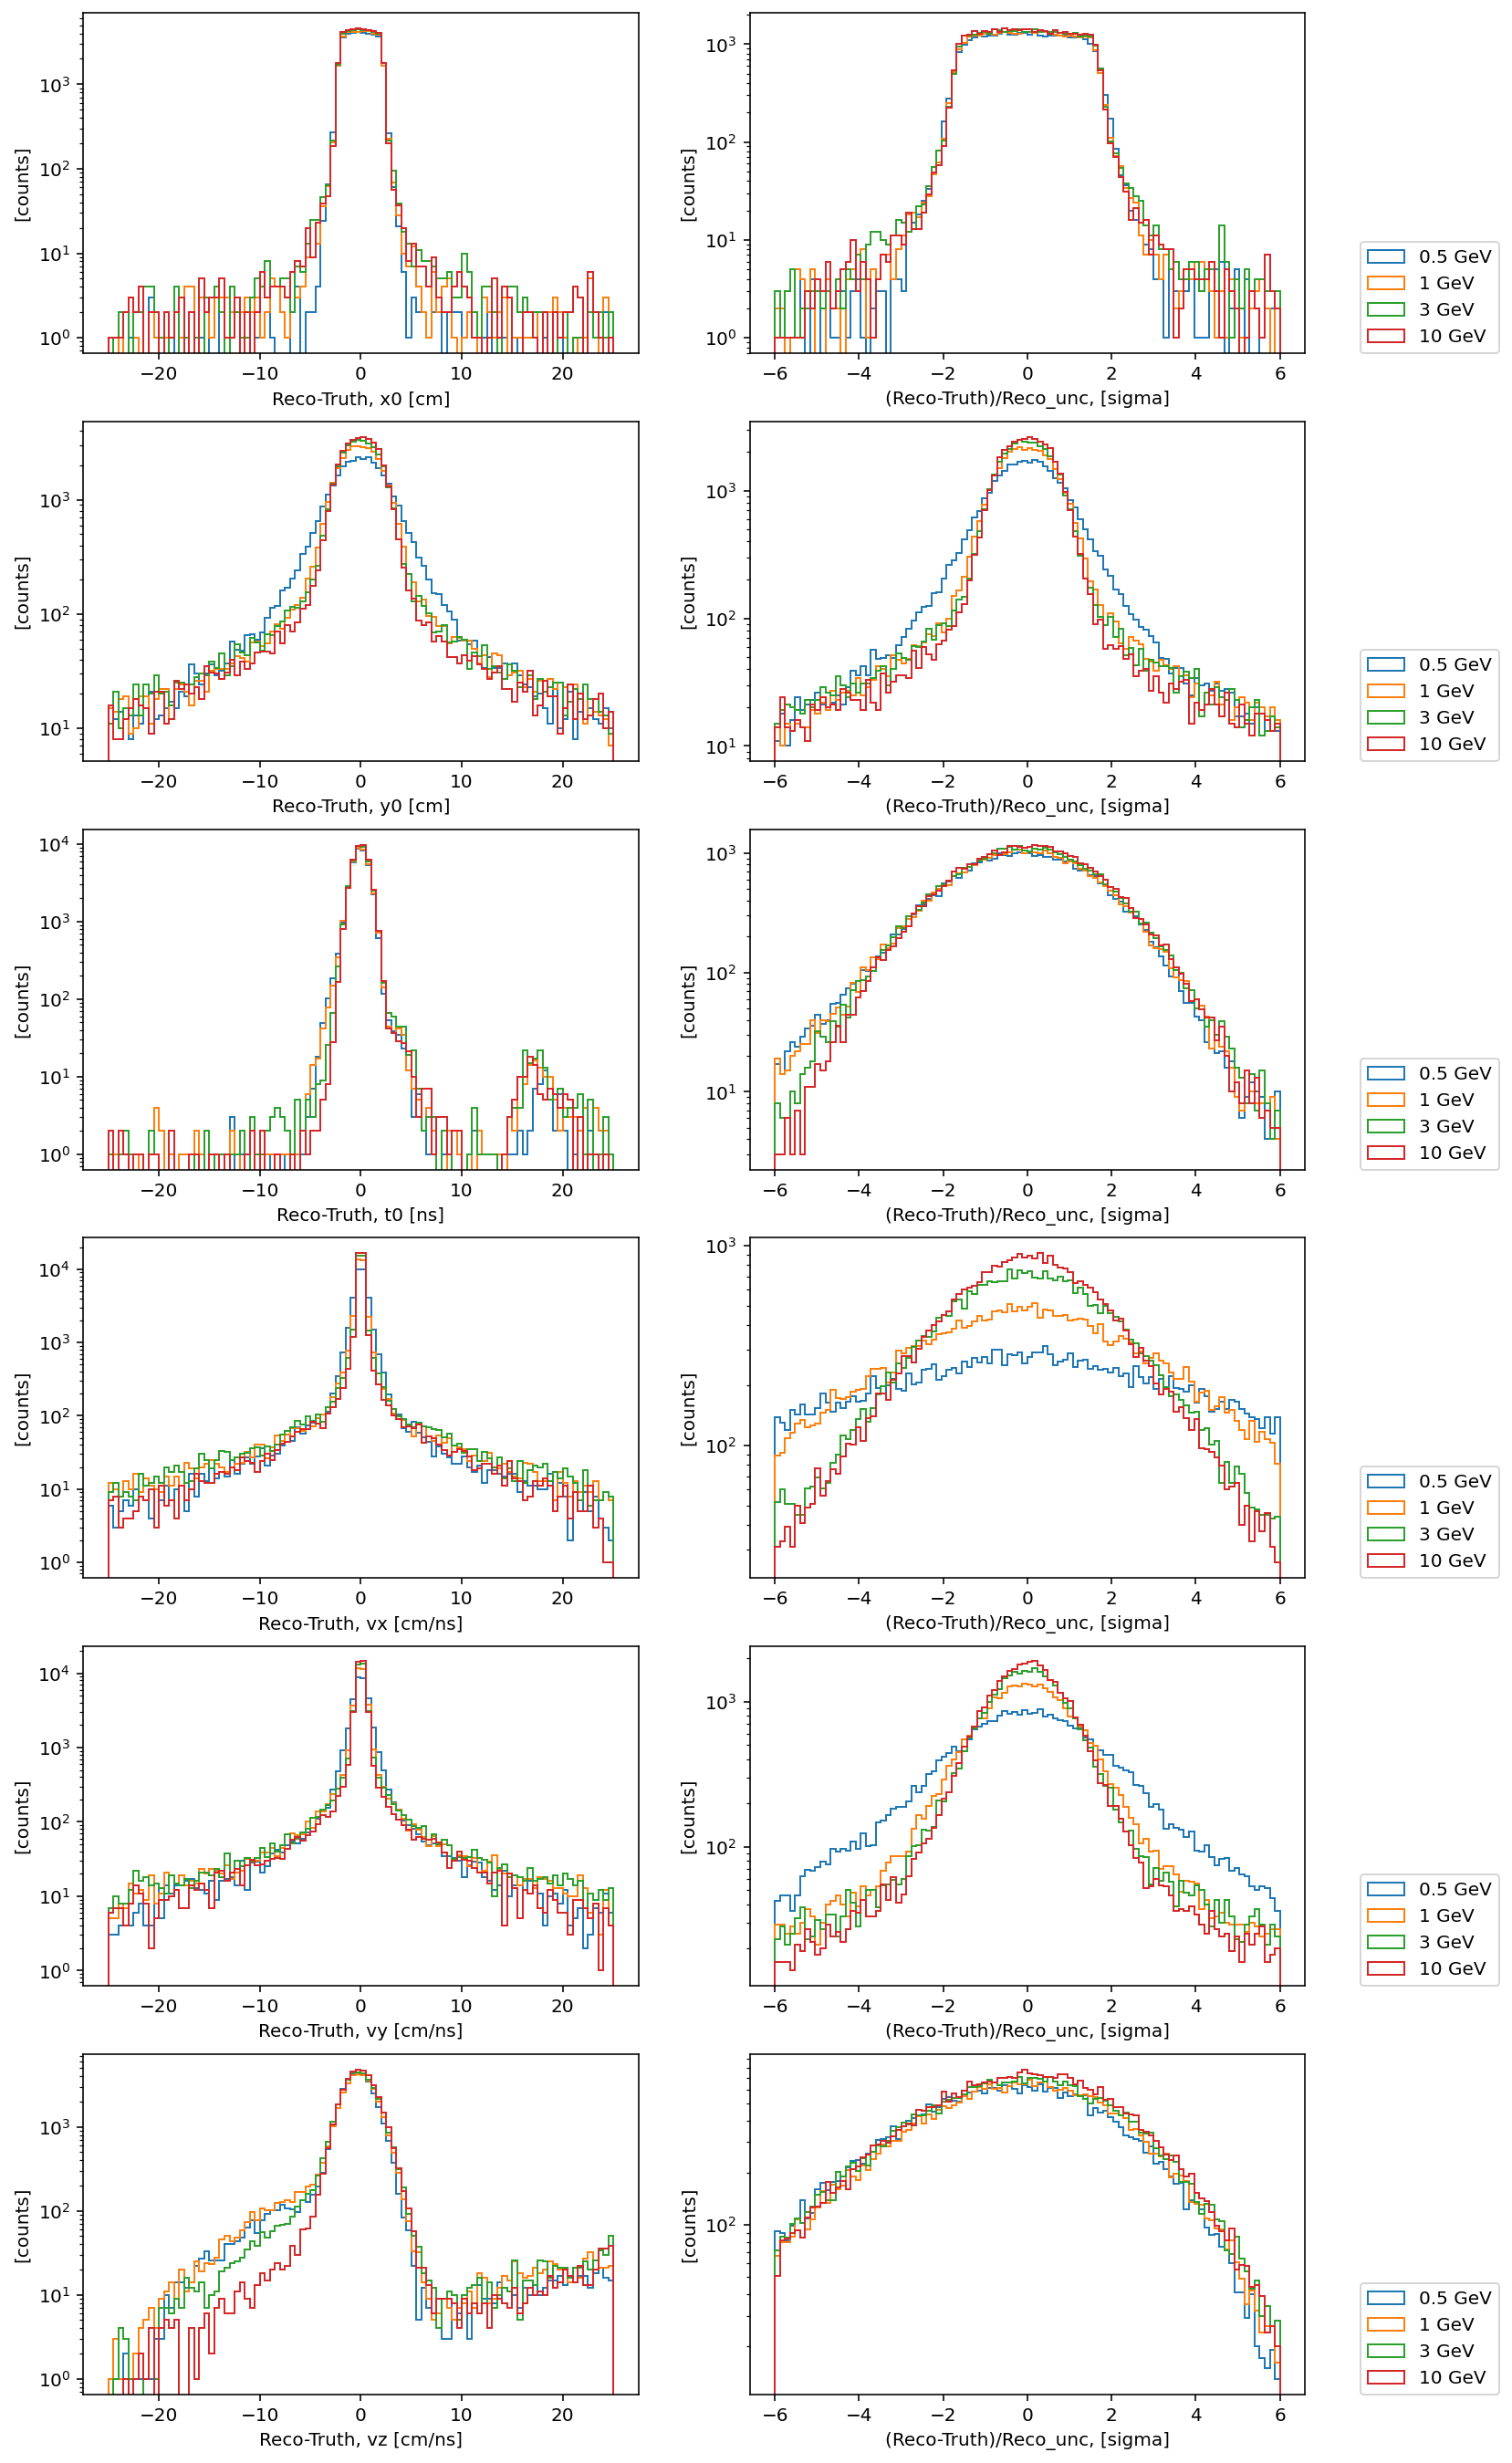

(0.0, 1.0)

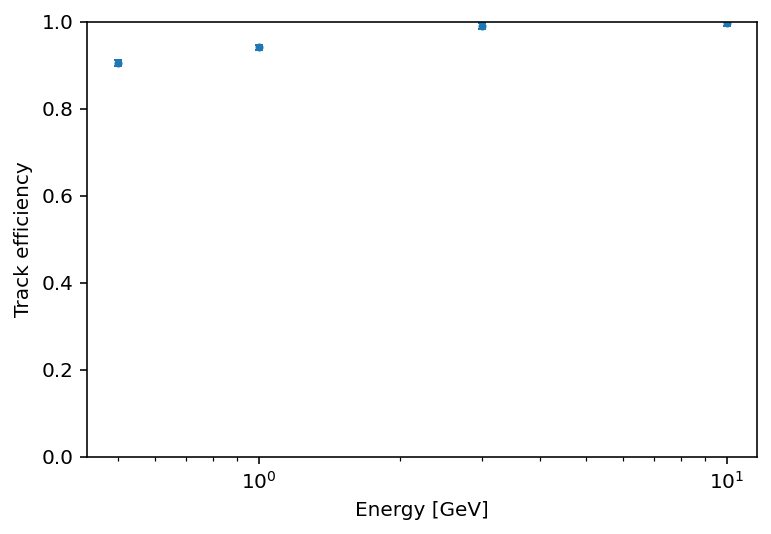

In [8]:
def pull(x_measure, x_truth, x_unc):
    return (x_measure-x_truth)/x_unc

def poissonerror_div(N1,N2):
    return np.sqrt(1/N1+1/N2)*N1/N2


track_efficiency=[]
fig,axs=plt.subplots(6,2,figsize=(12,24))
for muon_energy in energy_list:

    ndigi=np.array(results[muon_energy]["ndigi"])
        
    recon=np.array(results[muon_energy]["recon"])
    recon_unc=np.array(results[muon_energy]["recon_unc"])
    truth=np.array(results[muon_energy]["truth"])
    
    n_events=results[muon_energy]["n_events"]
    n_failed=results[muon_energy]["n_failed"]
    
    axlabels=["x0 [cm]","y0 [cm]", "t0 [ns]", "vx [cm/ns]", "vy [cm/ns]", "vz [cm/ns]"]
    ind=[0,1,3,4,5,6]
    fit_ranges=[[-0.3,0.3],
                [-0.3,0.3],
                [-3,3]]
    fit_bins=[10,10,100]
    
    for i in range(6):
        axs[i][0].hist(recon[:,ind[i]]-truth[:,ind[i]],bins=100,range=(-25,25),histtype="step",label=f"{muon_energy} GeV");
        axs[i][0].set_xlabel(f"Reco-Truth, {axlabels[i]}")
        axs[i][0].set_ylabel("[counts]")
        axs[i][0].set_yscale("log")
        axs[i][0].grid()

        recon_pull = pull(recon[:,ind[i]],truth[:,ind[i]], np.sqrt(recon_unc[:, ind[i]]))
#         if muon_energy==1:
#             x,y, popt,perr = util.Utils.fitu(recon_pull, fit_range=fit_ranges[i], n_bins=fit_bins[i], functions=(root.RooGaussian,),
#                         initial_values=((np.mean(recon_pull),np.std(recon_pull), len(recon_pull)/np.std(recon_pull)),),
#                         bounds=(((-1e6, 1e6), (0, 1e6), (0, 1e6)), ),
#                         set_constant=None,
#                         verbosity=0)   
#             axs[i][1].plot(x,y,color="r",alpha=0.6,label="Gauss fit")        
        axs[i][1].hist(recon_pull,bins=100,range=(-6,6),histtype="step",label=f"{muon_energy} GeV");
        axs[i][1].set_xlabel(f"(Reco-Truth)/Reco_unc, [sigma]")
        axs[i][1].set_ylabel("[counts]")
        axs[i][1].set_yscale("log")
        axs[i][1].grid()
        axs[i][1].legend(loc=(1.1,0))  
                
    fraction = (n_events-n_failed)/n_events
    trackeff=np.mean(fraction)
#     trackunc=np.std(fraction)
    trackunc=poissonerror_div(sum(n_events)-sum(n_failed),sum(n_events))
    track_efficiency.append([muon_energy, trackeff, trackunc])
    print(f"Energy {muon_energy} GeV\n  {sum(n_events)-sum(n_failed)}/{sum(n_events)} events with Kalman Filter reconstruction ({trackeff:.3}+/-{trackunc: .3})")   
    #plt.plot(fraction)
    #plt.show()
plt.show()
    
track_efficiency=np.transpose(track_efficiency)
plt.errorbar(track_efficiency[0],track_efficiency[1],yerr=track_efficiency[2],fmt=".", capsize=2)
plt.xlabel("Energy [GeV]")
plt.ylabel("Track efficiency")
plt.xscale("log")
plt.ylim(0,1)

(0.1, 10000.0)

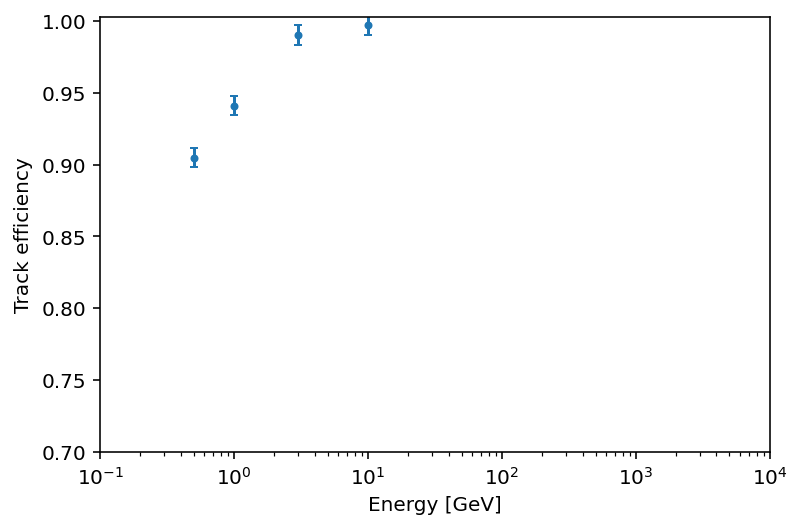

In [12]:
track_efficiency=np.transpose(track_efficiency)
plt.errorbar(track_efficiency[0],track_efficiency[1],yerr=track_efficiency[2],fmt=".", capsize=2)
plt.xlabel("Energy [GeV]")
plt.ylabel("Track efficiency")
plt.xscale("log")
plt.ylim(0.7,1.003)
plt.xlim(0.1,1e4)

In [10]:
track_efficiency[0],track_efficiency[1],track_efficiency[2]

(array([0.5       , 0.90487024, 0.00656458]),
 array([1.        , 0.94107353, 0.00675784]),
 array([3.        , 0.9904    , 0.00702014]))

### Least square fit

In [15]:
import lsfit
reload(lsfit)
from lsfit import *

## Let's fit one file

In [16]:
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/pion_10_GeV_manual/*/*/stat*.root",)
print(files)
file_prefix='/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_10_GeV_manual/20230222/230056/'

['/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_10_GeV_manual/20230222/230056/stat_original.root', '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_10_GeV_manual/20230222/230056/stat_noscatter.root', '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_10_GeV_manual/20230222/230056/stat0.root']


  0%|          | 0/40000 [00:00<?, ?it/s]/project/6035200/tomren/jupyter/tracker_analysis/lsfit.py:102: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


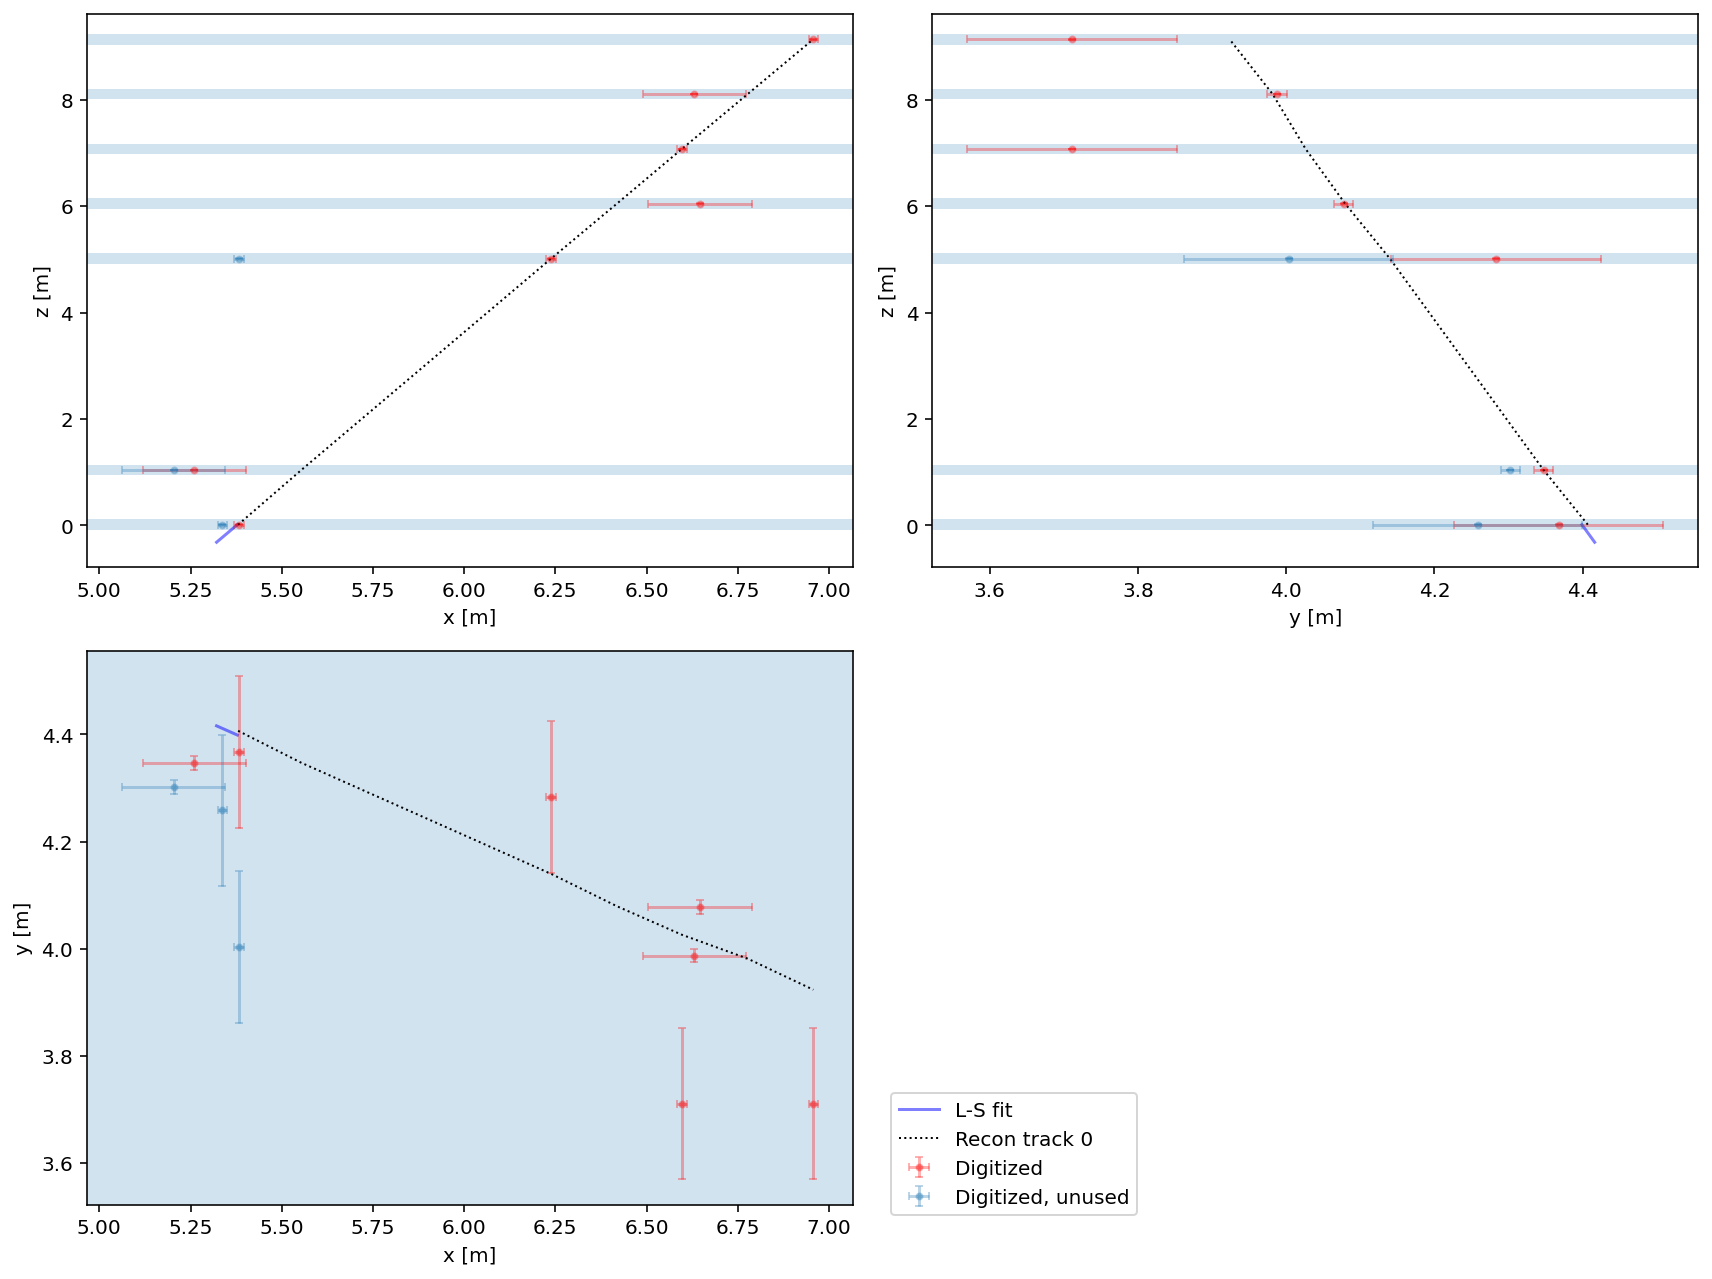

  0%|          | 1/40000 [00:00<8:02:26,  1.38it/s]/project/6035200/tomren/jupyter/tracker_analysis/lsfit.py:102: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser
100%|██████████| 40000/40000 [13:11<00:00, 50.54it/s]


In [17]:
results_fit={}
results_fit["ndigi"]=[]
results_fit["par_truth"]=[]
results_fit["par_fit"]=[]
results_fit["par_fit_error"]=[]
results_fit["par_km"]=[]
results_fit["par_km_error"]=[]

MAKE_PLOTS=True
PLOT_MAX=1
nplots=0

# for i_file in range(len(files)):
# for i_file in range(20):
if 1:
    filename=f"{file_prefix}/stat0.root"
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    # ev.EventNumber=4
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")



    for i_event in tqdm(range(nevents)):
#     for i_event in tqdm(range(2)):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        
        # Find the track with exactly 7 hits
        digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
        if len(digi_hit_inds)==0:
            continue
        digi_hit_len = np.array([len(i) for i in digi_hit_inds])
        track_ind = int(np.argmax(digi_hit_len==7))
        track_hits_inds=digi_hit_inds[track_ind]   
        hits=np.array(hits)[track_hits_inds]
        
#         if len(ev.Tree.Digi_x)==7:
        if len(hits)==7:            
            try:
                par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
                par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
                xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
                xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])
            except:
                continue
                
            
            # Do LS fit
            guess=guess_track(hits)
            fit1=fit_track(hits,guess)
            par_fit=list(fit1.values)
            par_fit_error=list(fit1.errors)
            xyz0_fit = util.coord_cms2det(np.array(par_fit[:3]))
            xyzV_fit = np.array([par_fit[2+4],par_fit[0+4],par_fit[1+4]])
            time_seq=np.linspace(0,ev.Tree.Digi_time[-1]-ev.Tree.Hit_time[0],100)
            
            # Get Truth value
            Tree=ev.Tree
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
            xyz0_truth = util.coord_cms2det(np.array([Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0]]))

            # Save results
            results_fit["ndigi"].append(len(Tree.Digi_x))
            results_fit["par_truth"].append(par_truth)
            results_fit["par_fit"].append(par_fit)
            results_fit["par_fit_error"].append(par_fit_error)
            results_fit["par_km"].append(par_km)
            results_fit["par_km_error"].append(par_km_error)
            
            # Make plots
            if MAKE_PLOTS and nplots<PLOT_MAX:
                nplots+=1
                
                # Plot truth+recon
                fig,axs=plt.subplots(2,2,figsize=(12,9))
                # fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
                axs=axs.flatten()
                axs[0].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                                 xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                                 color="b",alpha=0.5,label="L-S fit")  
                axs[1].plot(xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                                 xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                                 color="b",alpha=0.5,label="L-S fit")    
                axs[2].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                                 xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                                 color="b",alpha=0.5,label="L-S fit")                  
                fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=False);
                plt.show()
                
                
for key in results_fit:
    results_fit[key]=np.array(results_fit[key])                

In [18]:
for i,filename in enumerate([f"{file_prefix}/stat_noscatter.root",f"{file_prefix}/stat_original.root"]):
    results_fit[f"ndigi_{i}"] =[]
    results_fit[f"par_truth_{i}"] =[]
    results_fit[f"par_km_{i}"]=[]
    results_fit[f"par_km_error_{i}"]=[]
    
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    # ev.EventNumber=4
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")



    for i_event in tqdm(range(nevents)):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        
        # Find the track with exactly 7 hits
        digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
        if len(digi_hit_inds)==0:
            continue
        digi_hit_len = np.array([len(i) for i in digi_hit_inds])
        track_ind = int(np.argmax(digi_hit_len==7))
        track_hits_inds=digi_hit_inds[track_ind]   
        hits=np.array(hits)[track_hits_inds]
        
#         if len(ev.Tree.Digi_x)==7:
        if len(hits)==7:   
            try:
                par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
                par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
            except:
                continue

            #truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])
            Tree=ev.Tree
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]

            results_fit[f"ndigi_{i}"].append(len(Tree.Digi_x))
            results_fit[f"par_truth_{i}"].append(par_truth)
            results_fit[f"par_km_{i}"].append(par_km)
            results_fit[f"par_km_error_{i}"].append(par_km_error)
            
for key in results_fit:
    results_fit[key]=np.array(results_fit[key])   

100%|██████████| 40000/40000 [00:24<00:00, 1617.61it/s]


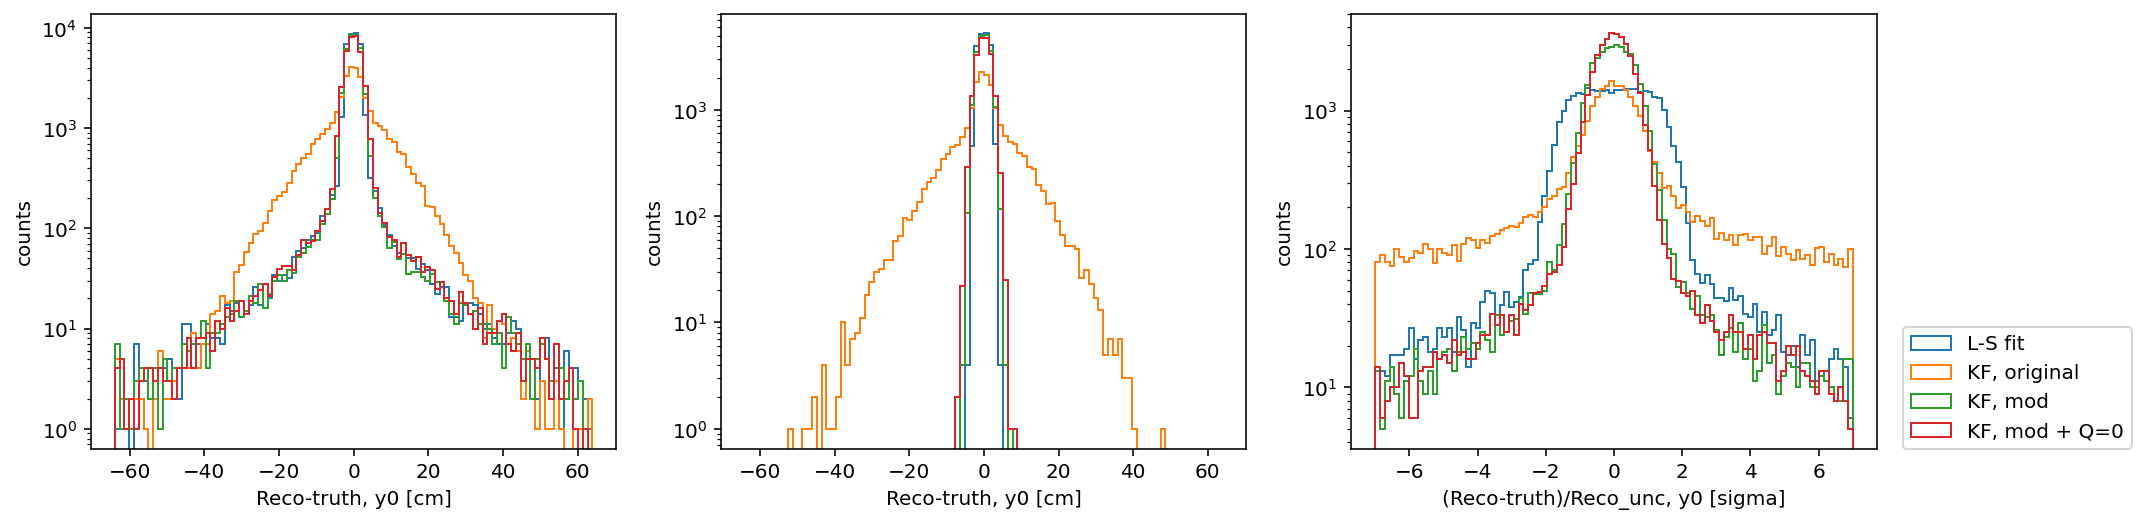

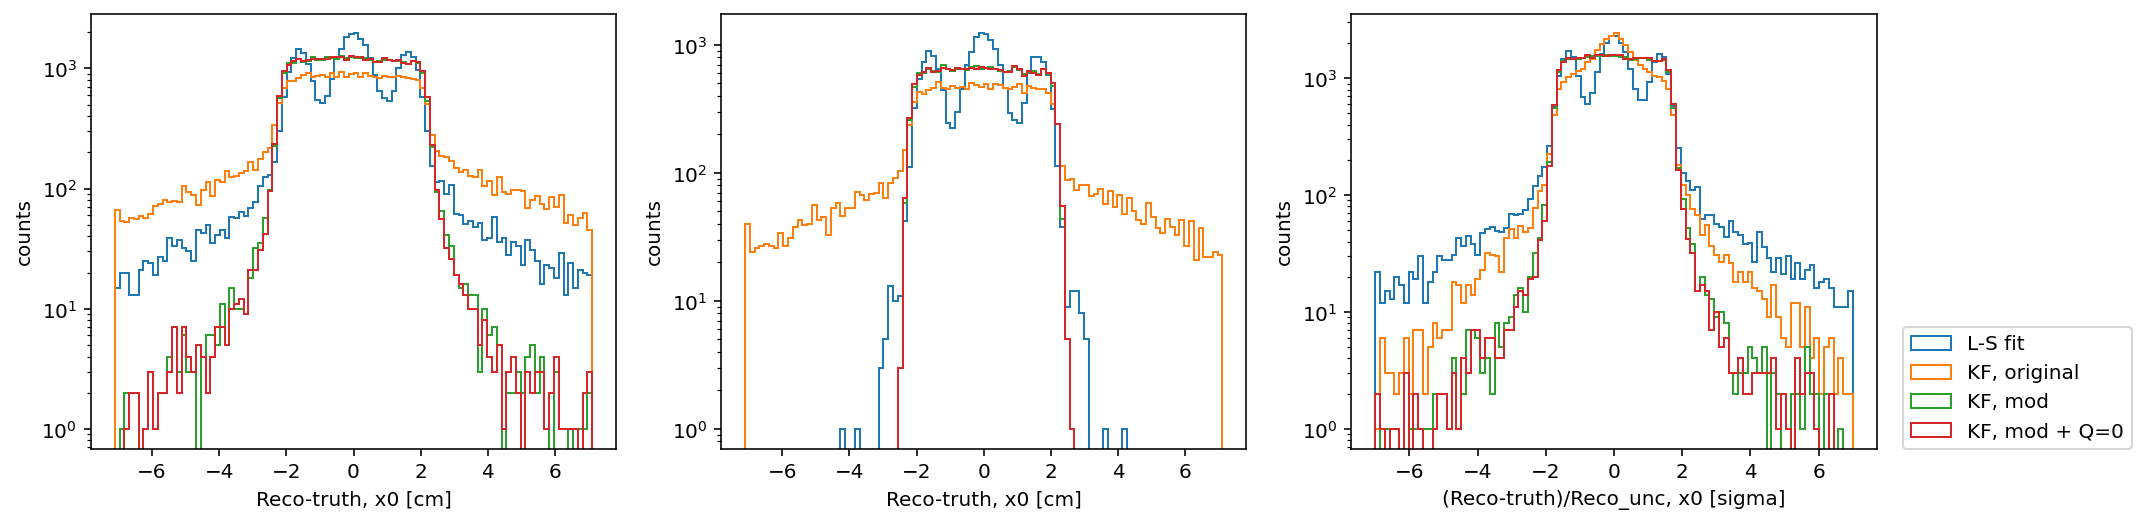

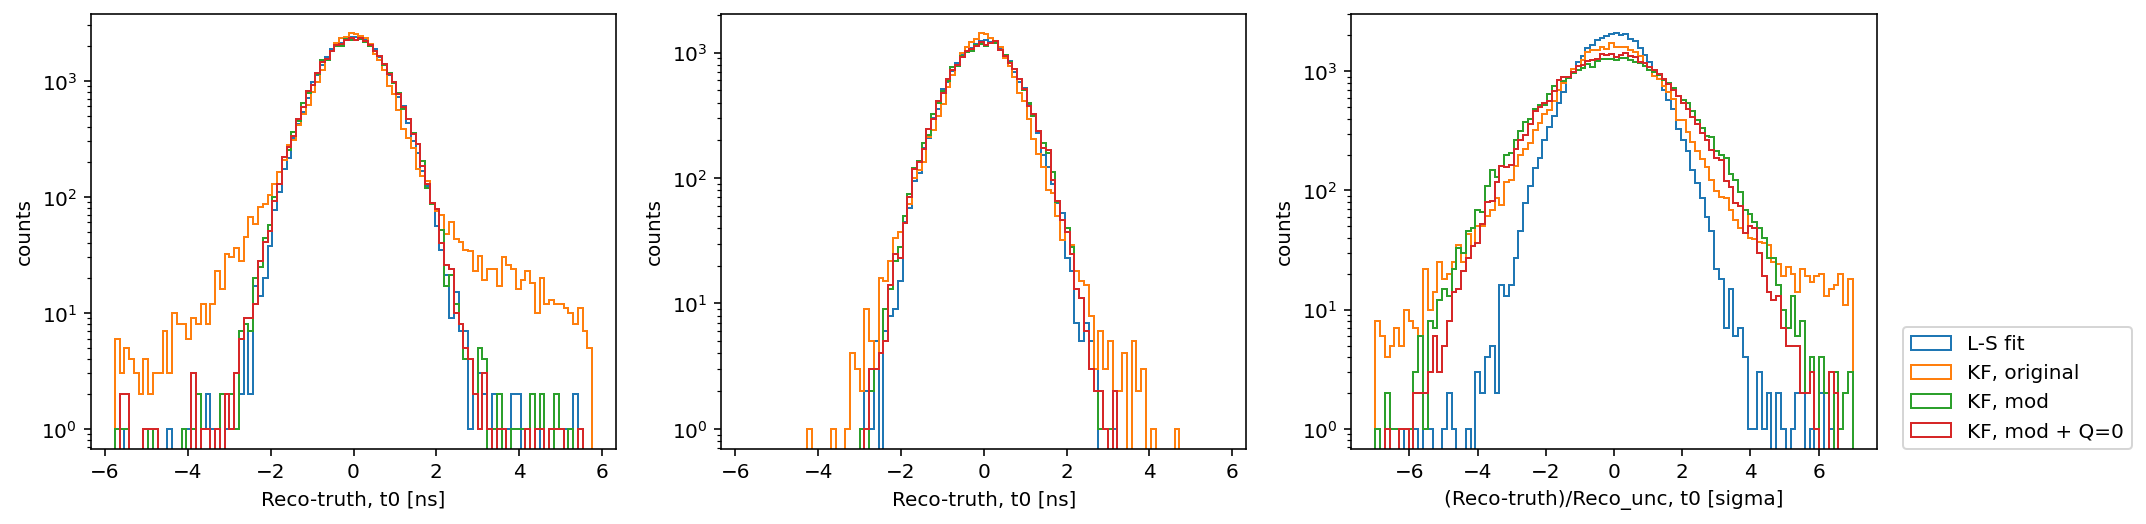

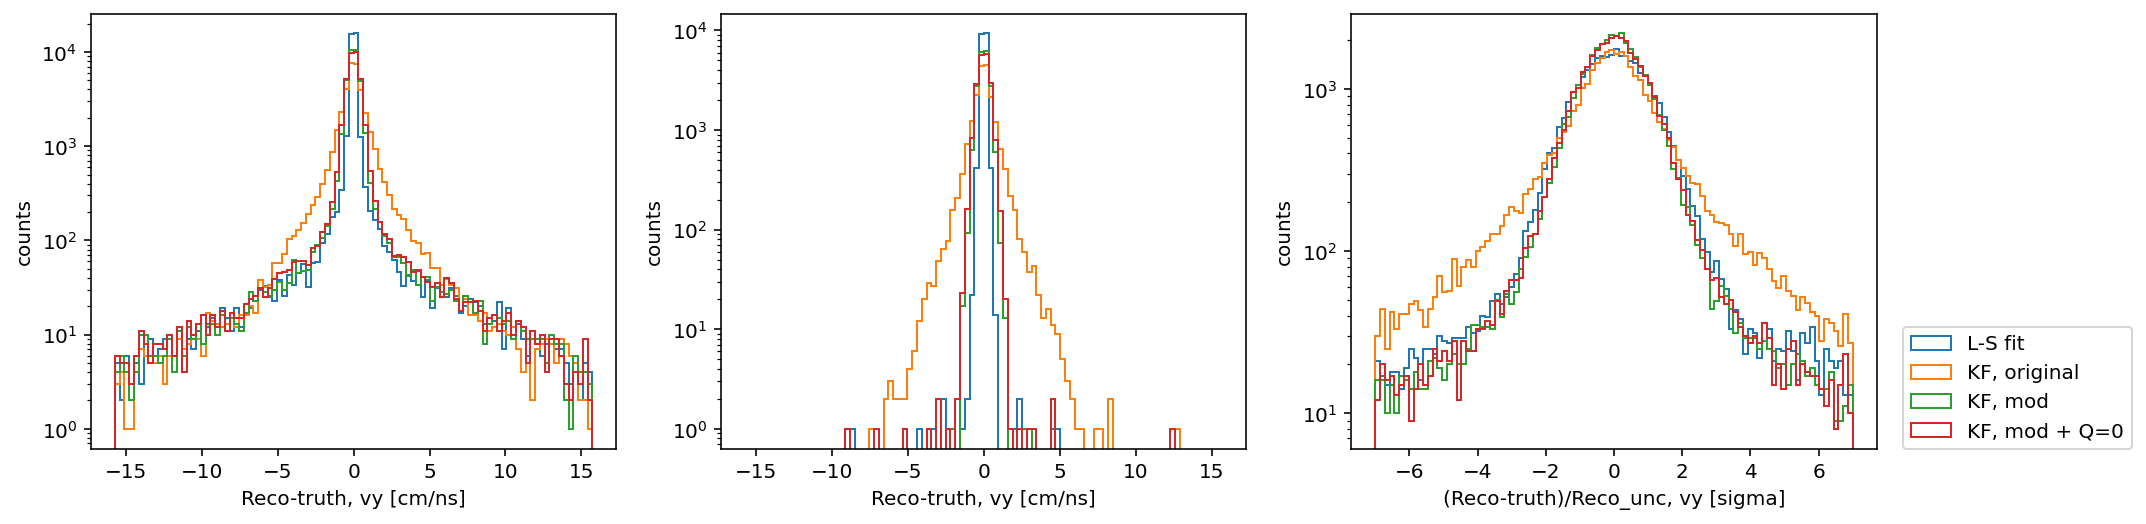

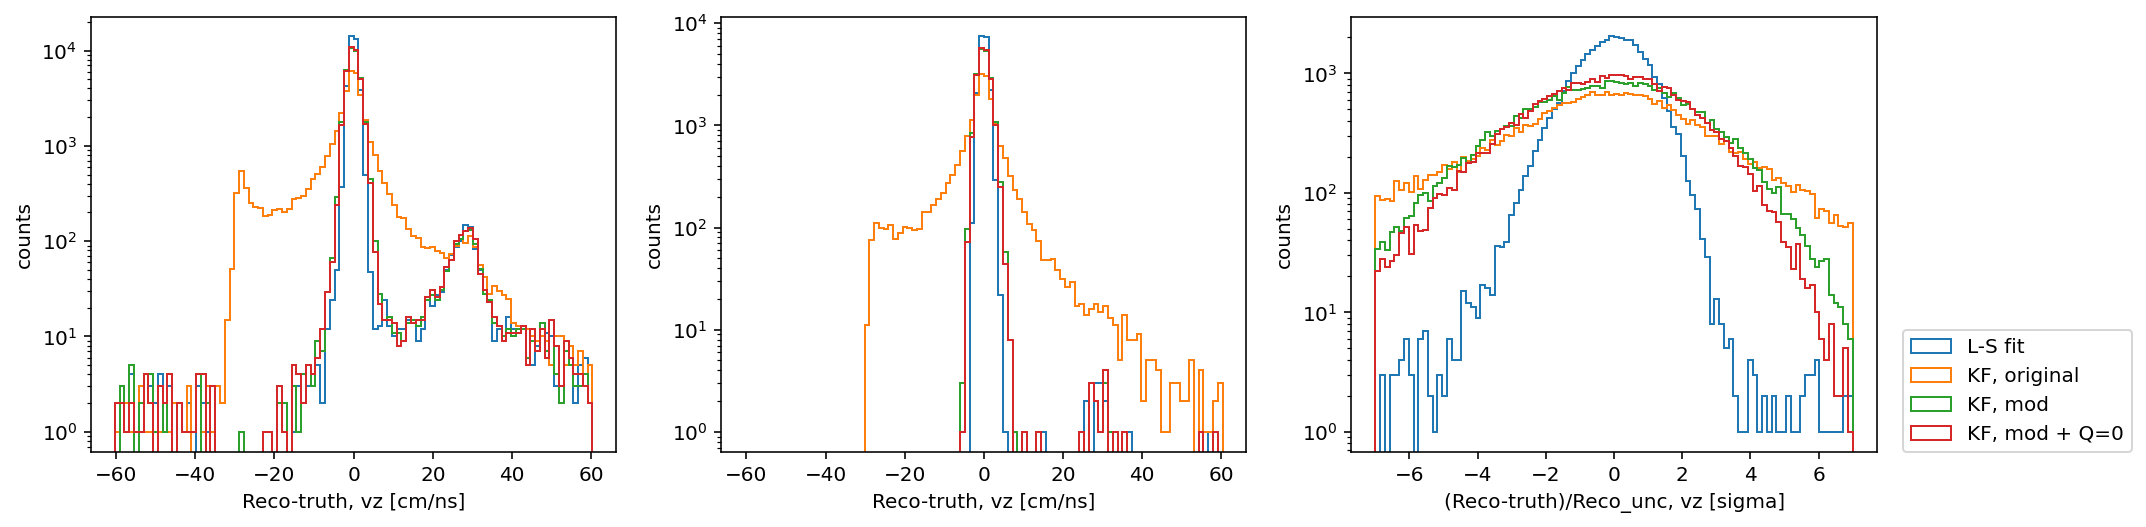

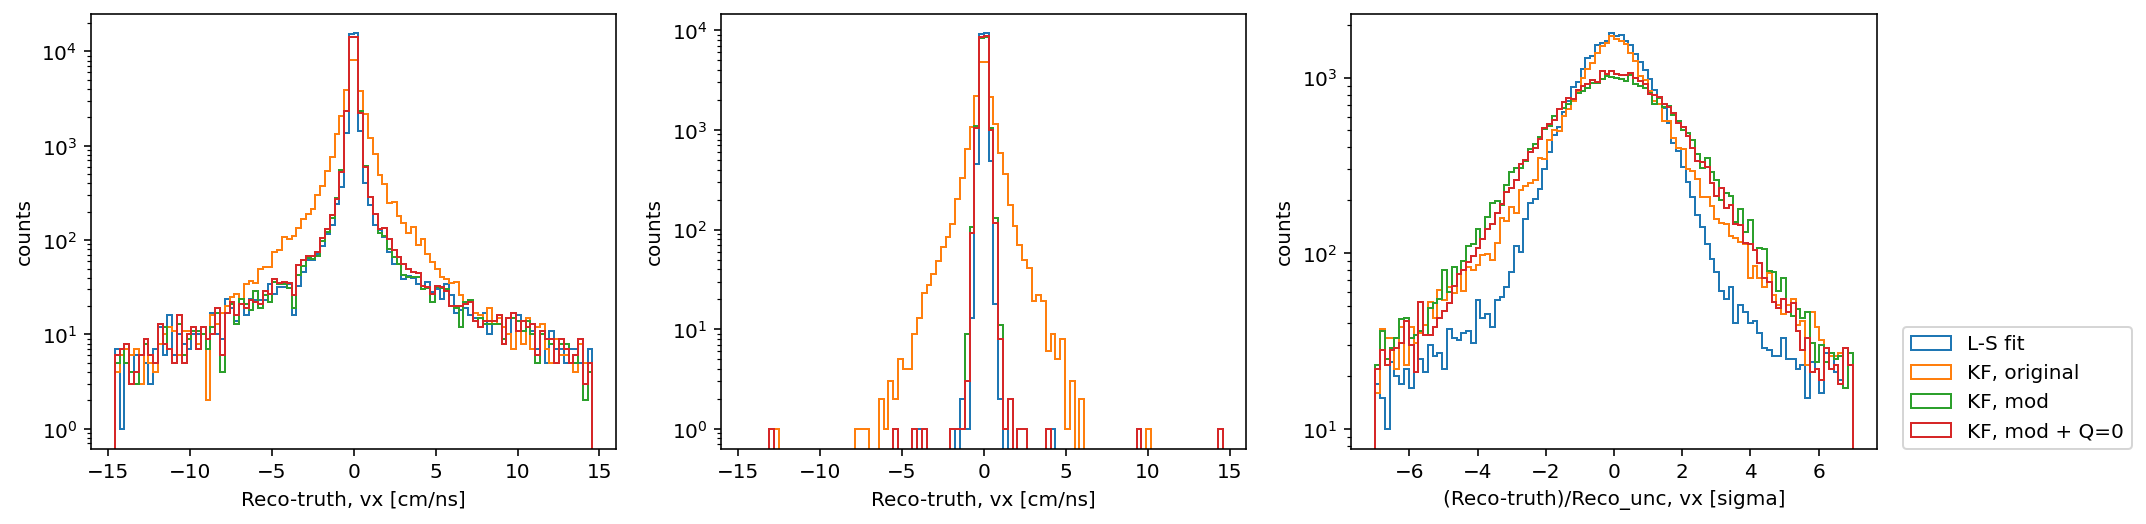

In [35]:
par_names=['y0', 'z0', 'x0', 't0', 'vy', 'vz', 'vx'] # Use real world direction
par_unit= ["[cm]",'[cm]',"[cm]", "[ns]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

def plot_result():
    for ipar in range(7):
        if ipar==1:
            continue
        #_range=ranges[ipar]
        residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
        residual_km=results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar]
        residual_km0=results_fit["par_km_0"][:,ipar]-results_fit["par_truth_0"][:,ipar]
        residual_km1=results_fit["par_km_1"][:,ipar]-results_fit["par_truth_1"][:,ipar]
        _range=(np.percentile(residual_km,1)*2,np.percentile(residual_km,99)*2)
        _range=(-max(np.abs(_range)),max(np.abs(_range)))

        mask = results_fit[f"ndigi"]==7
        mask0 = results_fit[f"ndigi_0"]==7
        mask1 = results_fit[f"ndigi_1"]==7

        def pull(x_measure, x_truth, x_unc):
            return (x_measure-x_truth)/x_unc
        pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
        pull_km=pull(residual_km,0,np.sqrt(results_fit["par_km_error"][:,ipar]))
        pull_km0=pull(residual_km0,0,np.sqrt(results_fit["par_km_error_0"][:,ipar]))
        pull_km1=pull(residual_km1,0,np.sqrt(results_fit["par_km_error_1"][:,ipar]))

        fig,axs=plt.subplots(1,2,figsize=(12,4))
        plt.sca(axs[0])
        plt.hist(residual_ls,histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
        plt.hist(residual_km1,histtype="step",bins=100,range=_range,label="KF, original");#bins=np.linspace(360,500,100));
        plt.hist(residual_km,histtype="step",bins=100,range=_range,label="KF, mod");#bins=np.linspace(360,500,100));
        plt.hist(residual_km0,histtype="step",bins=100,range=_range,label="KF, mod + Q=0");#bins=np.linspace(360,500,100));
        plt.xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
        plt.ylabel("counts")
        plt.yscale("log")
        plt.sca(axs[1])
#         plt.hist(residual_ls[mask],histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
#         plt.hist(residual_km1[mask1],histtype="step",bins=100,range=_range,label="KF, original");#bins=np.linspace(360,500,100));
#         plt.hist(residual_km[mask],histtype="step",bins=100,range=_range,label="KF, mod");#bins=np.linspace(360,500,100));
#         plt.hist(residual_km0[mask0],histtype="step",bins=100,range=_range,label="KF, mod + Q=0");#bins=np.linspace(360,500,100));    
#         plt.xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
#         plt.ylabel("counts")
#         plt.yscale("log")
#         plt.sca(axs[2])
        _range_pull=[-7,7]
        plt.hist(pull_ls,histtype="step",bins=100,range=_range_pull,label="L-S fit");#bins=np.linspace(360,500,100));
        plt.hist(pull_km1,histtype="step",bins=100,range=_range_pull,label="KF, original");#bins=np.linspace(360,500,100));
        plt.hist(pull_km,histtype="step",bins=100,range=_range_pull,label="KF, mod");#bins=np.linspace(360,500,100));
        plt.hist(pull_km0,histtype="step",bins=100,range=_range_pull,label="KF, mod + Q=0");#bins=np.linspace(360,500,100));
        plt.legend(loc=(1.05,0))
        plt.xlabel(f"(Reco-truth)/Reco_unc, {par_names[ipar]} [sigma]")
        plt.ylabel("counts")
        plt.yscale("log")    

        plt.show()
        
plot_result()

In [71]:
filename=f"{file_prefix}/stat0.root"
tree_name="integral_tree"
ev = event.Event(filename, 0, tree_name=tree_name)

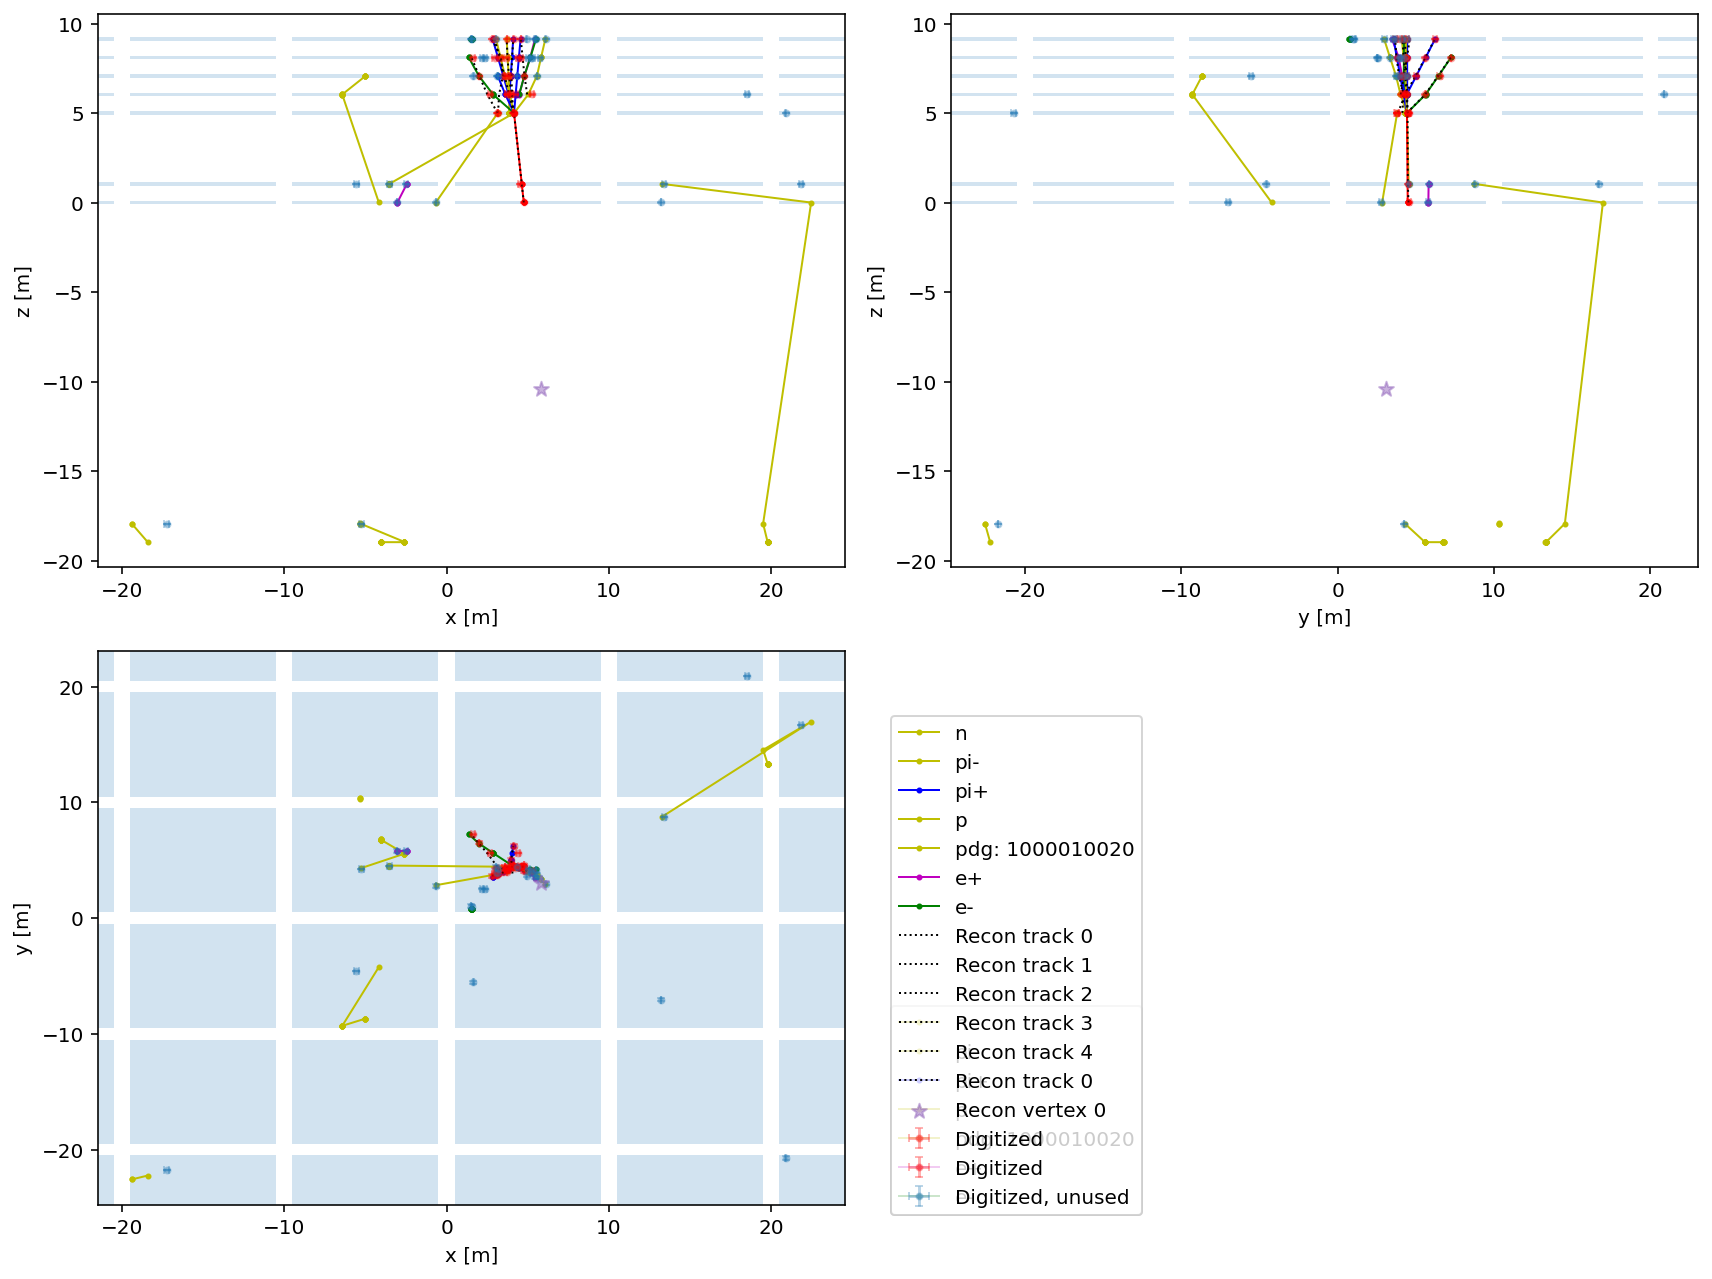

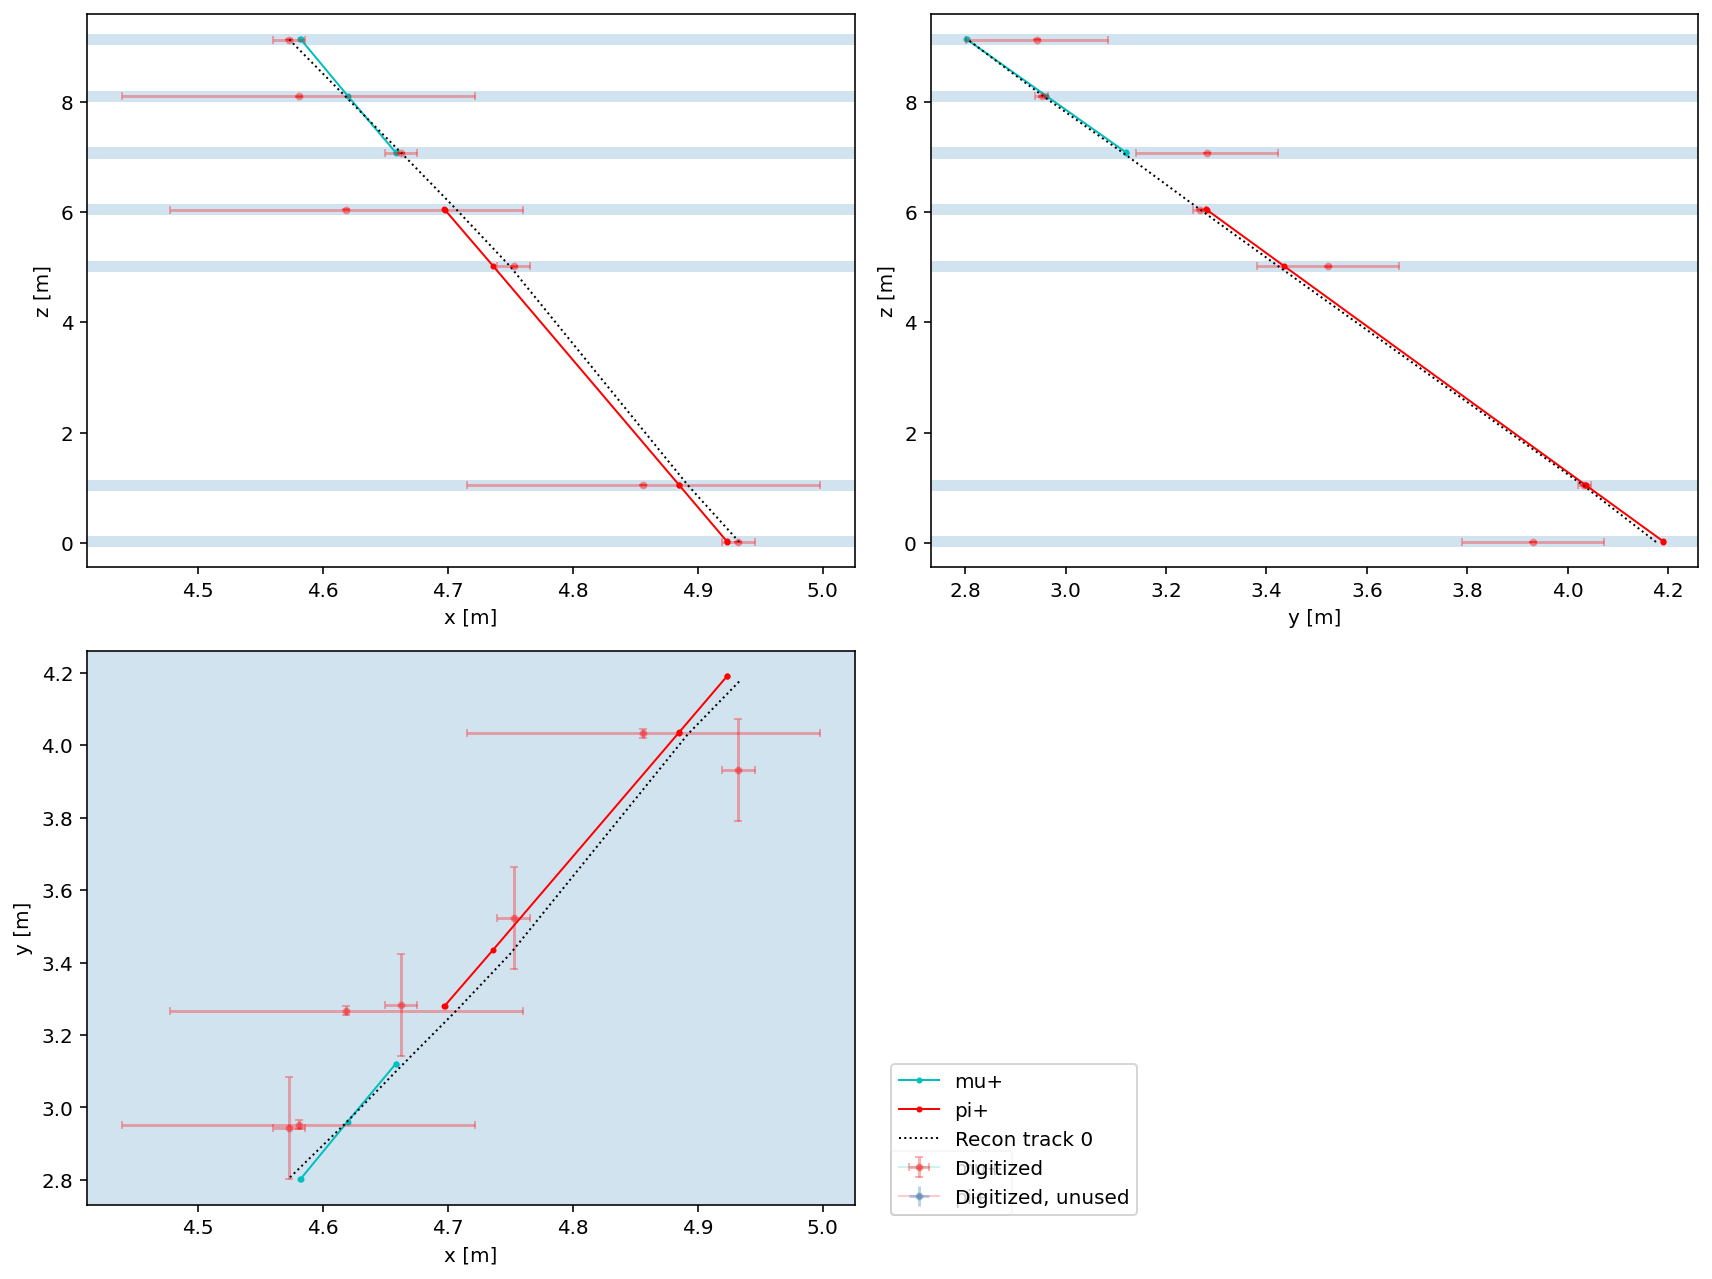

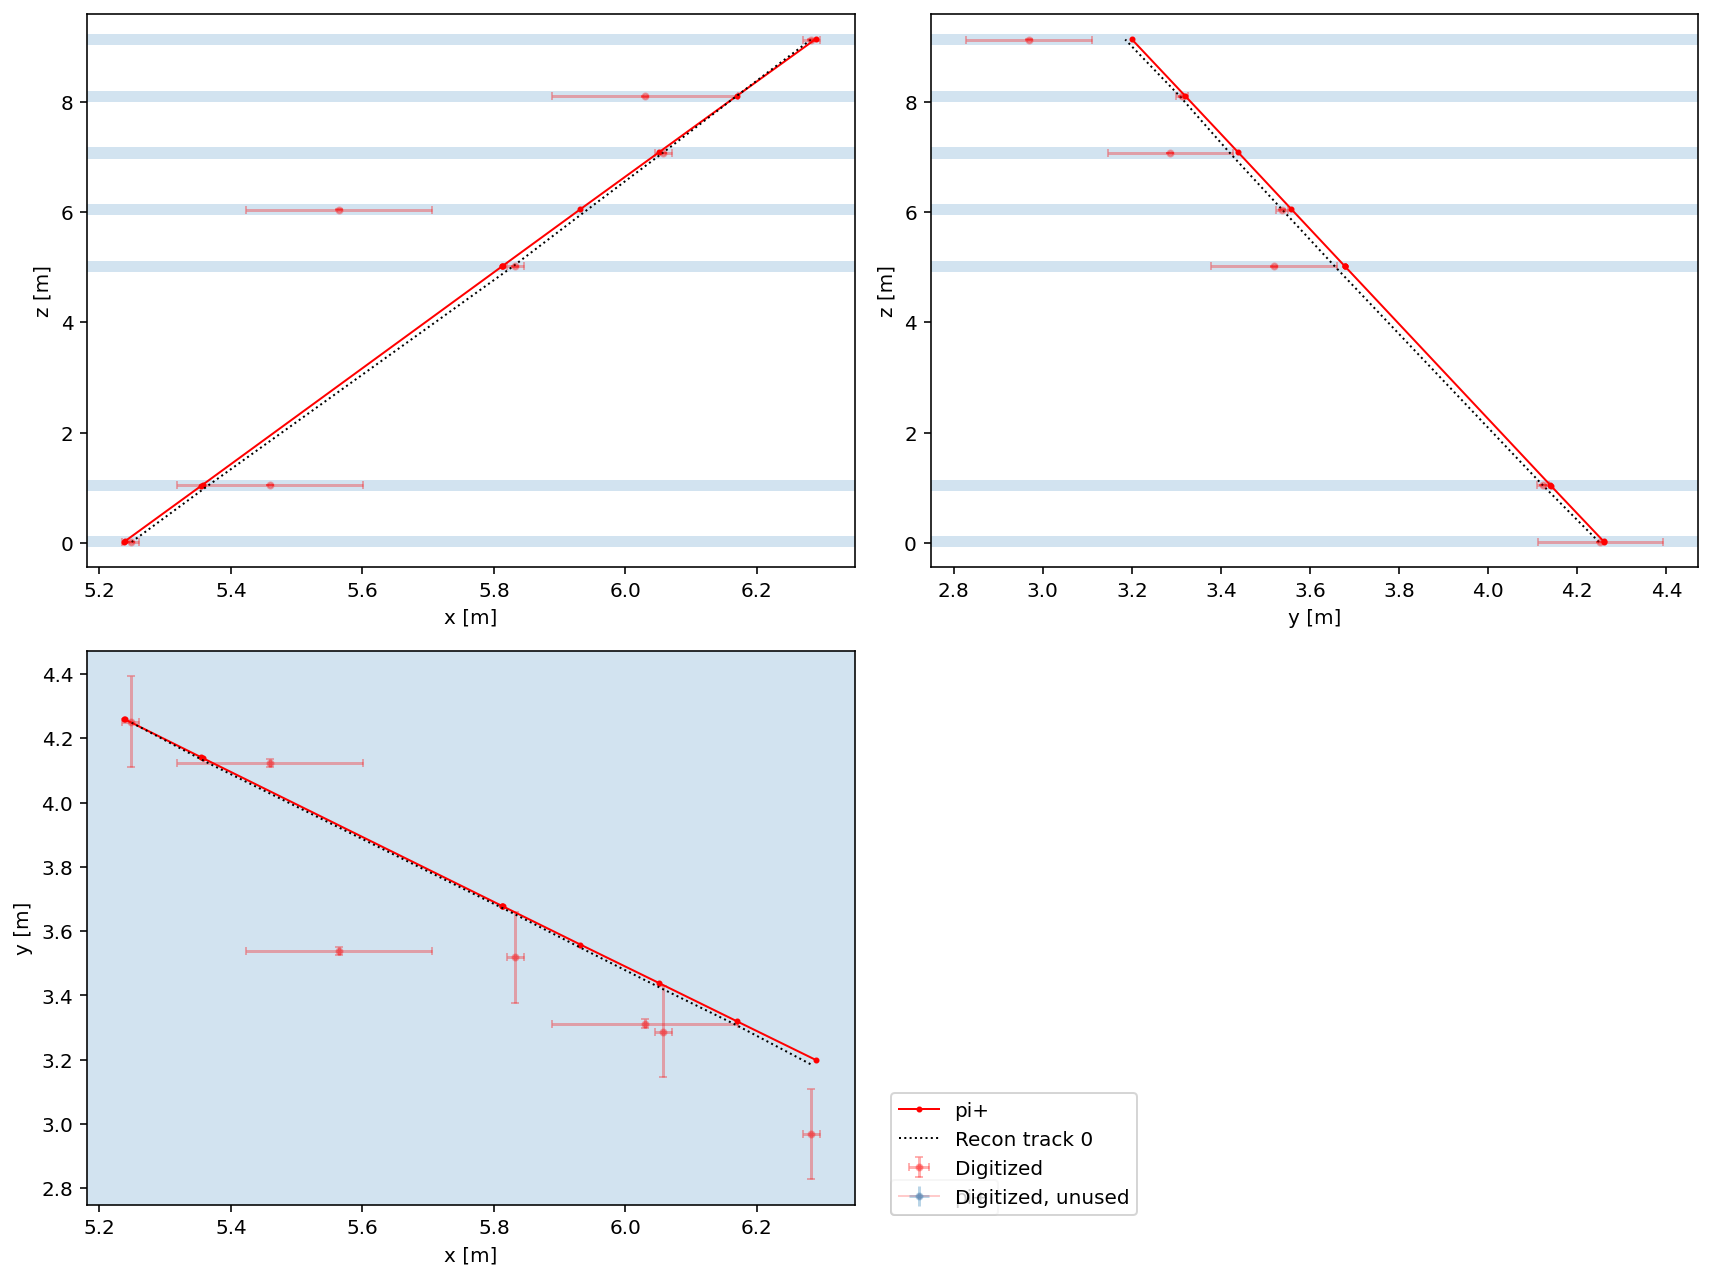

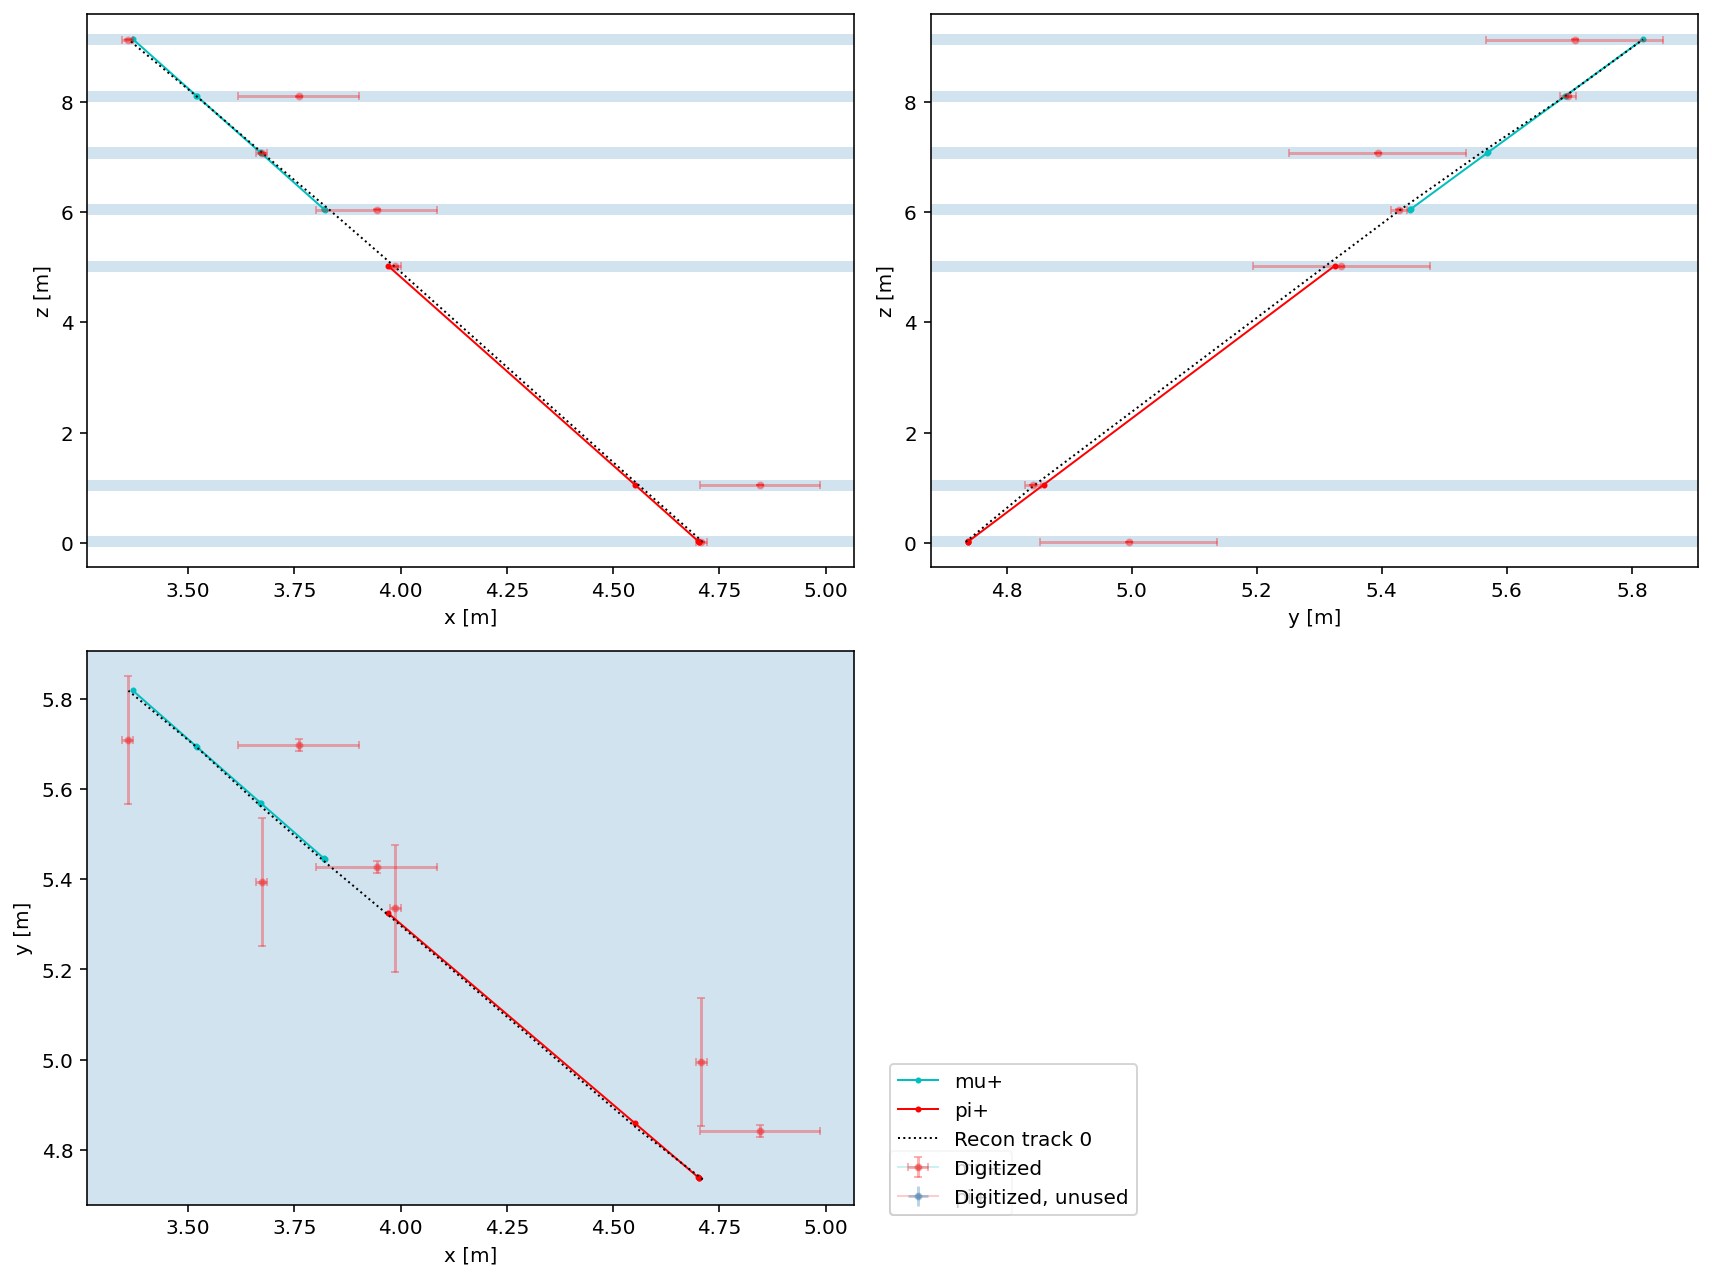

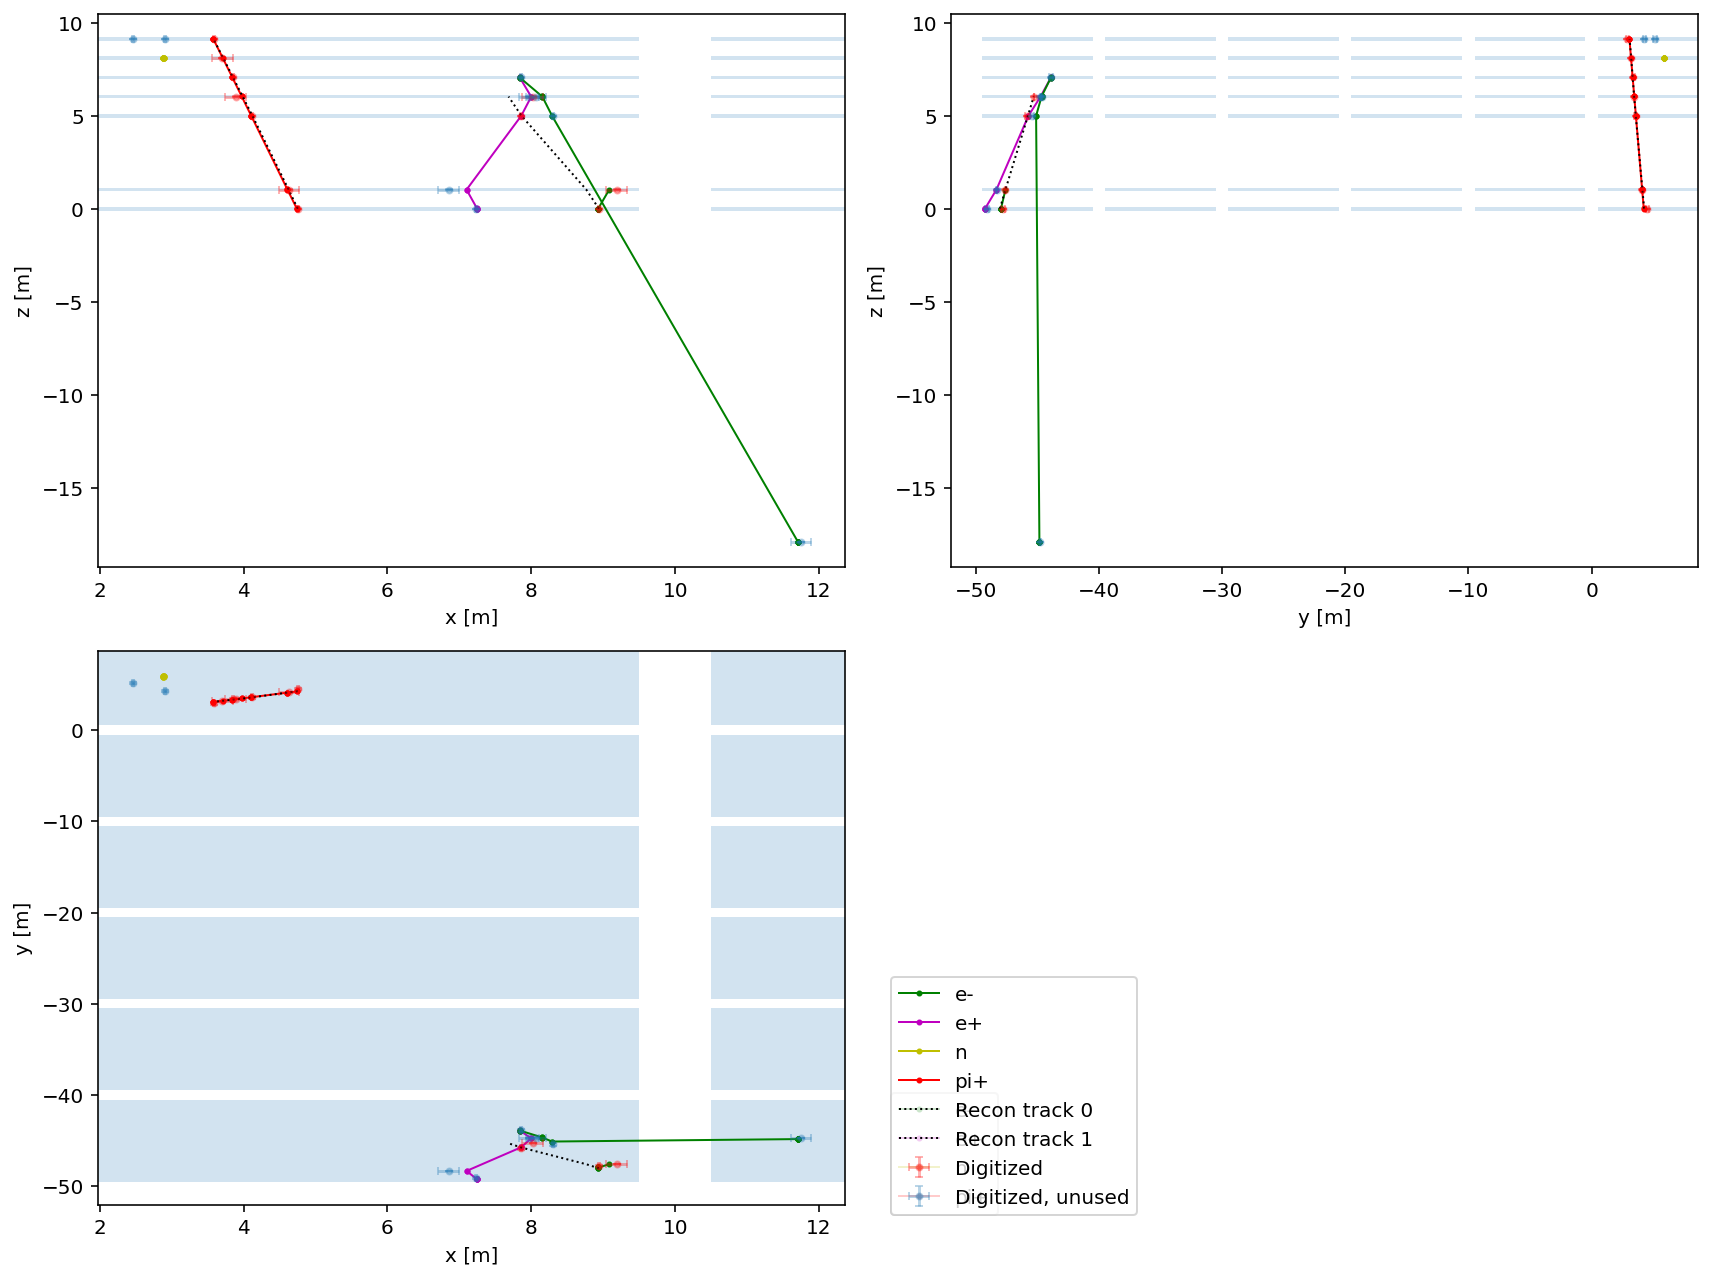

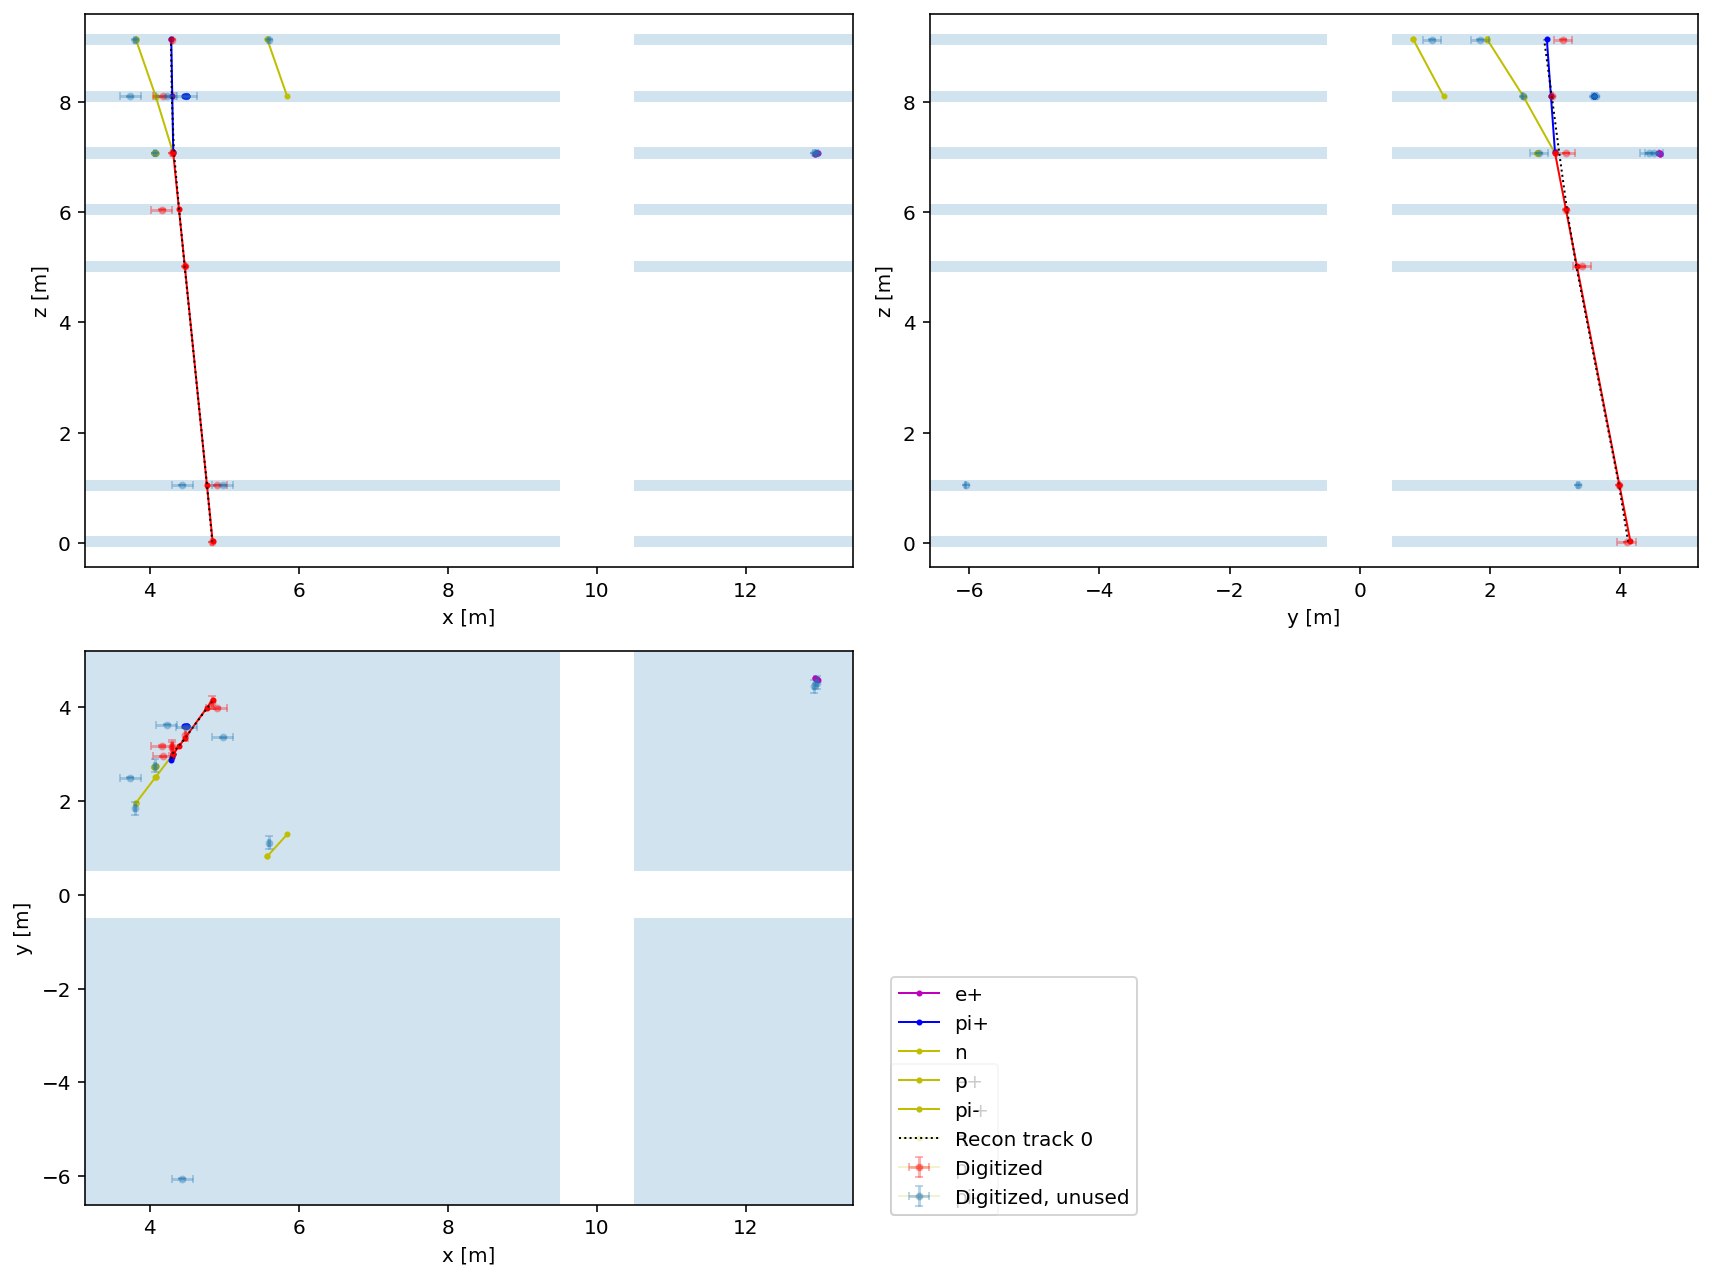

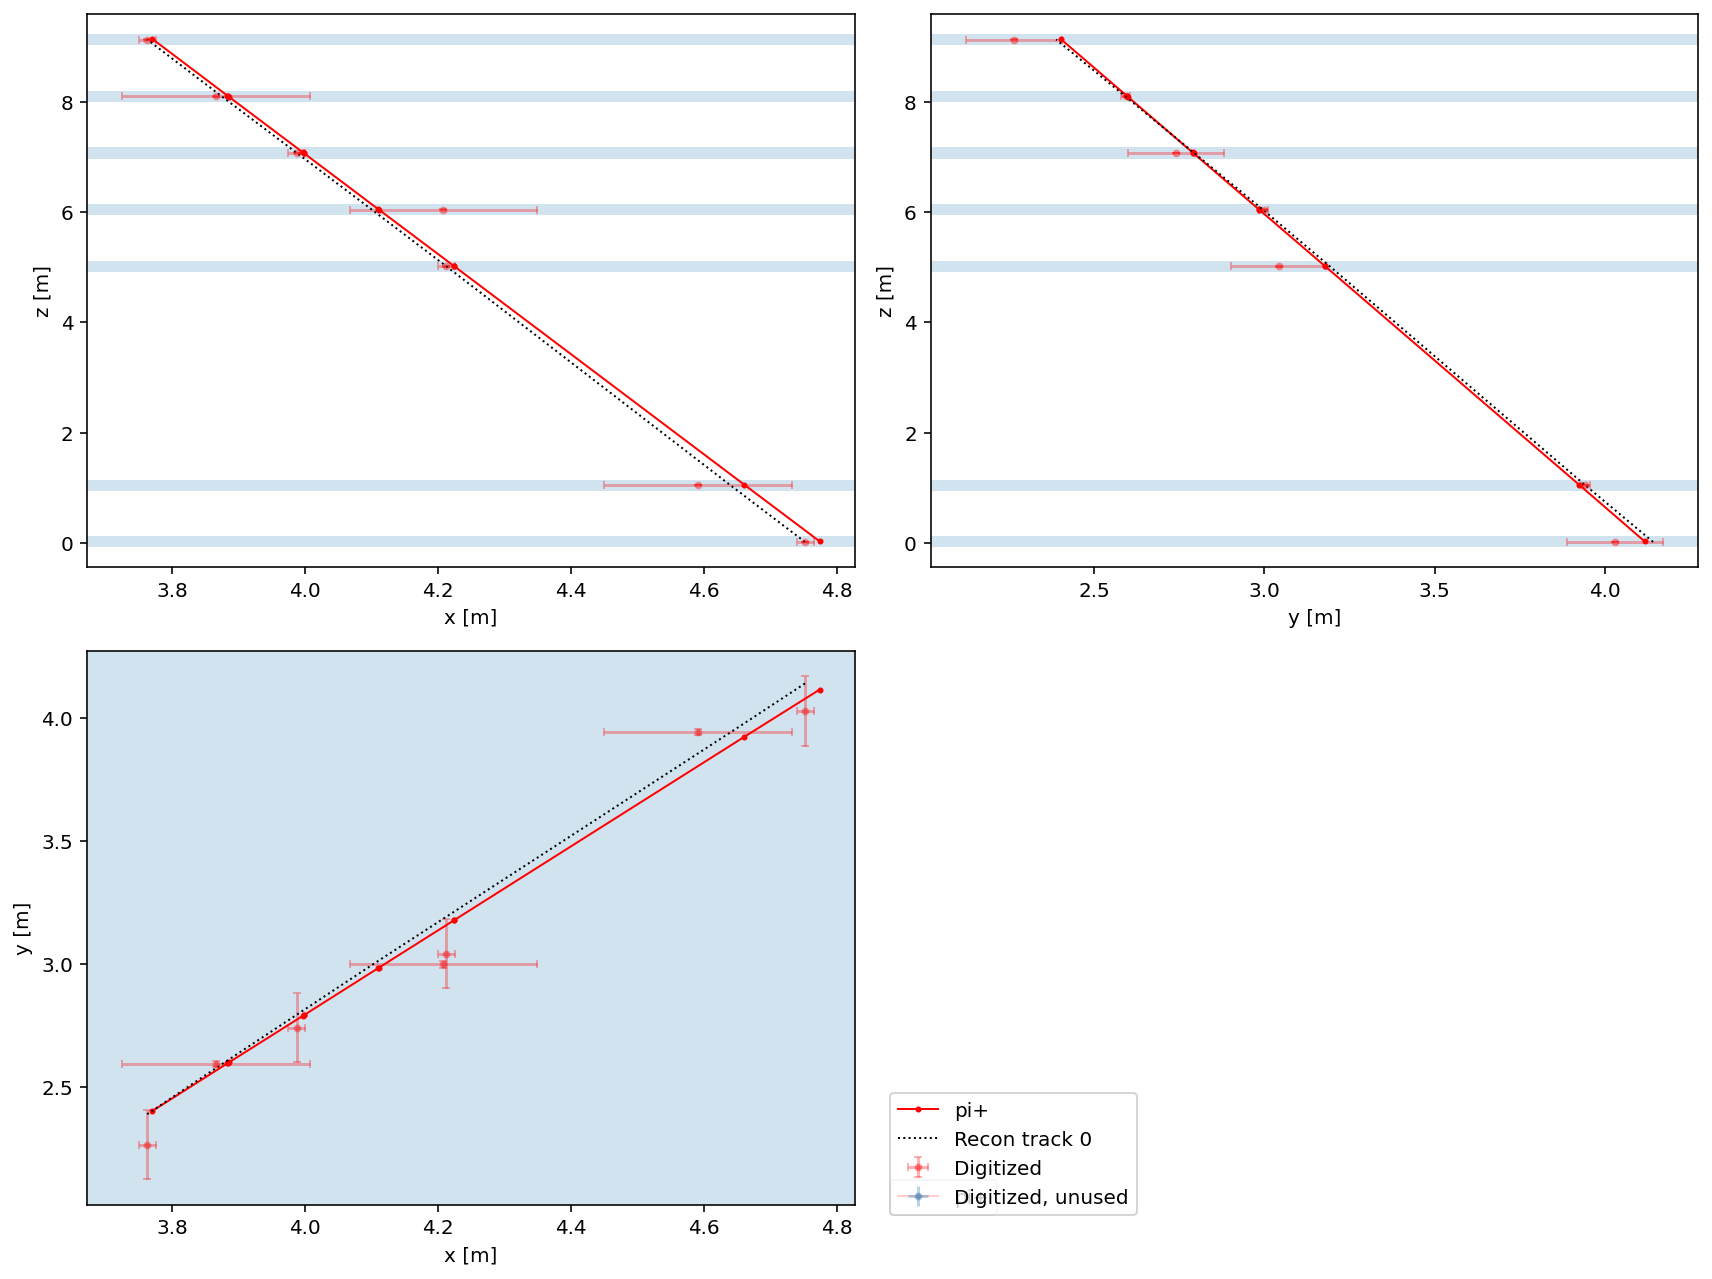

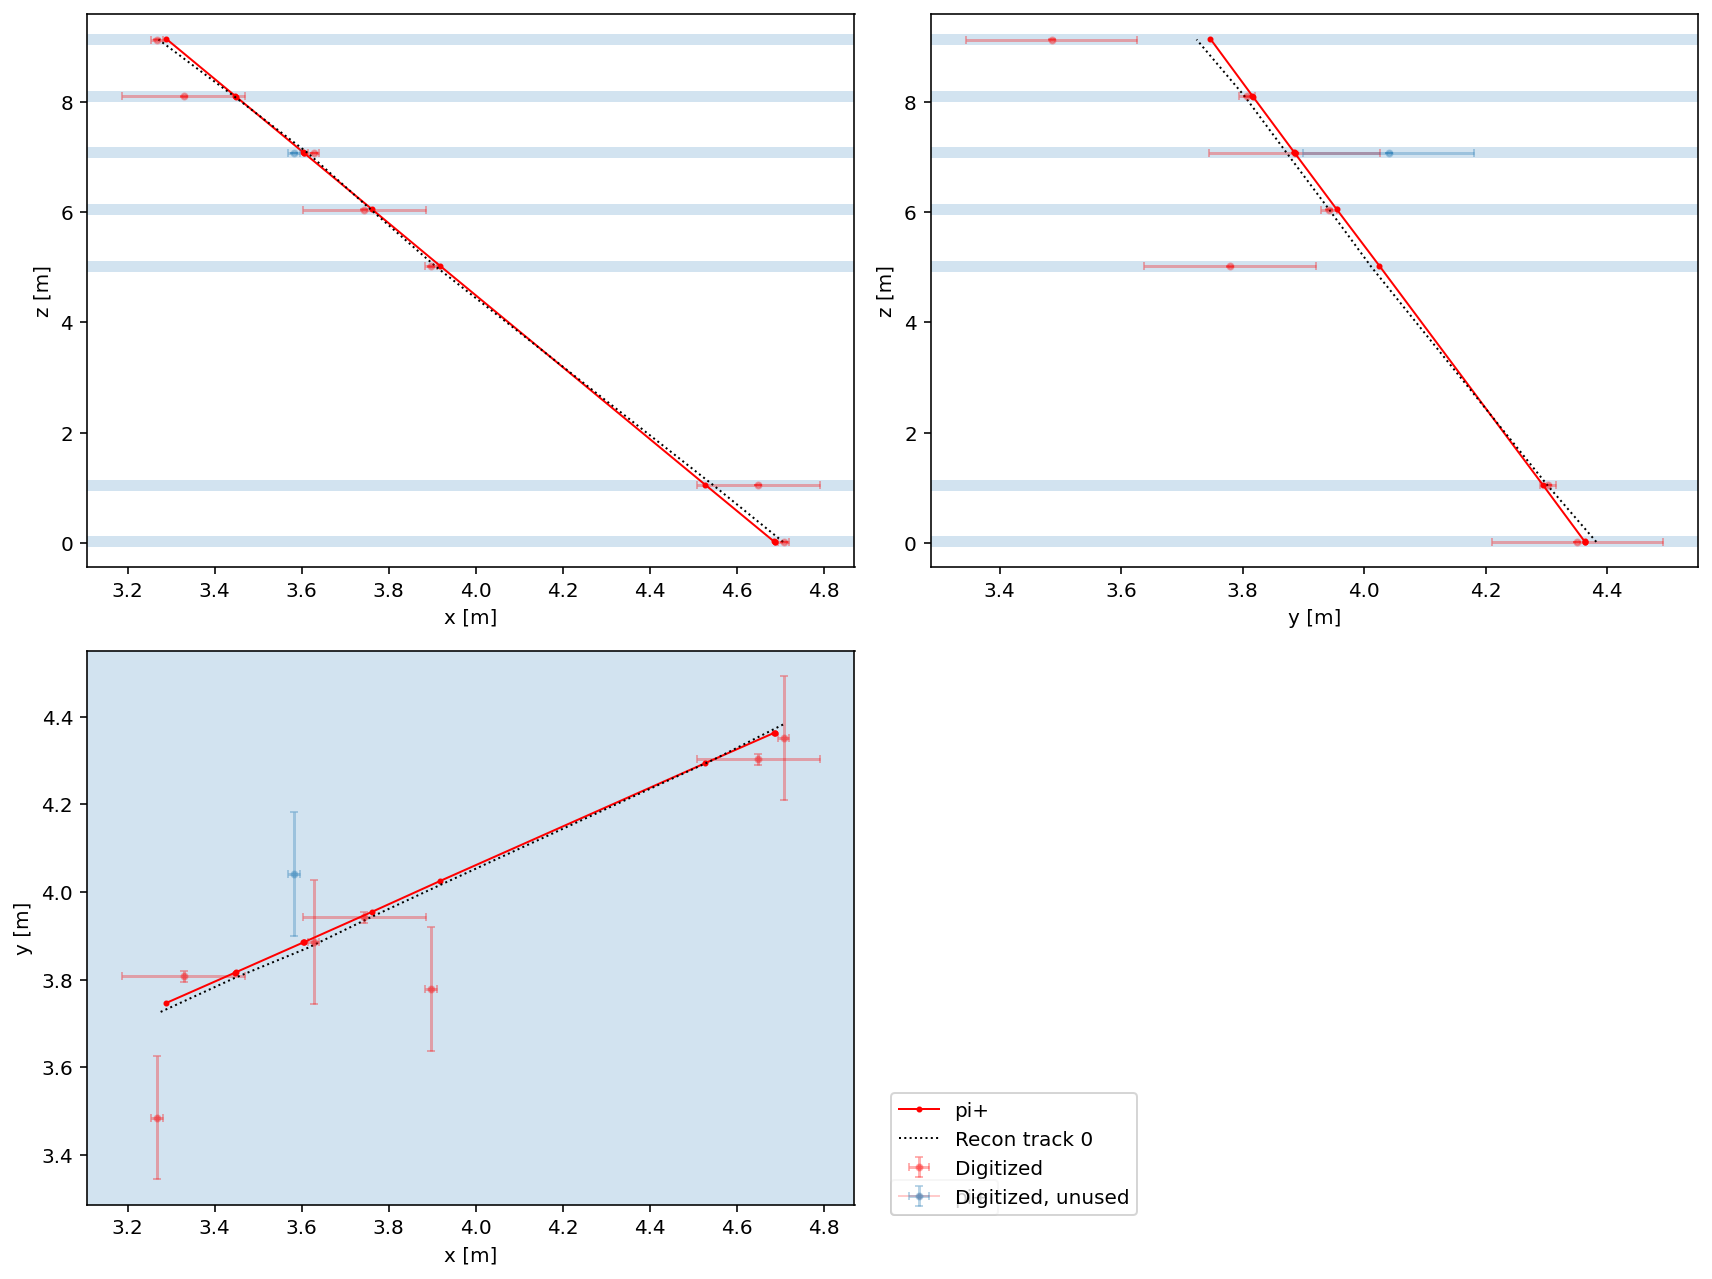

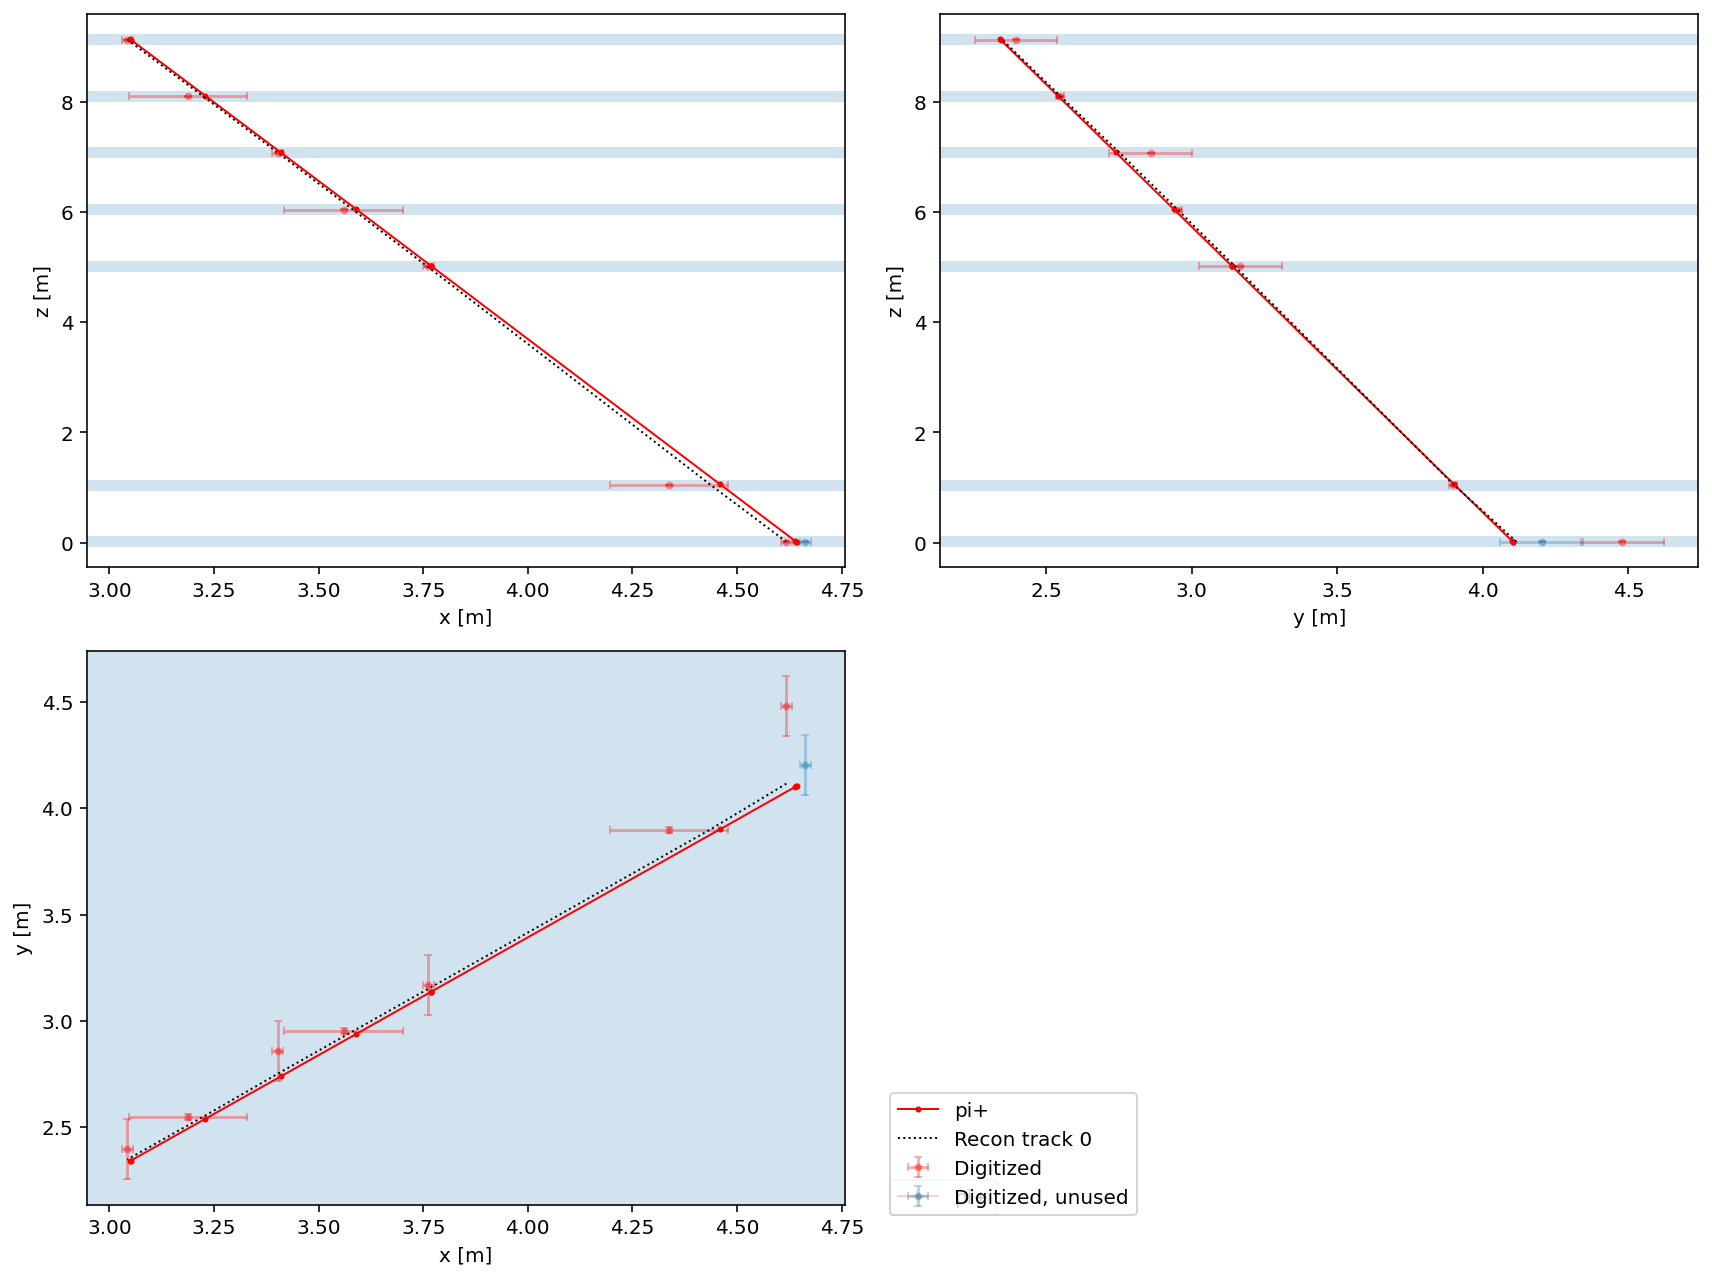

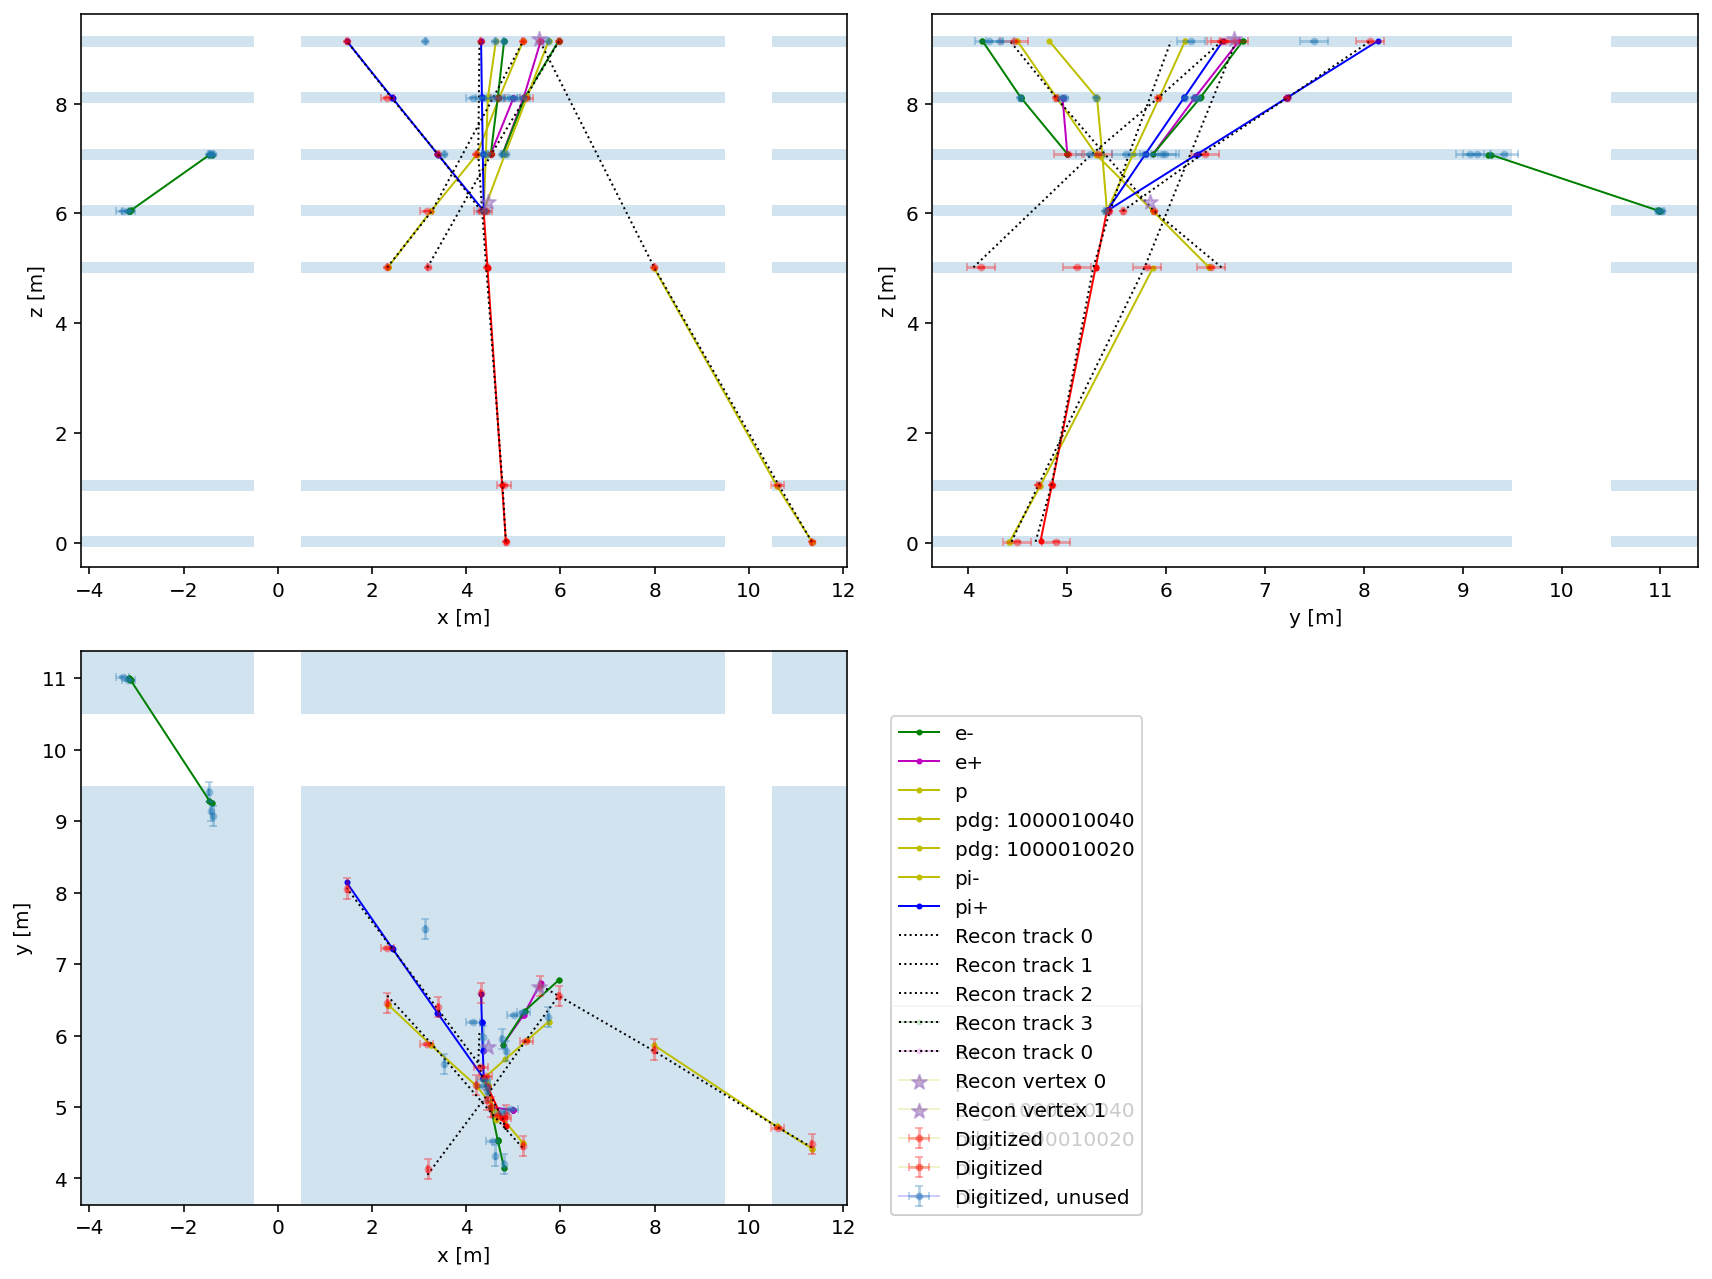

In [73]:
for i in range(10):
    ev.EventNumber+=1
    # 
    # # Plot truth+digi
    # fig,axs=plt.subplots(2,2,figsize=(12,9))
    # fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
    # fig = vis.plot_digi(ev,fig=fig, disp_det_view=True);
    # plt.show()


    # Plot truth+recon
    fig,axs=plt.subplots(2,2,figsize=(12,9))
    fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
    fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True);
    plt.show()

## Do it again for 0.5 GeV

In [76]:
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/pion_0.5_GeV_manual/*/*/stat*.root",)
print(files)
file_prefix='/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_0.5_GeV_manual/20230222/230044/'

['/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_0.5_GeV_manual/20230222/230044/stat_original.root', '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_0.5_GeV_manual/20230222/230044/stat_noscatter.root', '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_0.5_GeV_manual/20230222/230044/stat0.root']


  0%|          | 1/39998 [00:00<1:17:16,  8.63it/s]/project/6035200/tomren/jupyter/tracker_analysis/lsfit.py:102: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


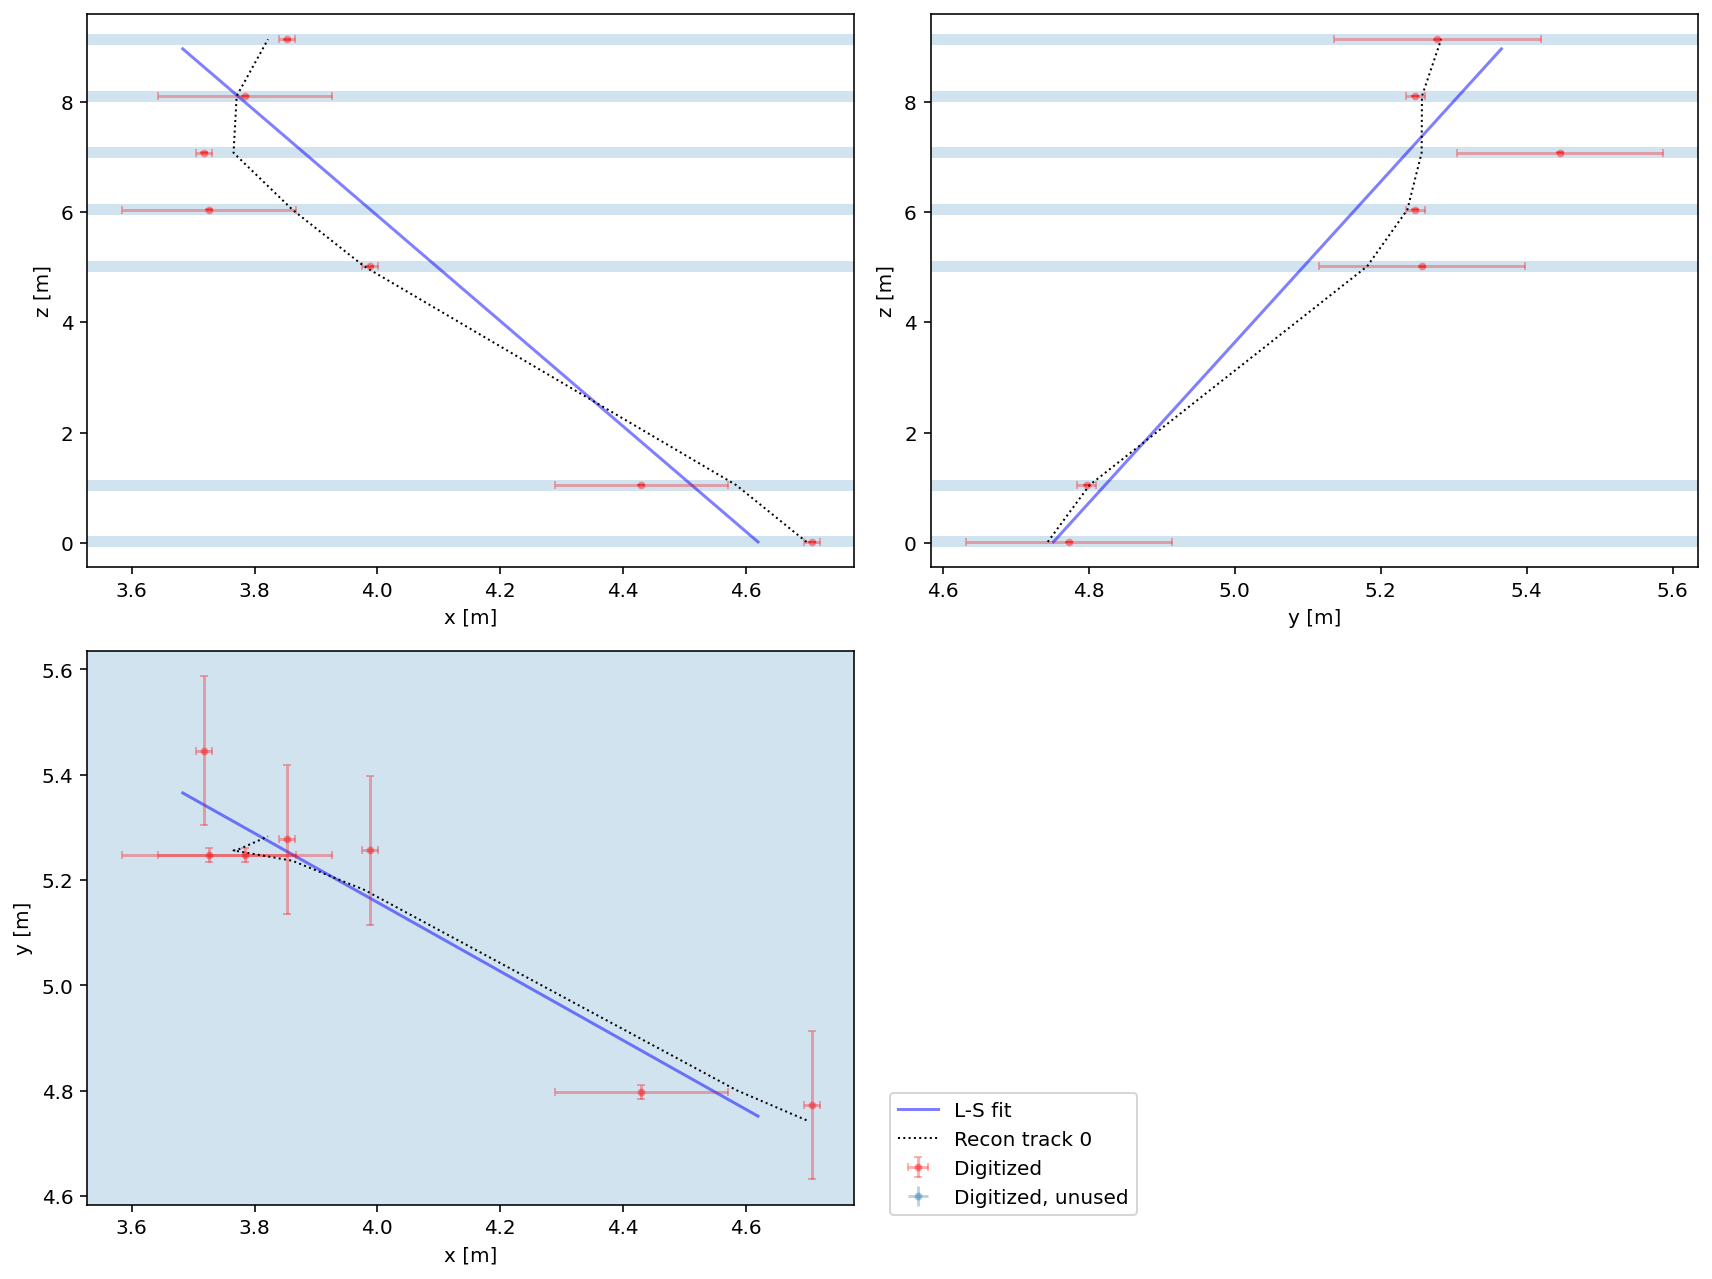

  0%|          | 2/39998 [00:00<4:18:04,  2.58it/s]/project/6035200/tomren/jupyter/tracker_analysis/lsfit.py:102: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser
100%|██████████| 39998/39998 [10:54<00:00, 61.12it/s]


In [77]:
results_fit={}
results_fit["ndigi"]=[]
results_fit["par_truth"]=[]
results_fit["par_fit"]=[]
results_fit["par_fit_error"]=[]
results_fit["par_km"]=[]
results_fit["par_km_error"]=[]

MAKE_PLOTS=True
PLOT_MAX=1
nplots=0

# for i_file in range(len(files)):
# for i_file in range(20):
if 1:
    filename=f"{file_prefix}/stat0.root"
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    # ev.EventNumber=4
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")



    for i_event in tqdm(range(nevents)):
#     for i_event in tqdm(range(2)):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        
        # Find the track with exactly 7 hits
        digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
        if len(digi_hit_inds)==0:
            continue
        digi_hit_len = np.array([len(i) for i in digi_hit_inds])
        track_ind = int(np.argmax(digi_hit_len==7))
        track_hits_inds=digi_hit_inds[track_ind]   
        hits=np.array(hits)[track_hits_inds]
        
#         if len(ev.Tree.Digi_x)==7:
        if len(hits)==7:            
            try:
                par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
                par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
                xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
                xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])
            except:
                continue
                
            
            # Do LS fit
            guess=guess_track(hits)
            fit1=fit_track(hits,guess)
            par_fit=list(fit1.values)
            par_fit_error=list(fit1.errors)
            xyz0_fit = util.coord_cms2det(np.array(par_fit[:3]))
            xyzV_fit = np.array([par_fit[2+4],par_fit[0+4],par_fit[1+4]])
            time_seq=np.linspace(0,ev.Tree.Digi_time[-1]-ev.Tree.Hit_time[0],100)
            
            # Get Truth value
            Tree=ev.Tree
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
            xyz0_truth = util.coord_cms2det(np.array([Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0]]))

            # Save results
            results_fit["ndigi"].append(len(Tree.Digi_x))
            results_fit["par_truth"].append(par_truth)
            results_fit["par_fit"].append(par_fit)
            results_fit["par_fit_error"].append(par_fit_error)
            results_fit["par_km"].append(par_km)
            results_fit["par_km_error"].append(par_km_error)
            
            # Make plots
            if MAKE_PLOTS and nplots<PLOT_MAX:
                nplots+=1
                
                # Plot truth+recon
                fig,axs=plt.subplots(2,2,figsize=(12,9))
                # fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
                axs=axs.flatten()
                axs[0].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                                 xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                                 color="b",alpha=0.5,label="L-S fit")  
                axs[1].plot(xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                                 xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                                 color="b",alpha=0.5,label="L-S fit")    
                axs[2].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                                 xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                                 color="b",alpha=0.5,label="L-S fit")                  
                fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=False);
                plt.show()
                
                
for key in results_fit:
    results_fit[key]=np.array(results_fit[key])                

In [80]:
for i,filename in enumerate([f"{file_prefix}/stat_noscatter.root",f"{file_prefix}/stat_original.root"]):
    results_fit[f"ndigi_{i}"] =[]
    results_fit[f"par_truth_{i}"] =[]
    results_fit[f"par_km_{i}"]=[]
    results_fit[f"par_km_error_{i}"]=[]
    
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    # ev.EventNumber=4
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")



    for i_event in tqdm(range(nevents)):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        
        # Find the track with exactly 7 hits
        digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
        if len(digi_hit_inds)==0:
            continue
        digi_hit_len = np.array([len(i) for i in digi_hit_inds])
        track_ind = int(np.argmax(digi_hit_len==7))
        track_hits_inds=digi_hit_inds[track_ind]   
        hits=np.array(hits)[track_hits_inds]
        
#         if len(ev.Tree.Digi_x)==7:
        if len(hits)==7:   
            try:
                par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
                par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
            except:
                continue

            #truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])
            Tree=ev.Tree
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]

            results_fit[f"ndigi_{i}"].append(len(Tree.Digi_x))
            results_fit[f"par_truth_{i}"].append(par_truth)
            results_fit[f"par_km_{i}"].append(par_km)
            results_fit[f"par_km_error_{i}"].append(par_km_error)
            
for key in results_fit:
    results_fit[key]=np.array(results_fit[key])   

100%|██████████| 39998/39998 [00:14<00:00, 2694.50it/s]


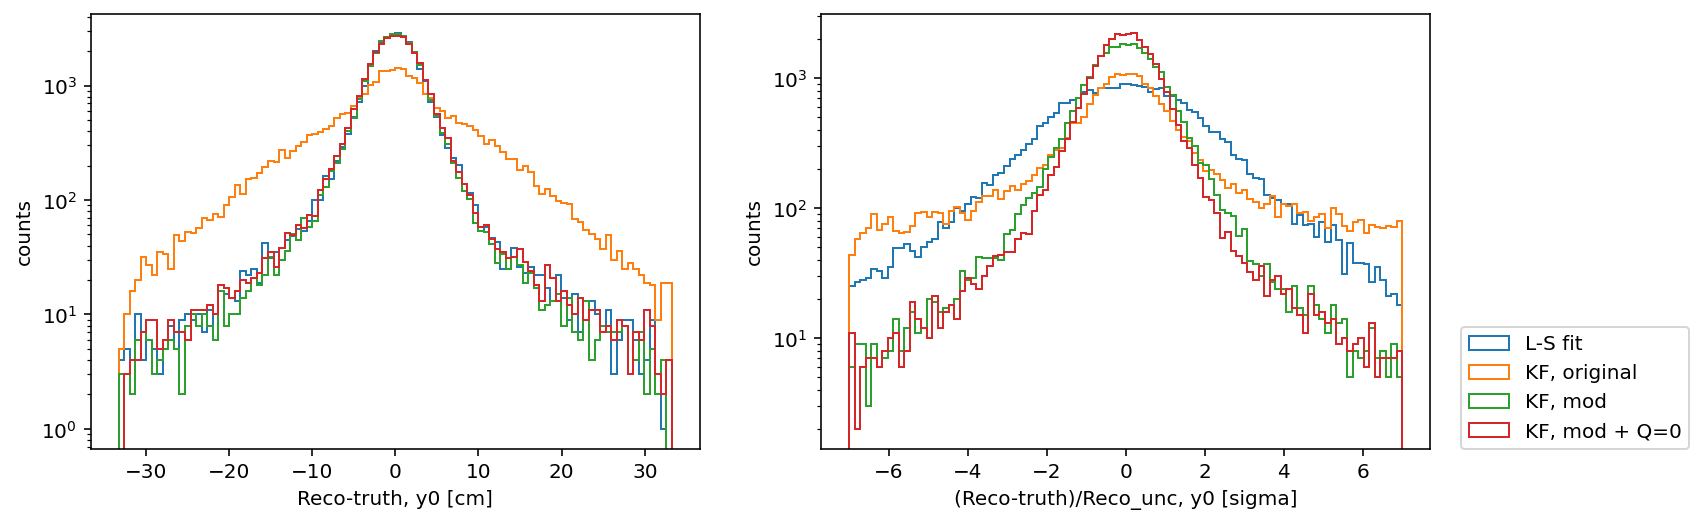

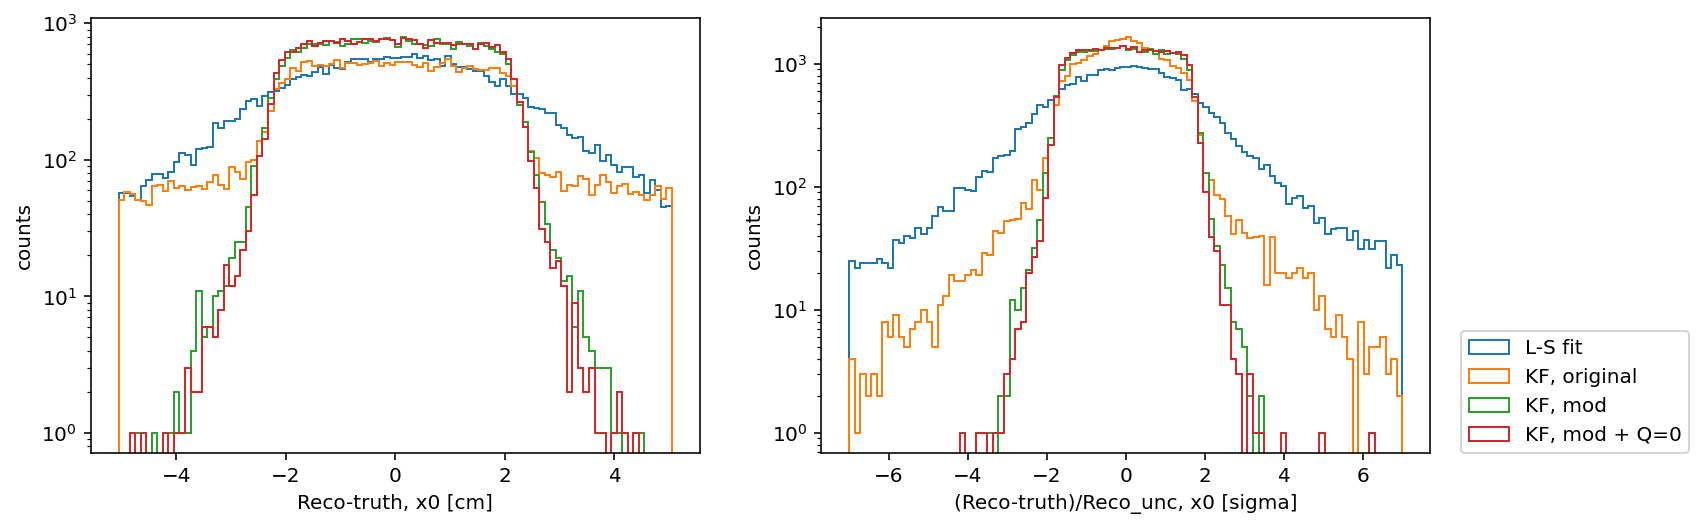

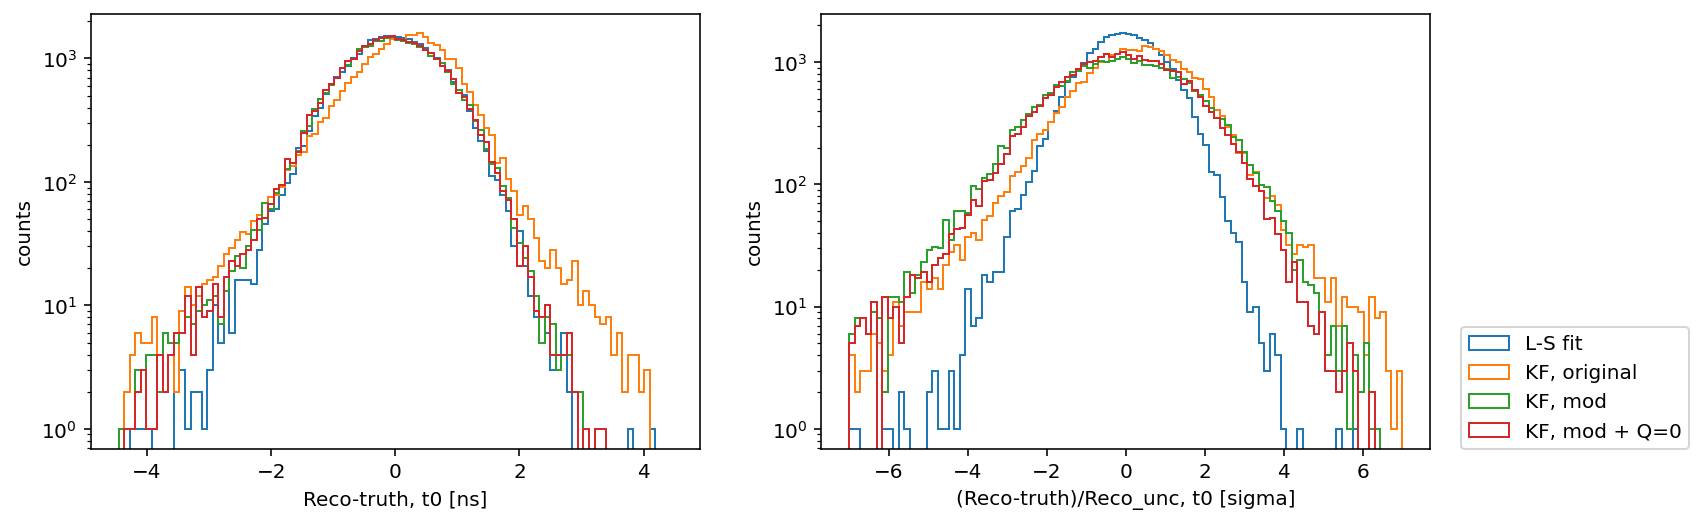

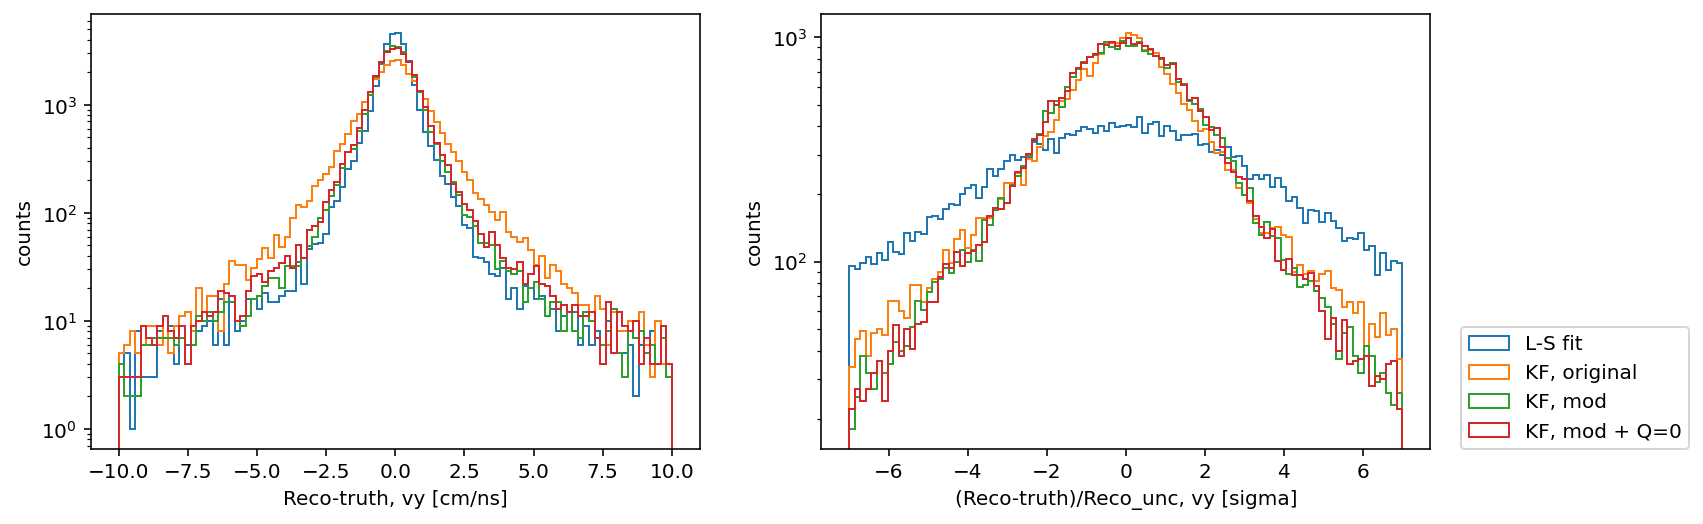

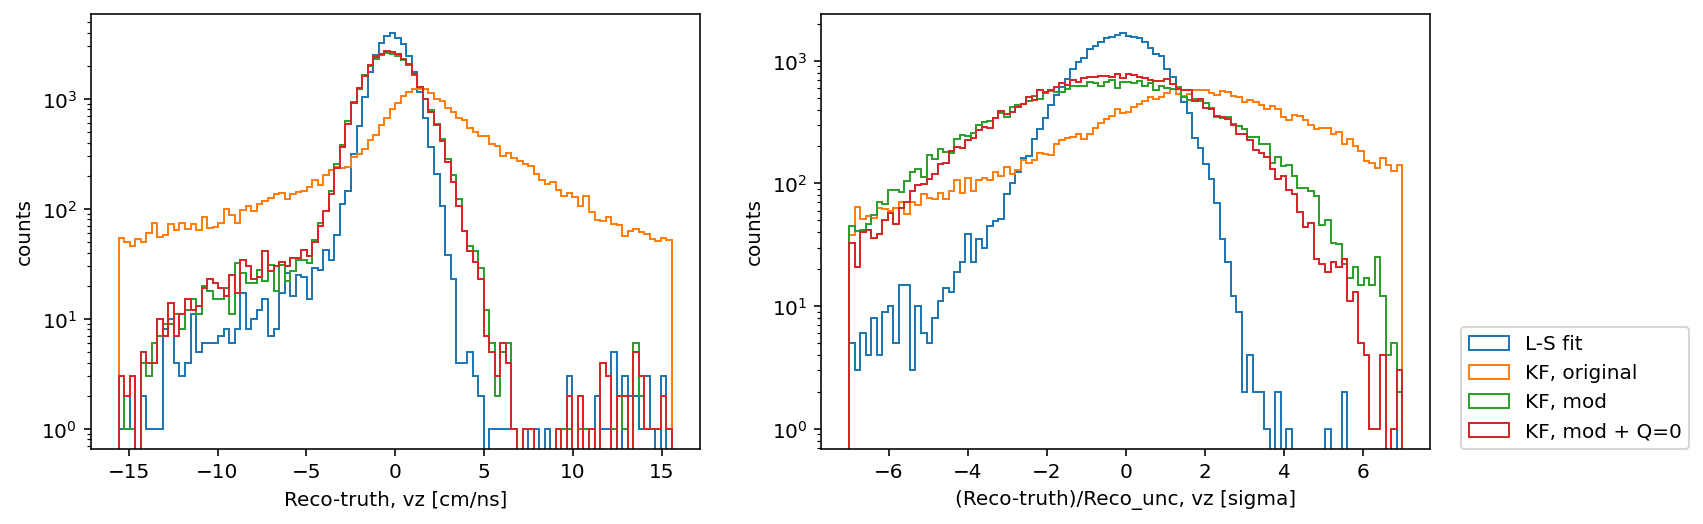

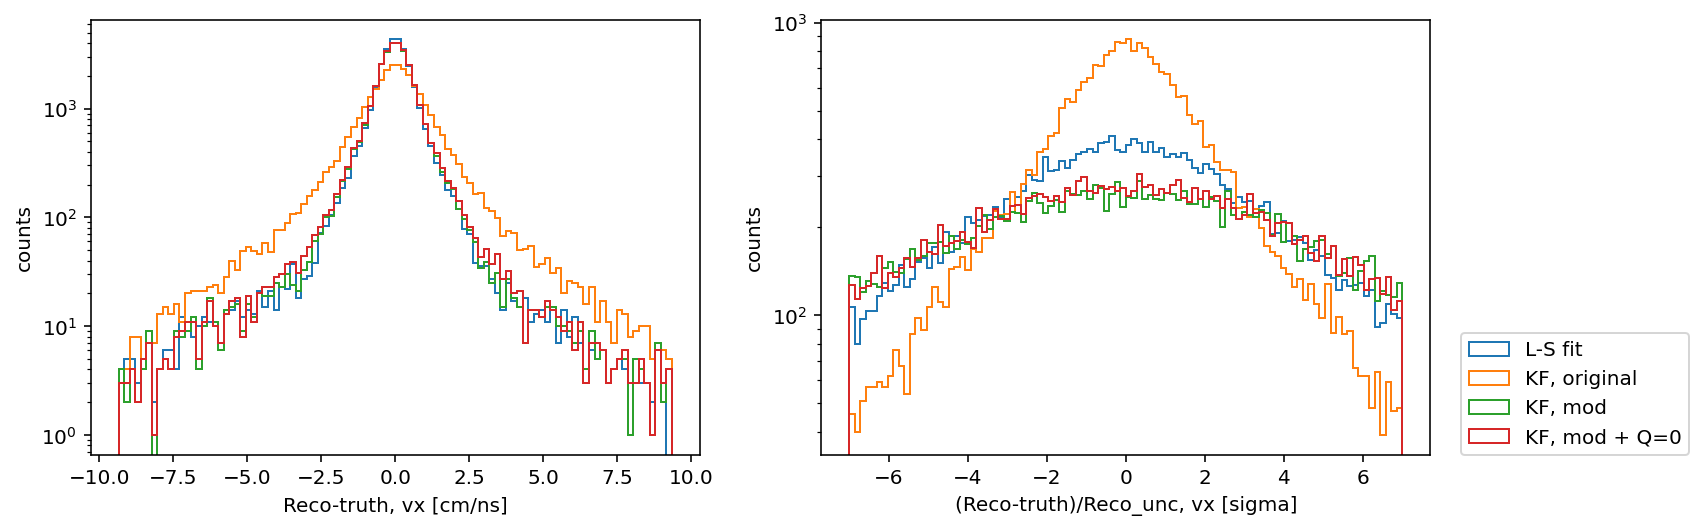

In [82]:
par_names=['y0', 'z0', 'x0', 't0', 'vy', 'vz', 'vx'] # Use real world direction
par_unit= ["[cm]",'[cm]',"[cm]", "[ns]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

        
plot_result()

### Which event failed?

In [85]:
filename=f"{file_prefix}/stat0.root"
tree_name="integral_tree"
ev = event.Event(filename, 0, tree_name=tree_name)

26


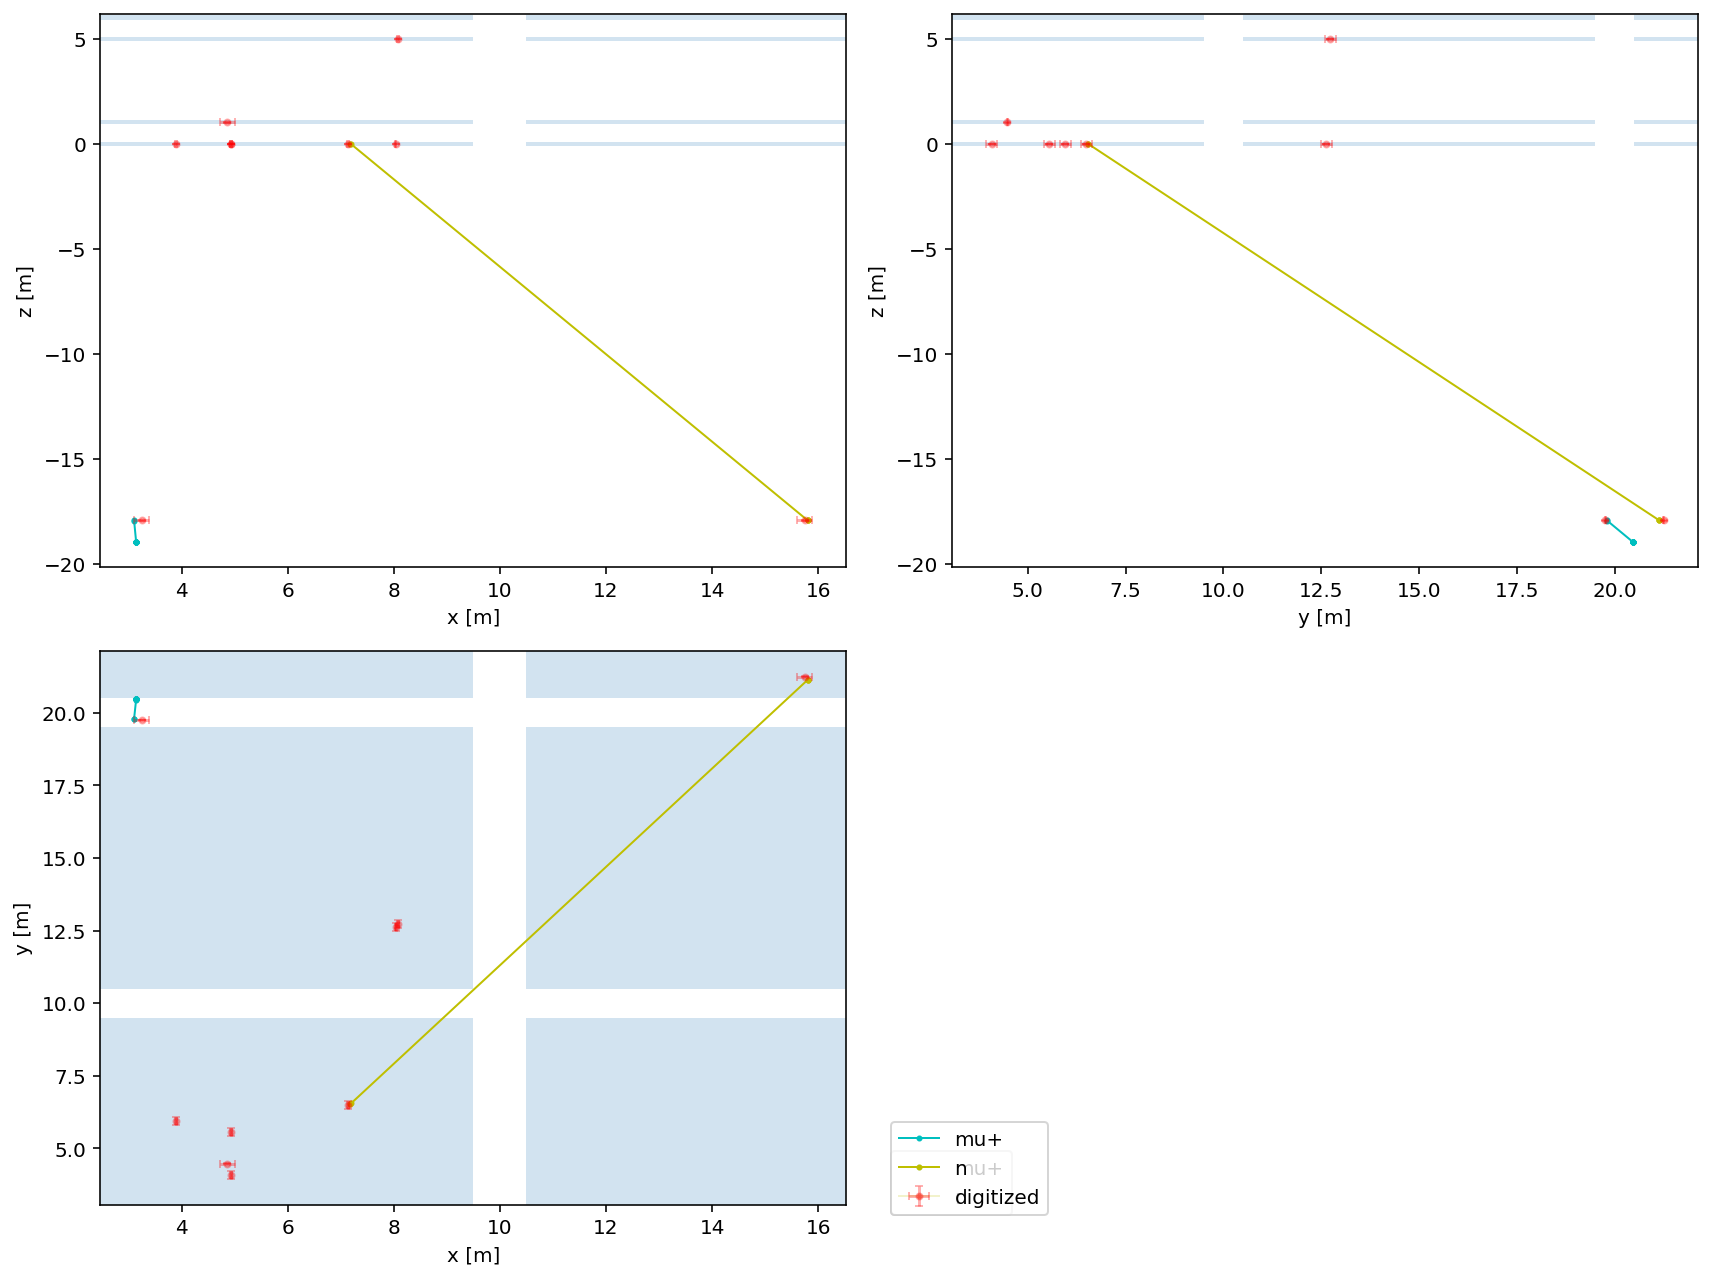

31


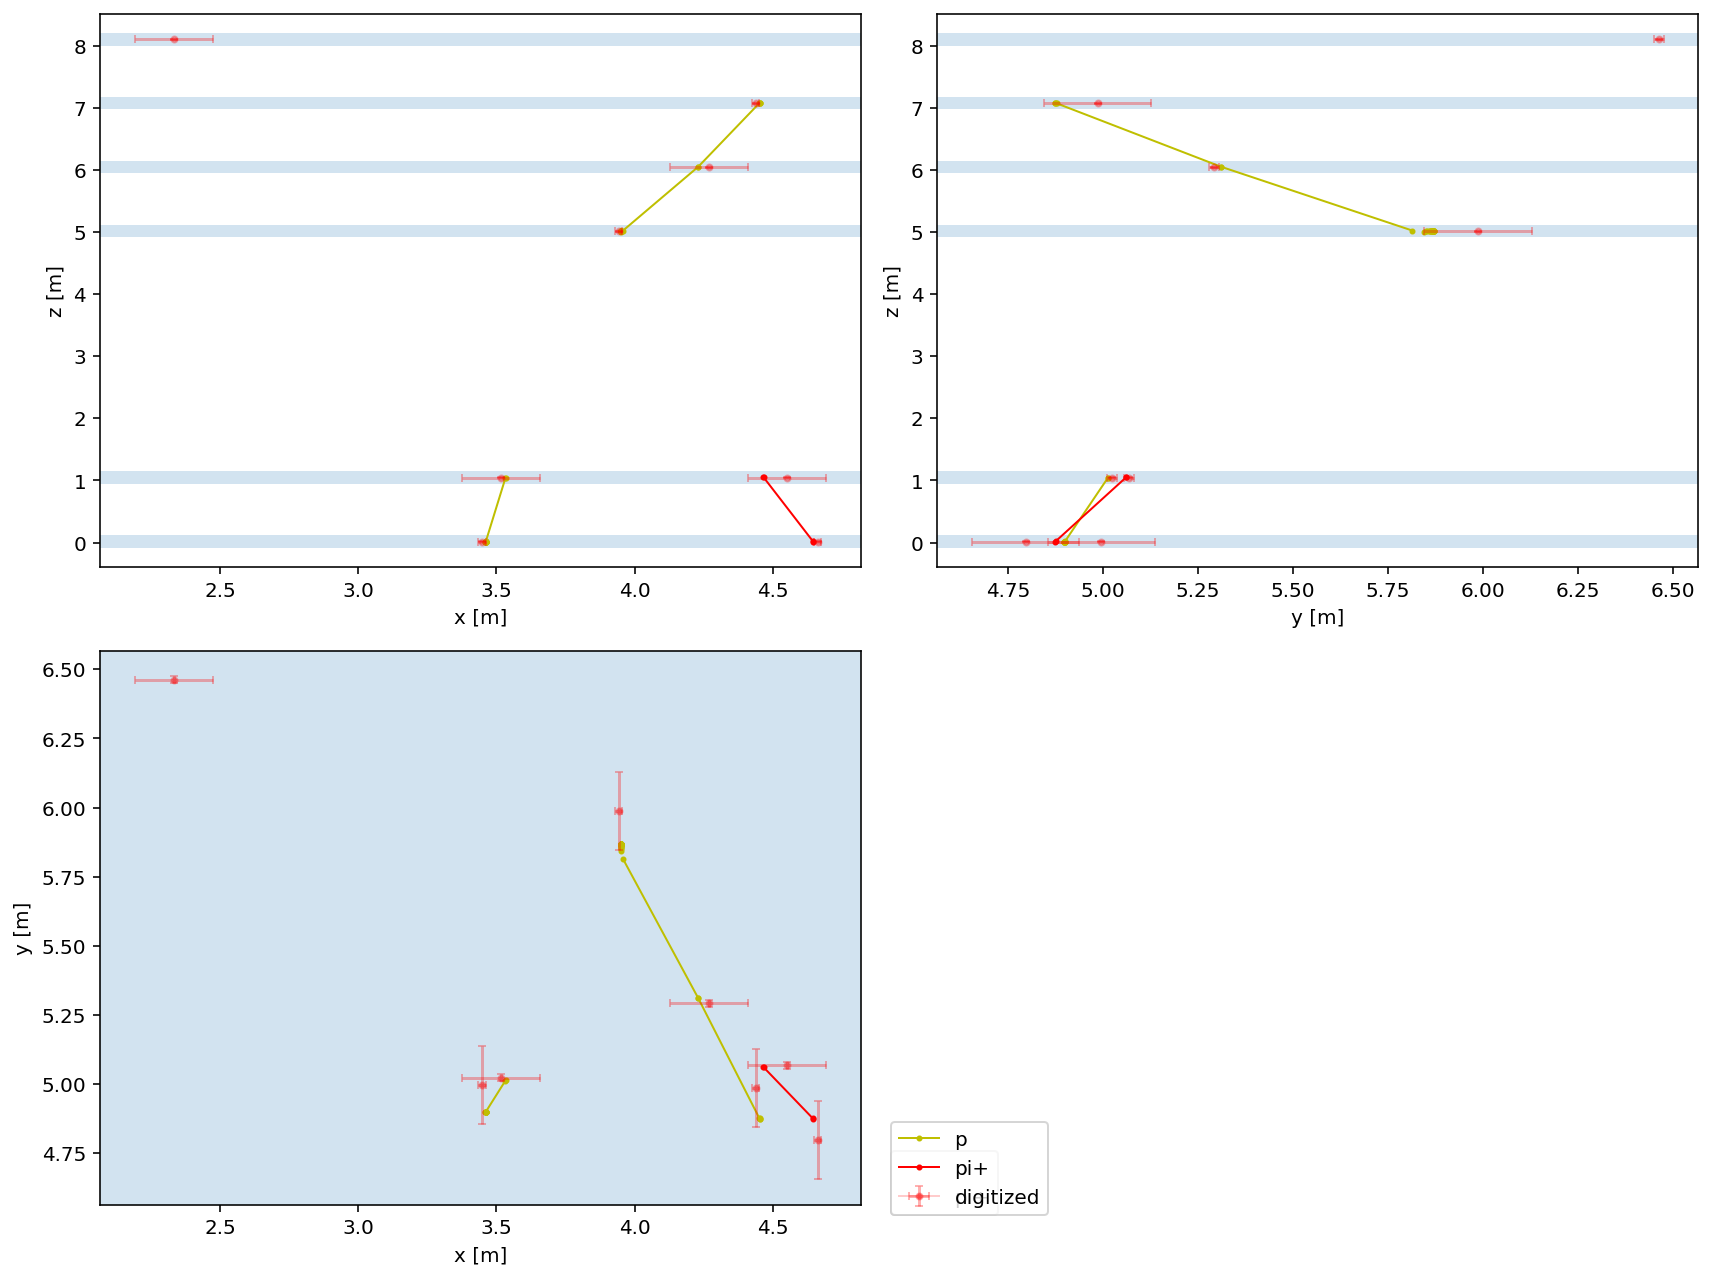

34


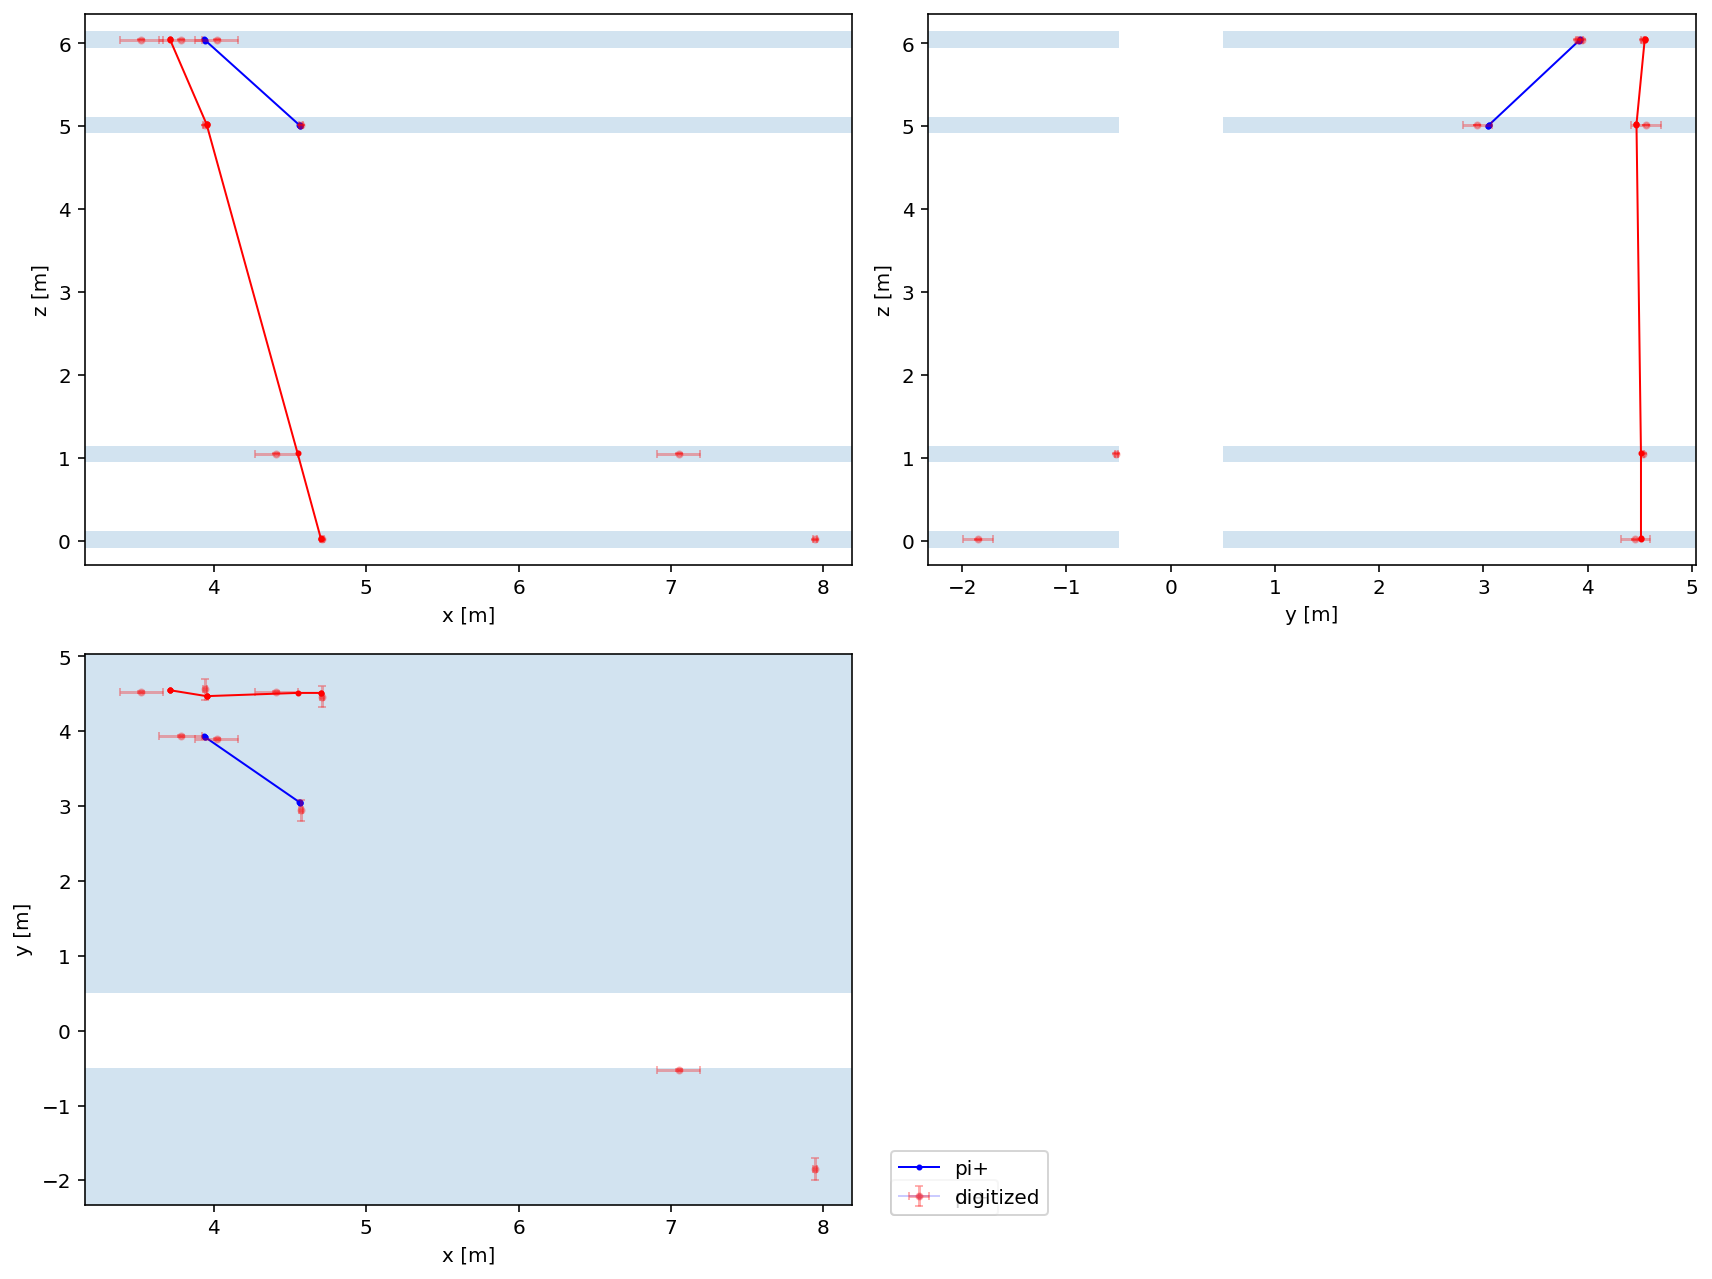

47


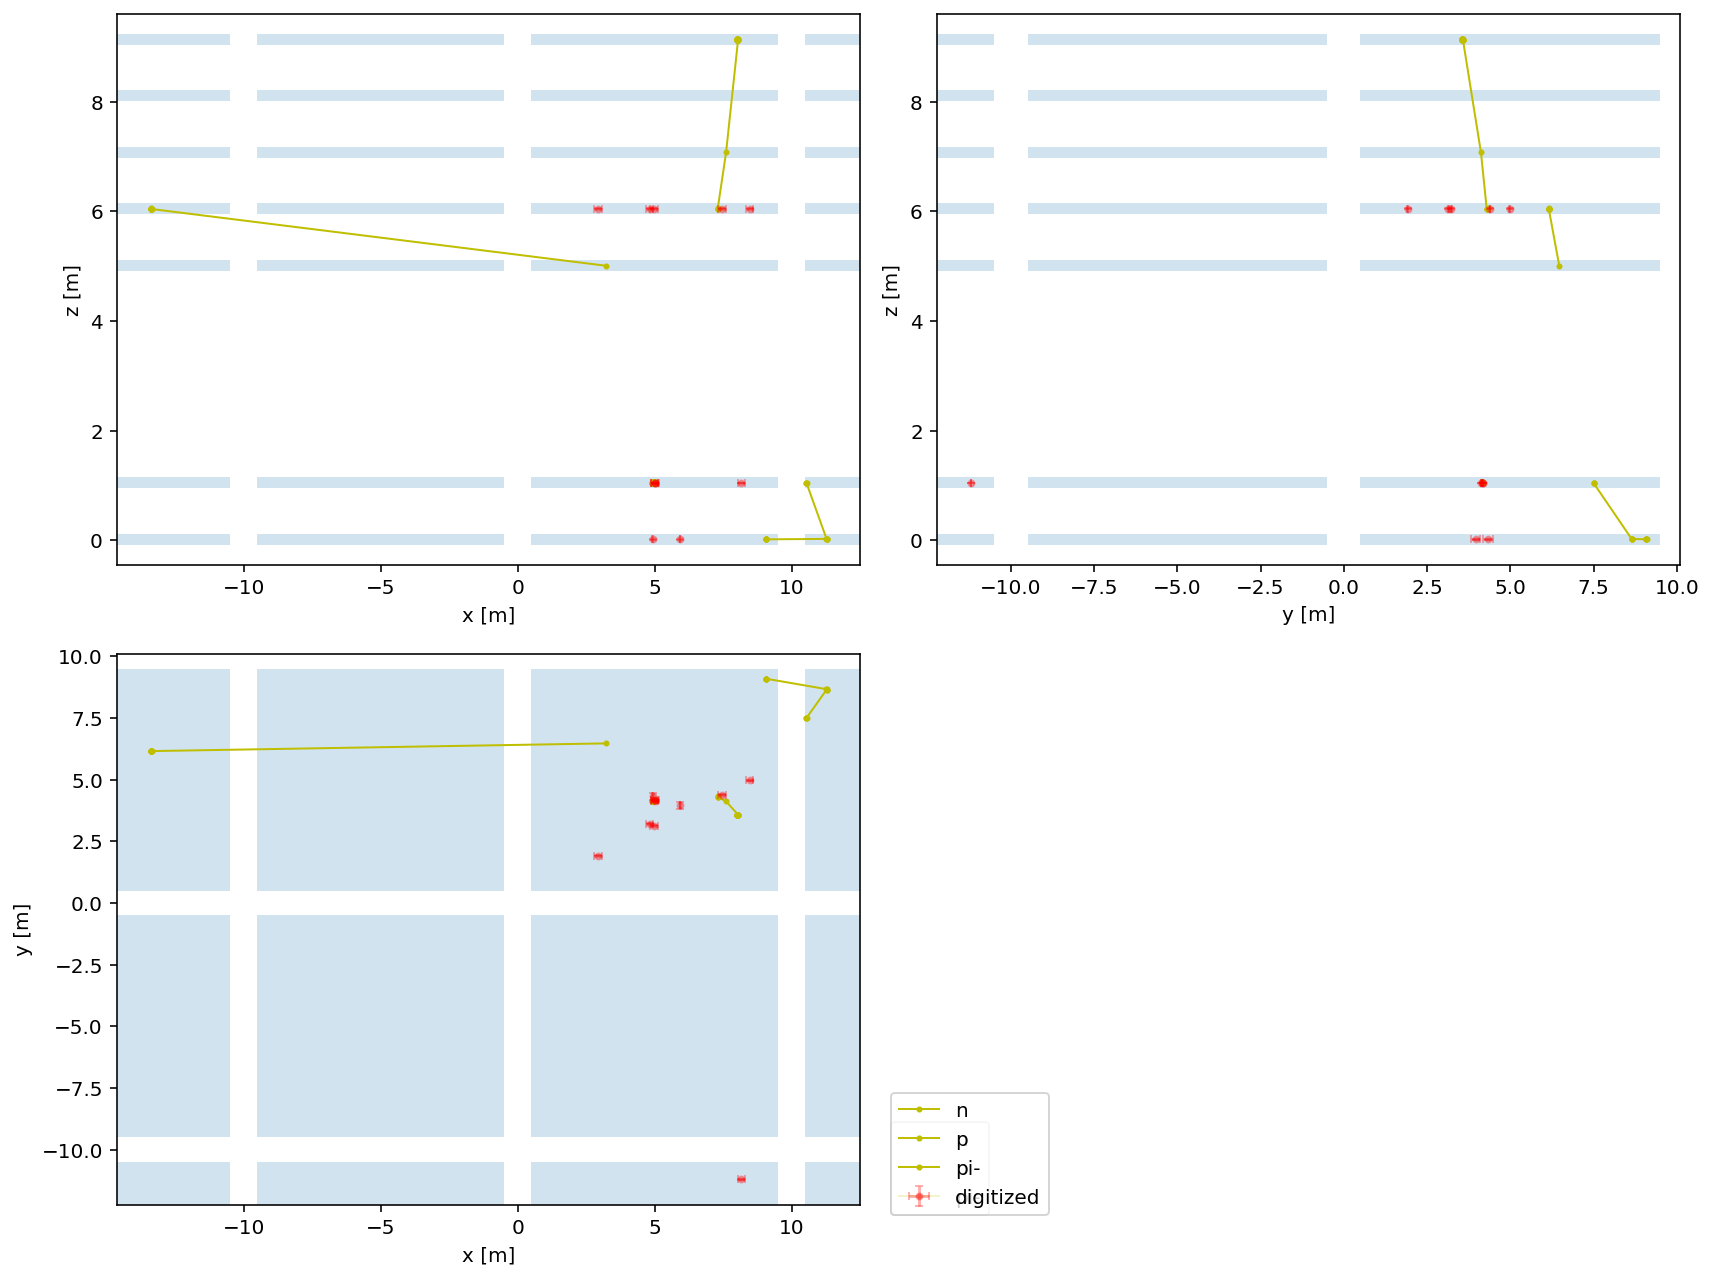

48


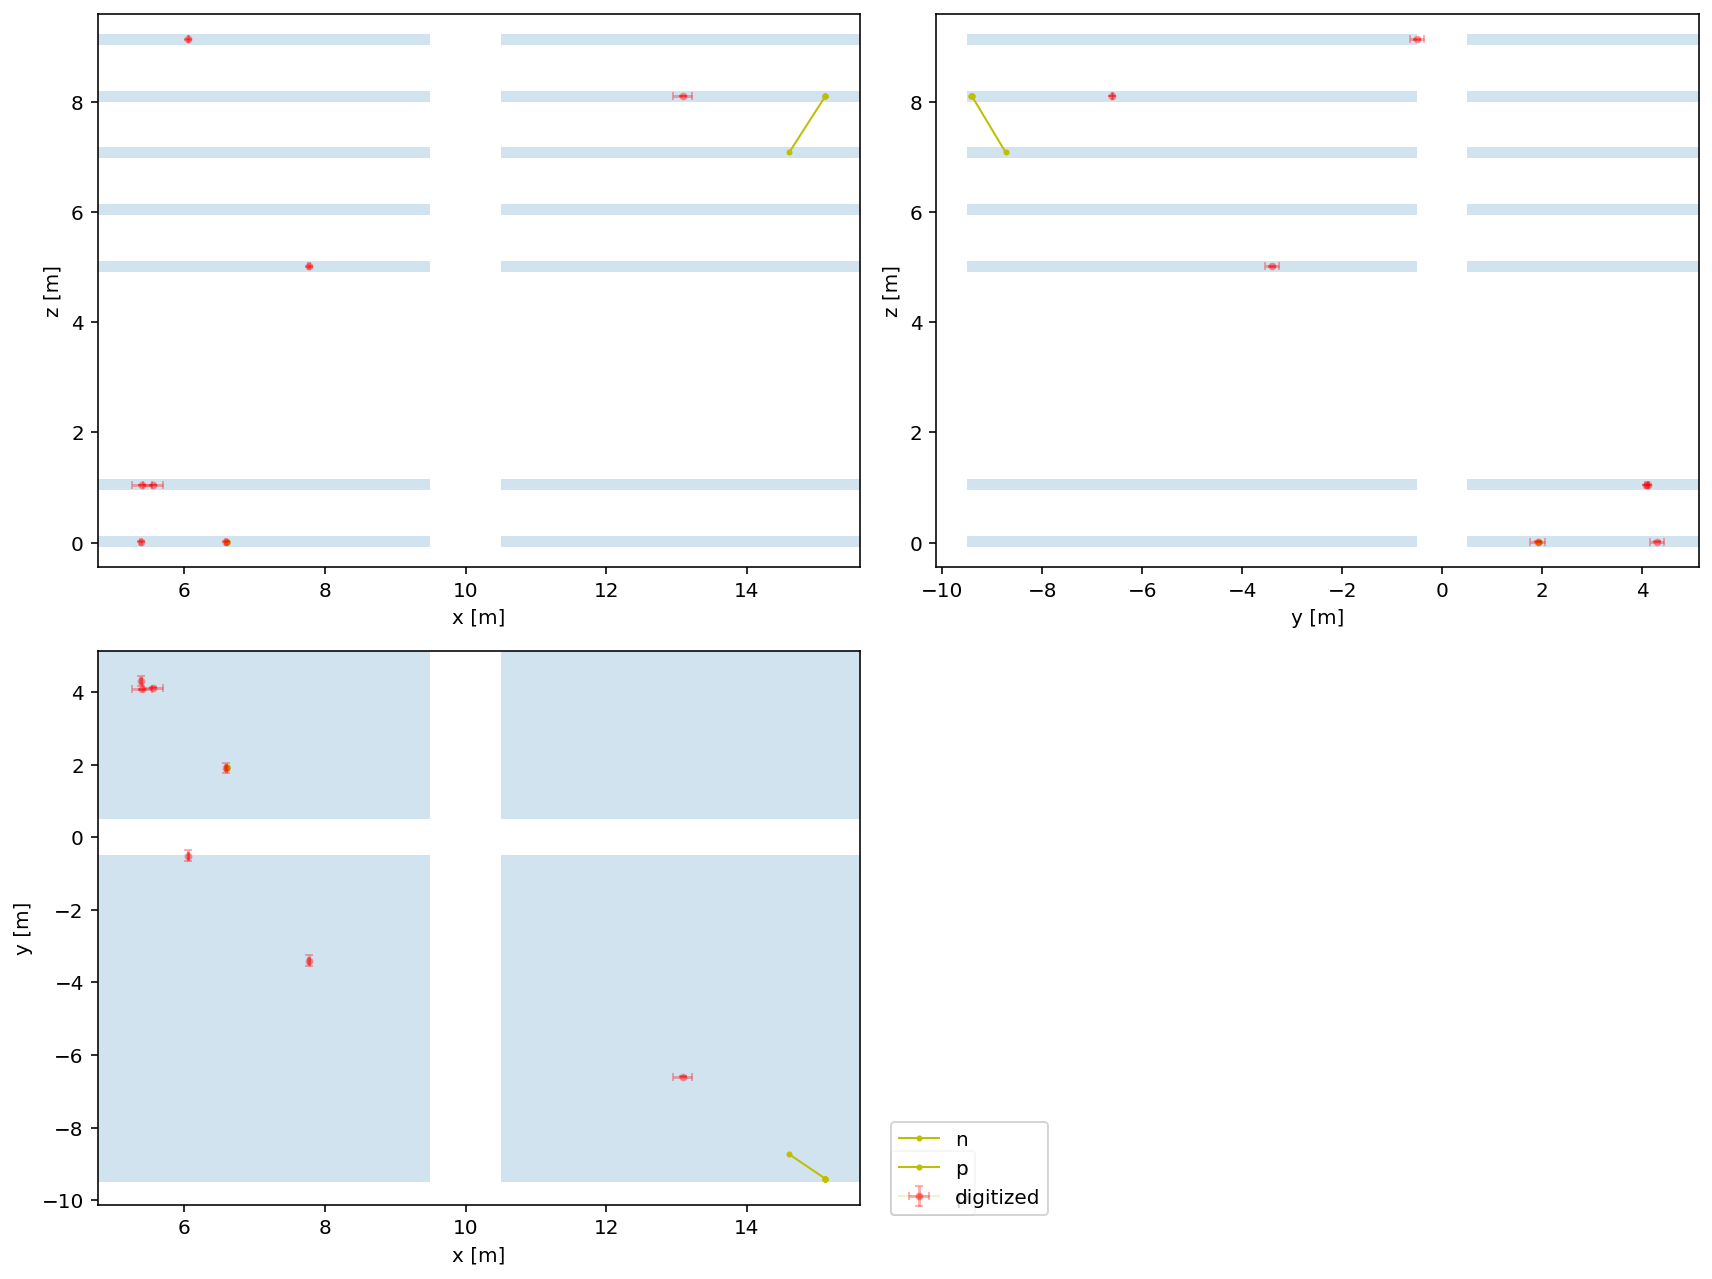

57


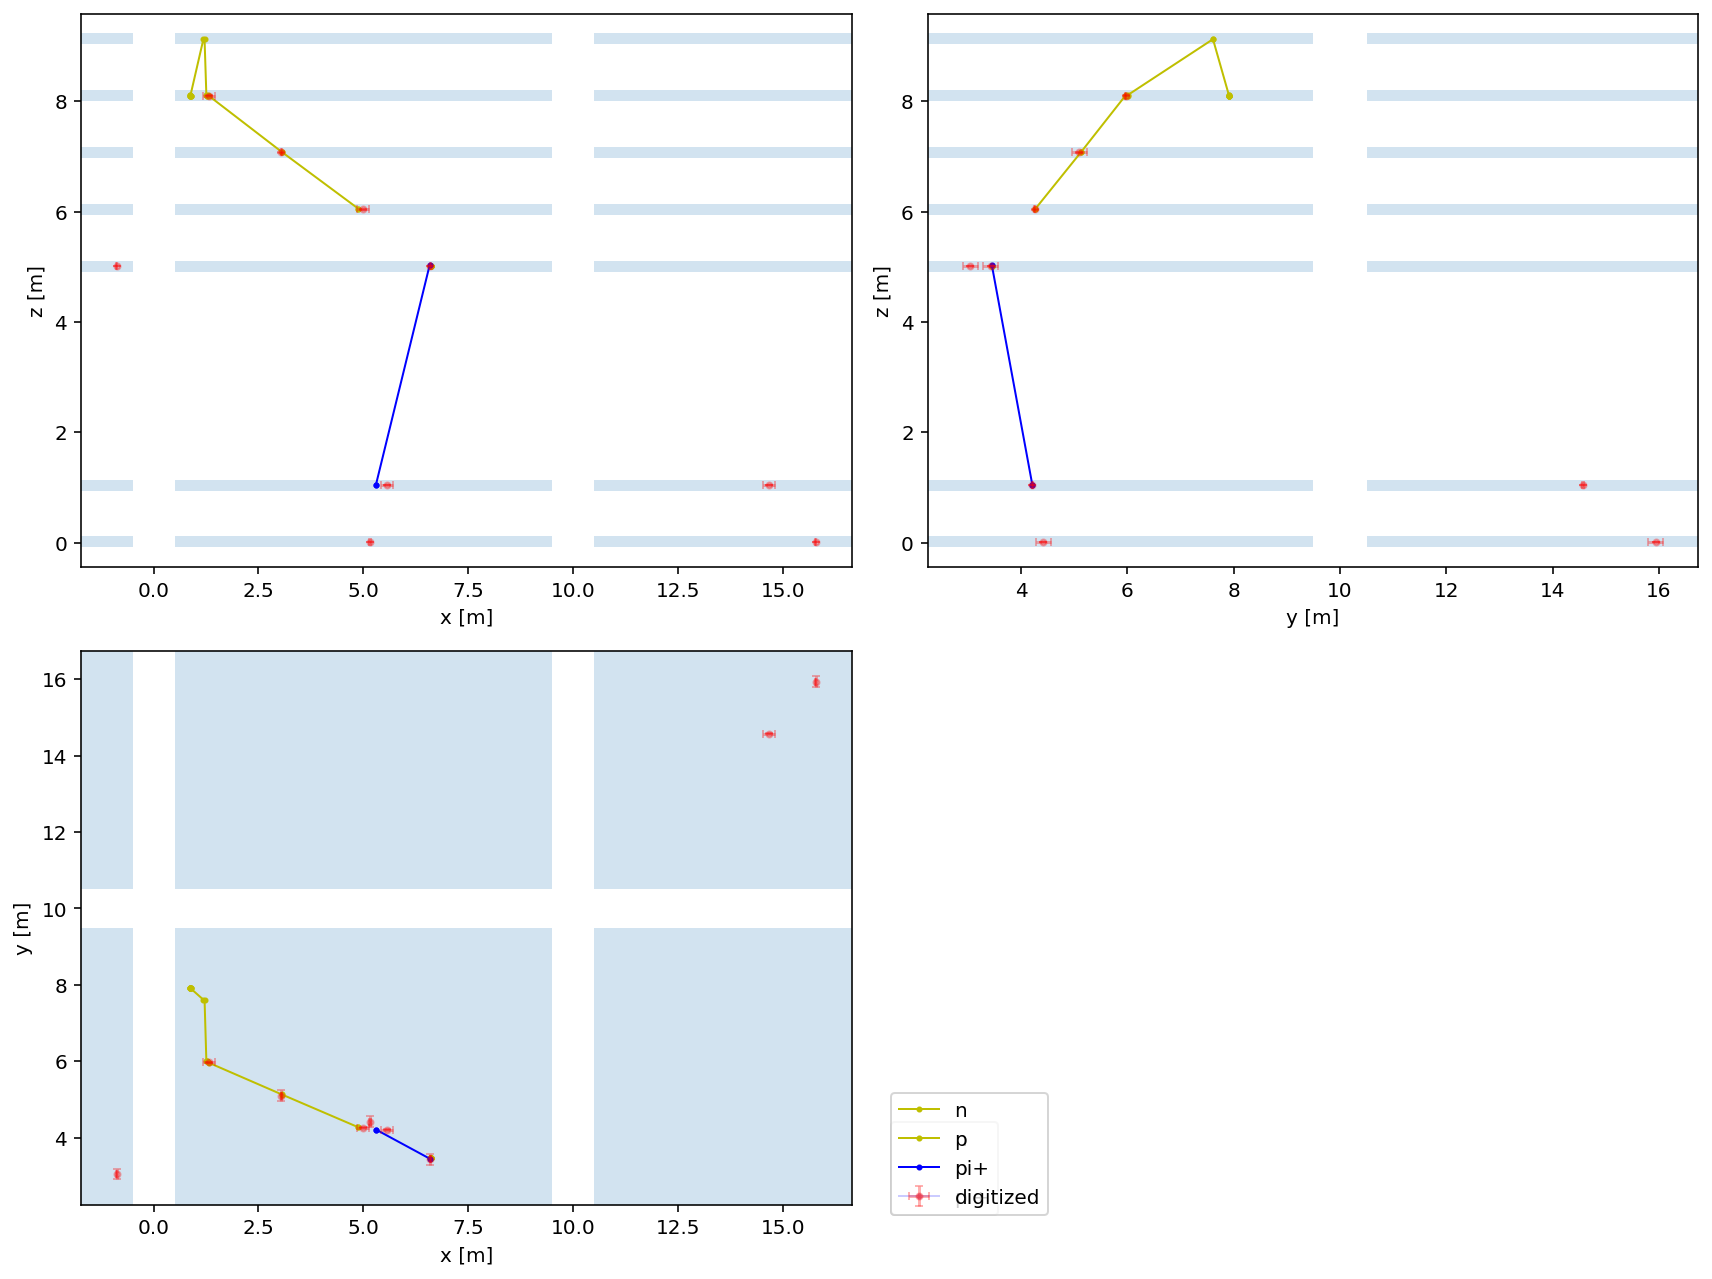

67


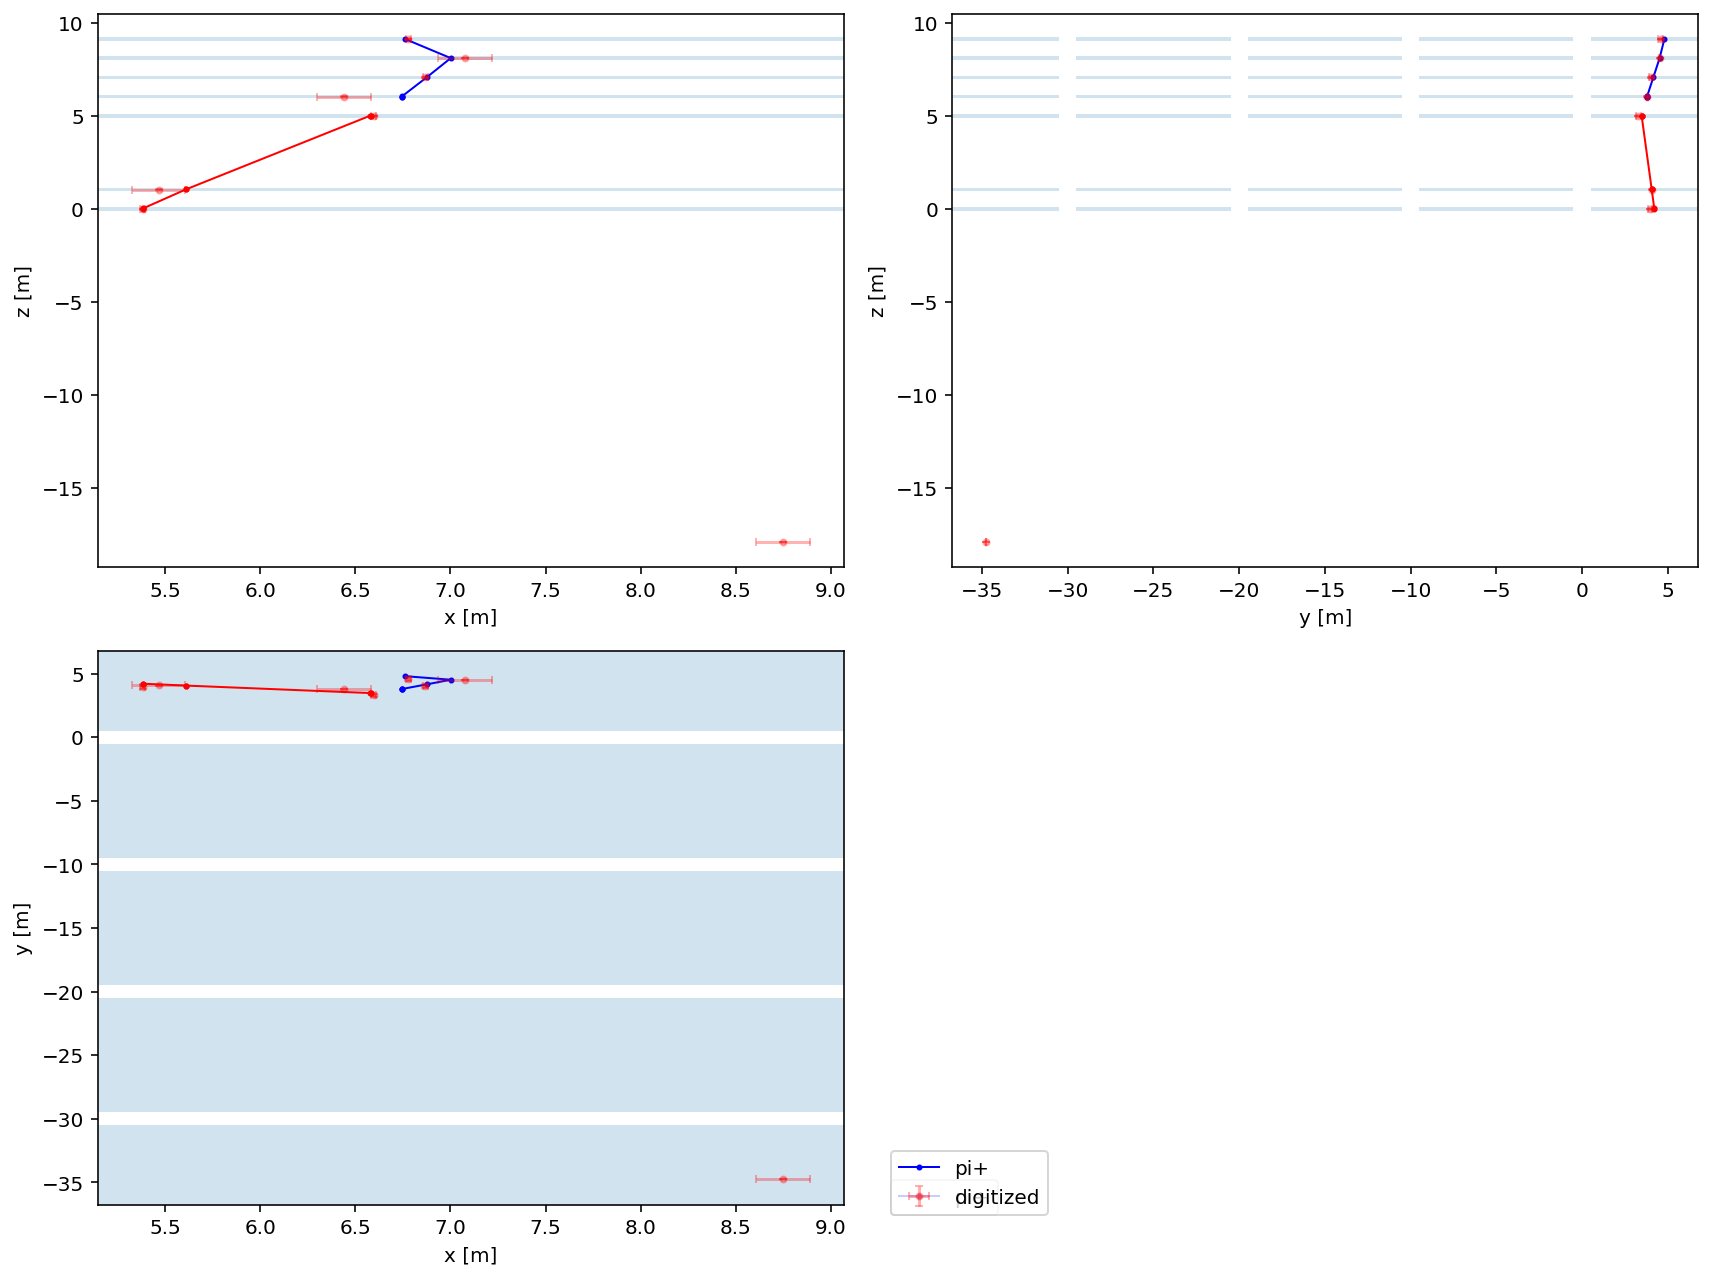

79


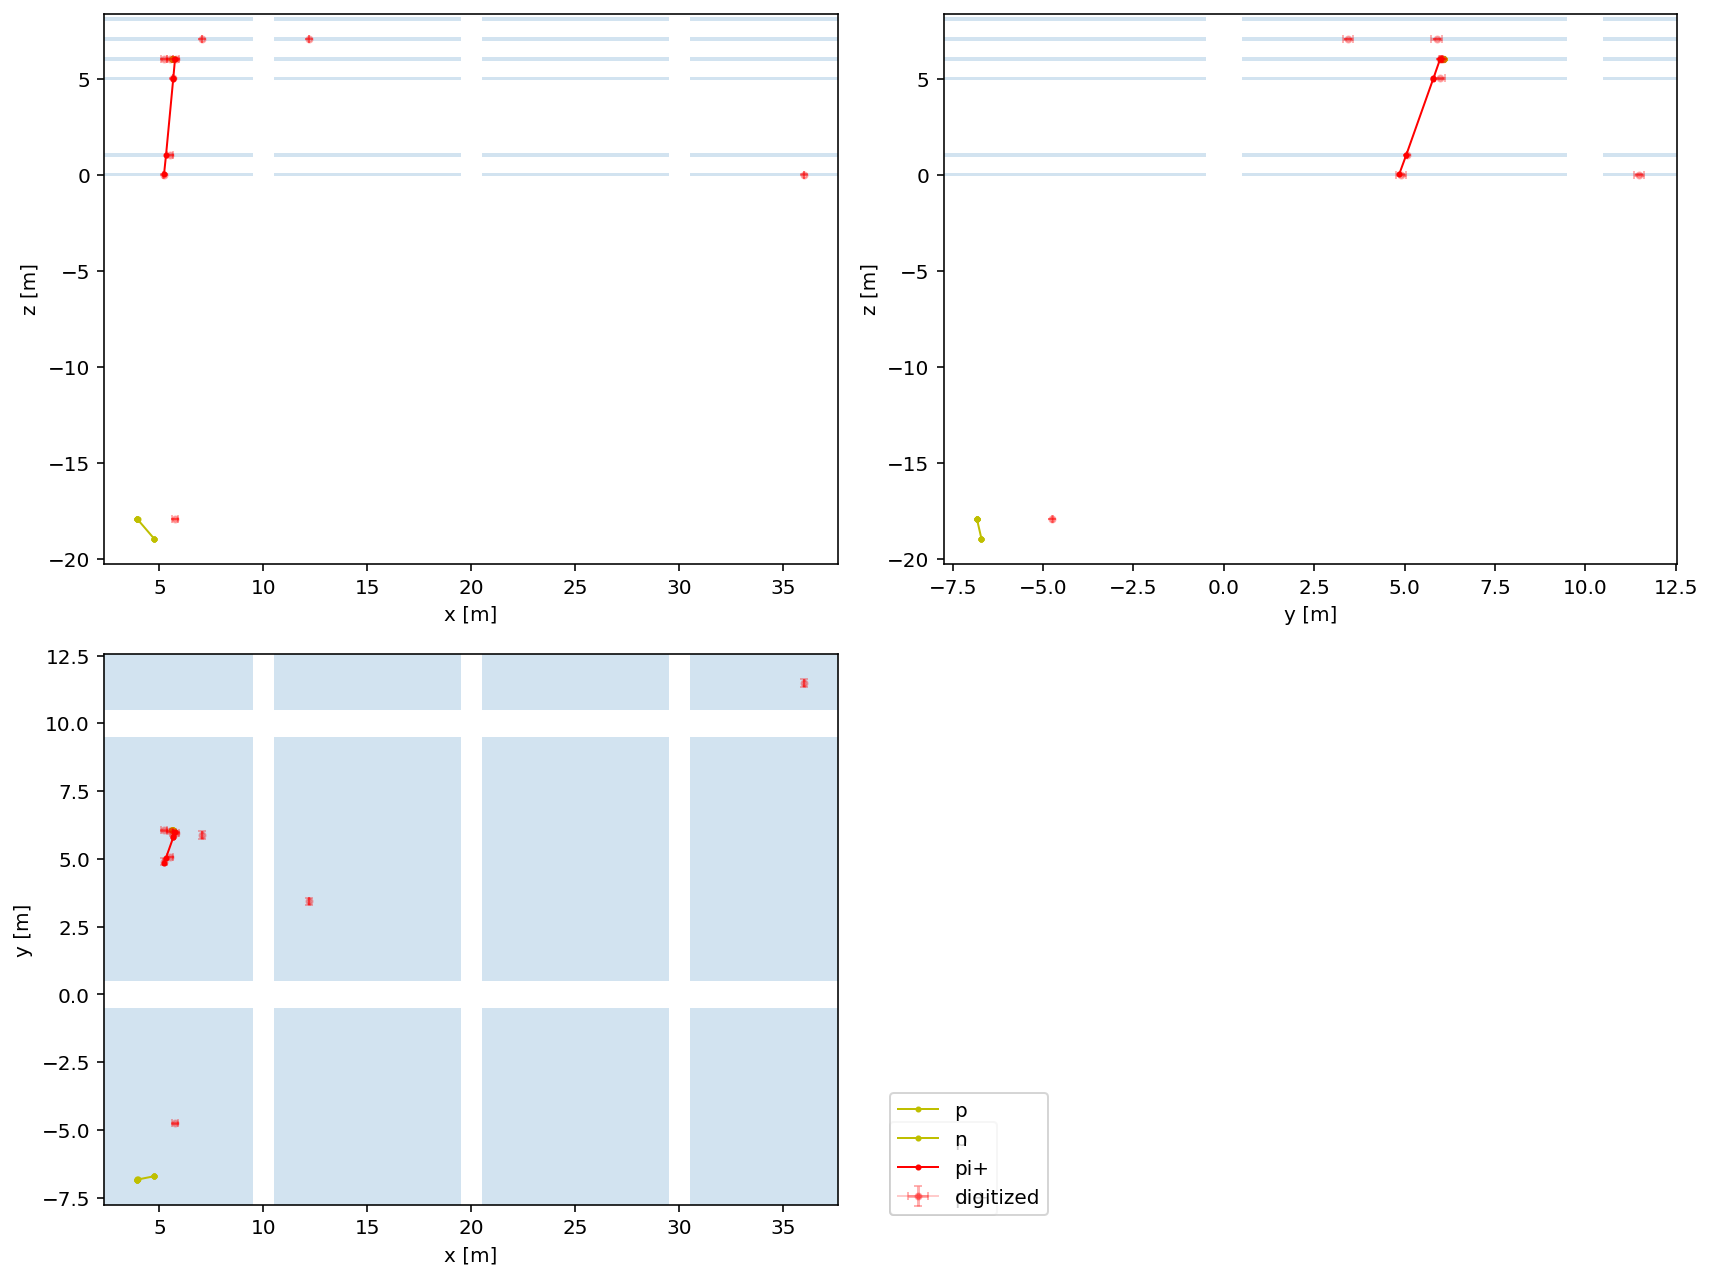

85


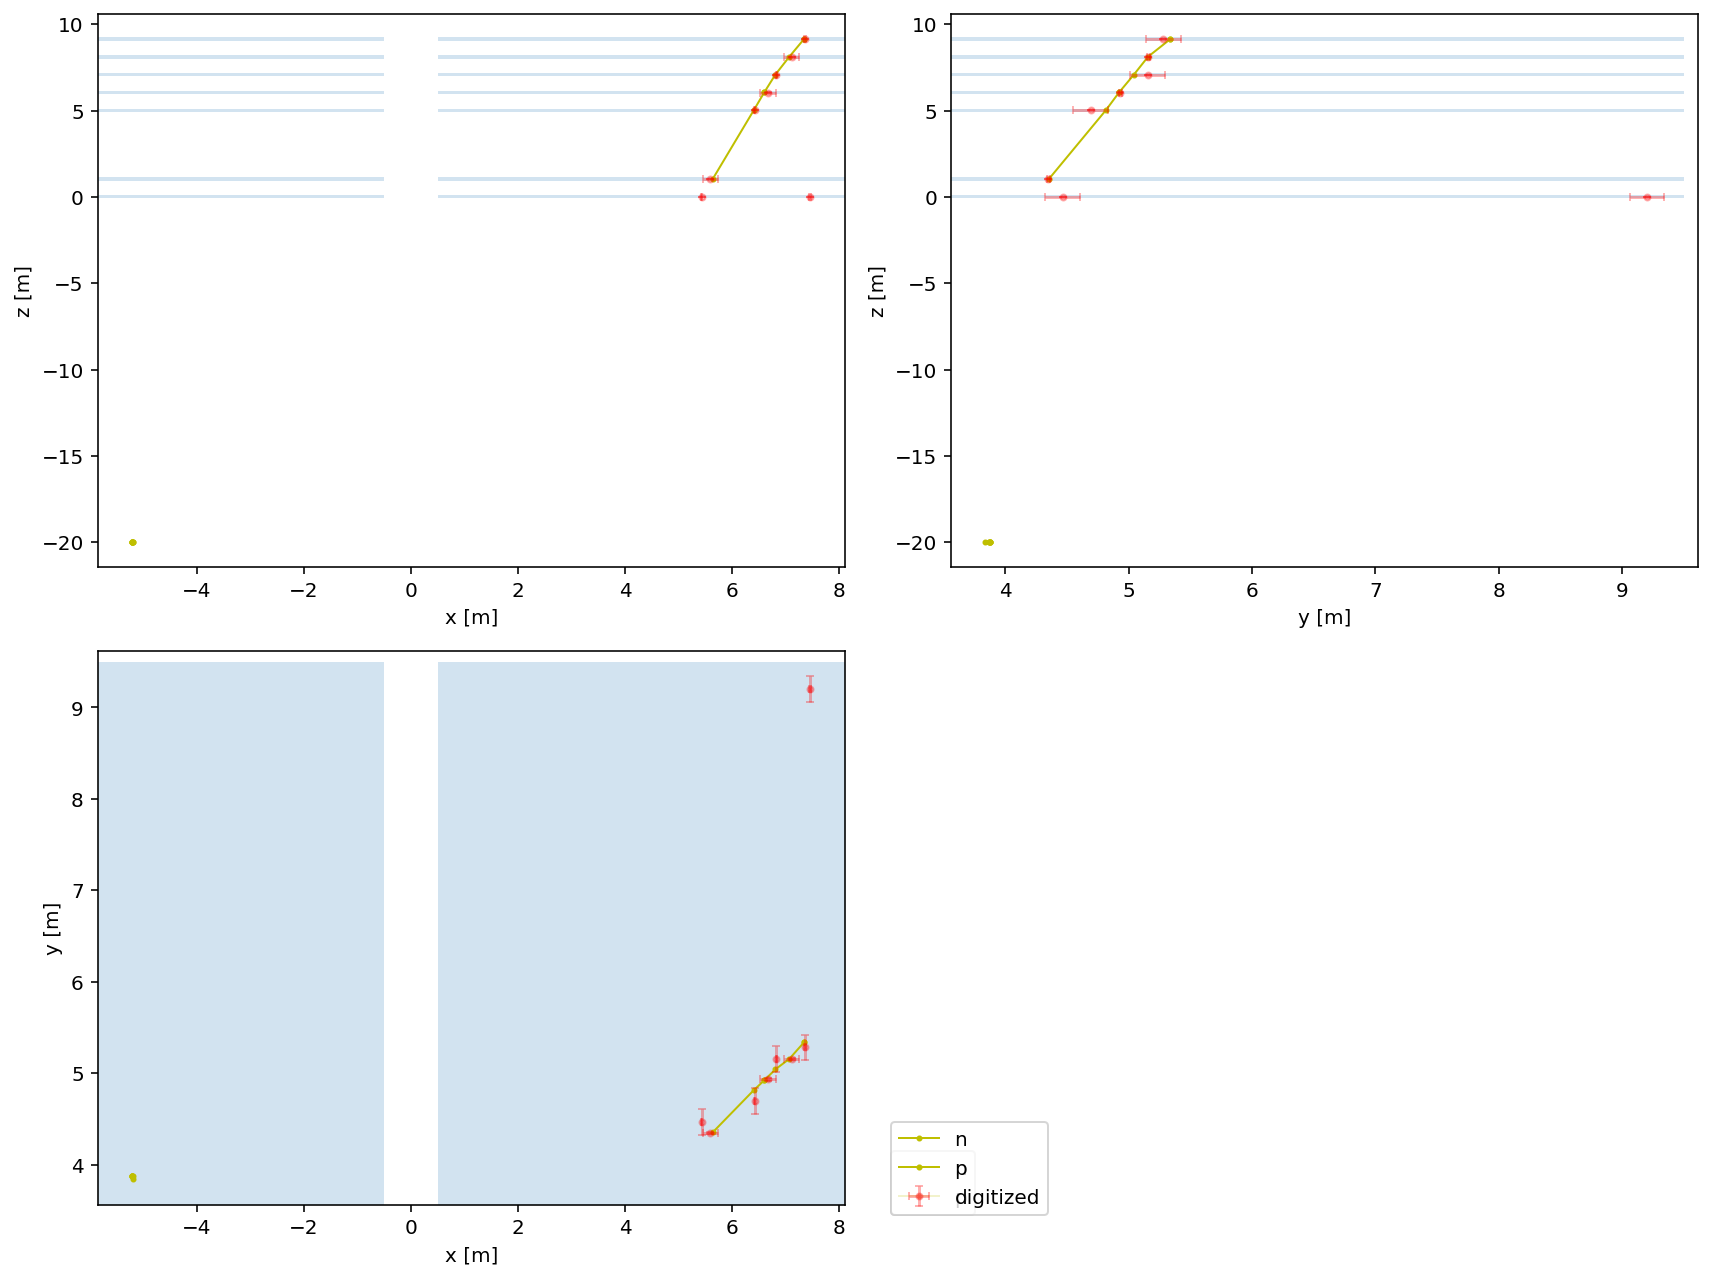

88


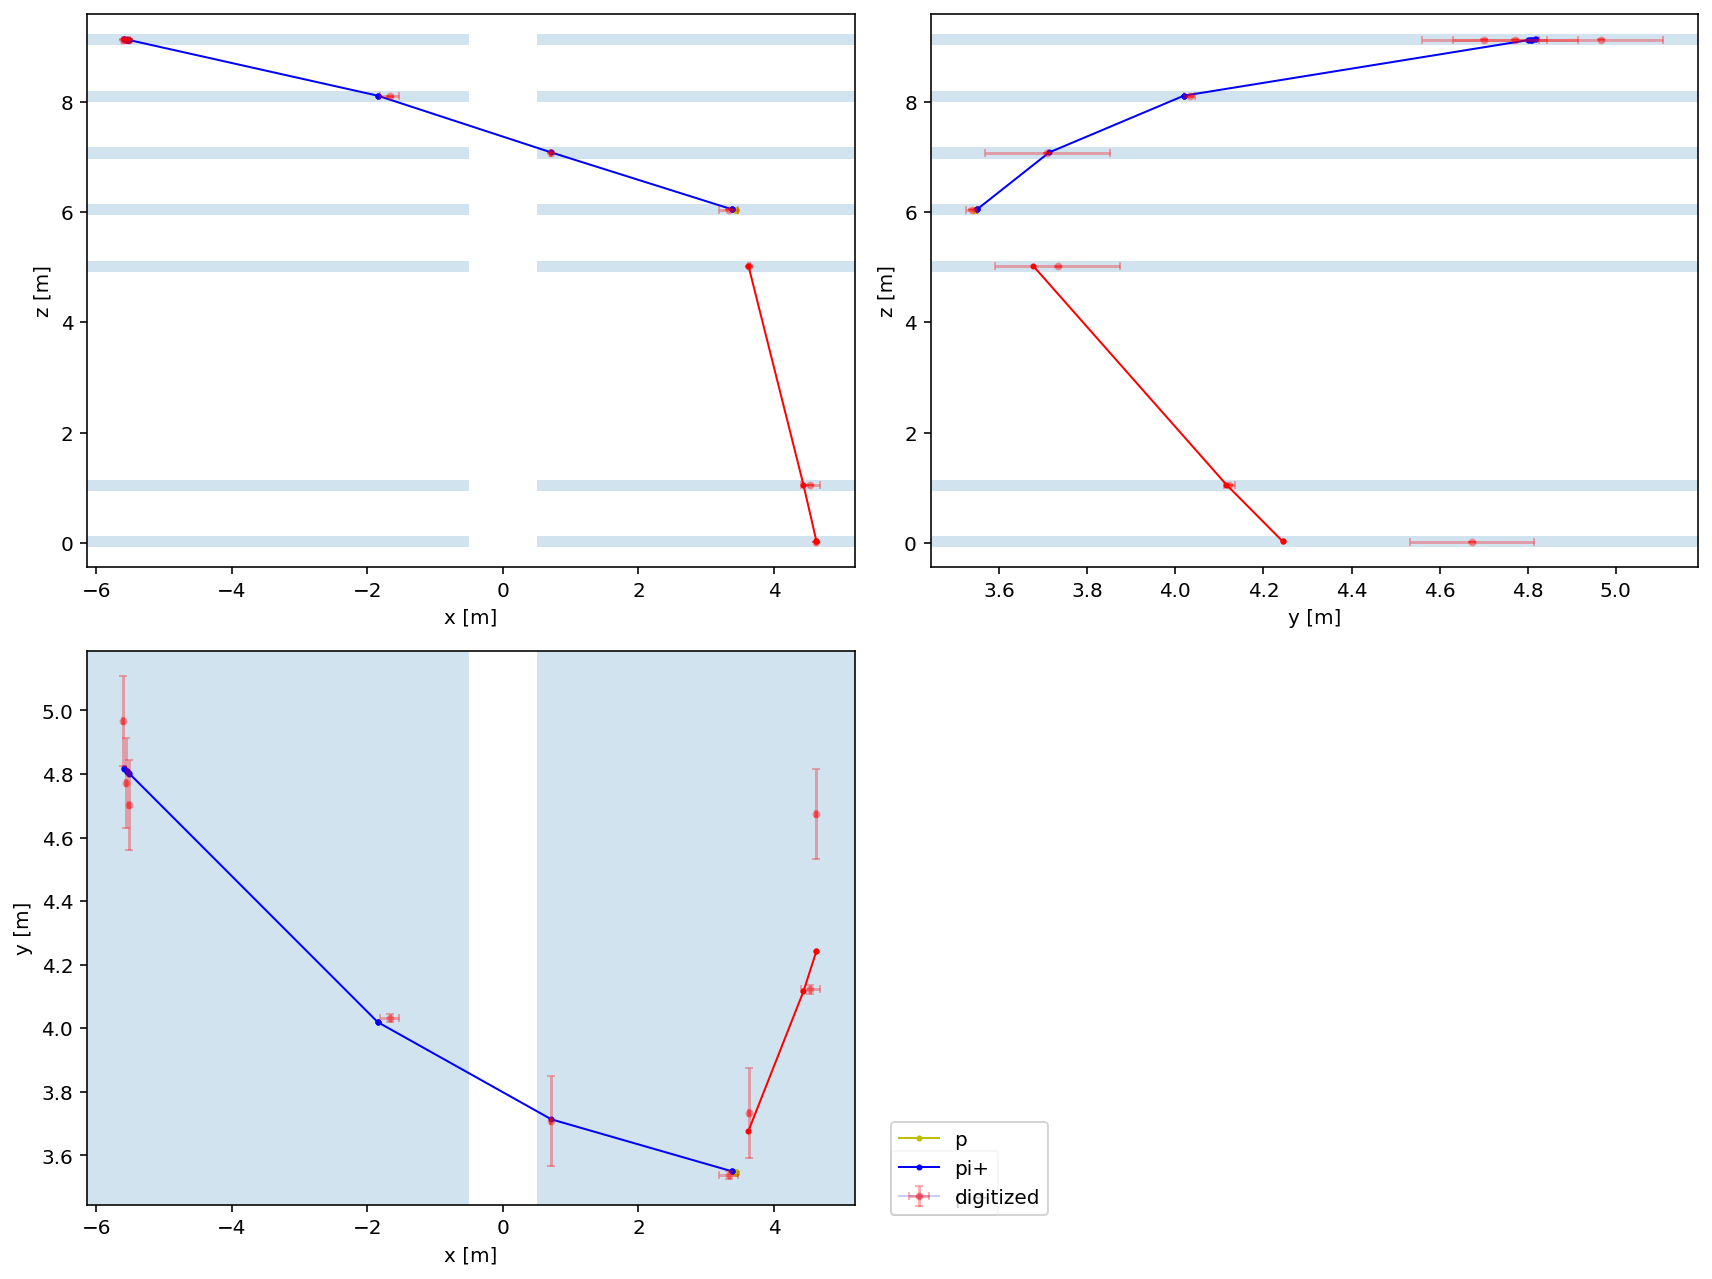

93


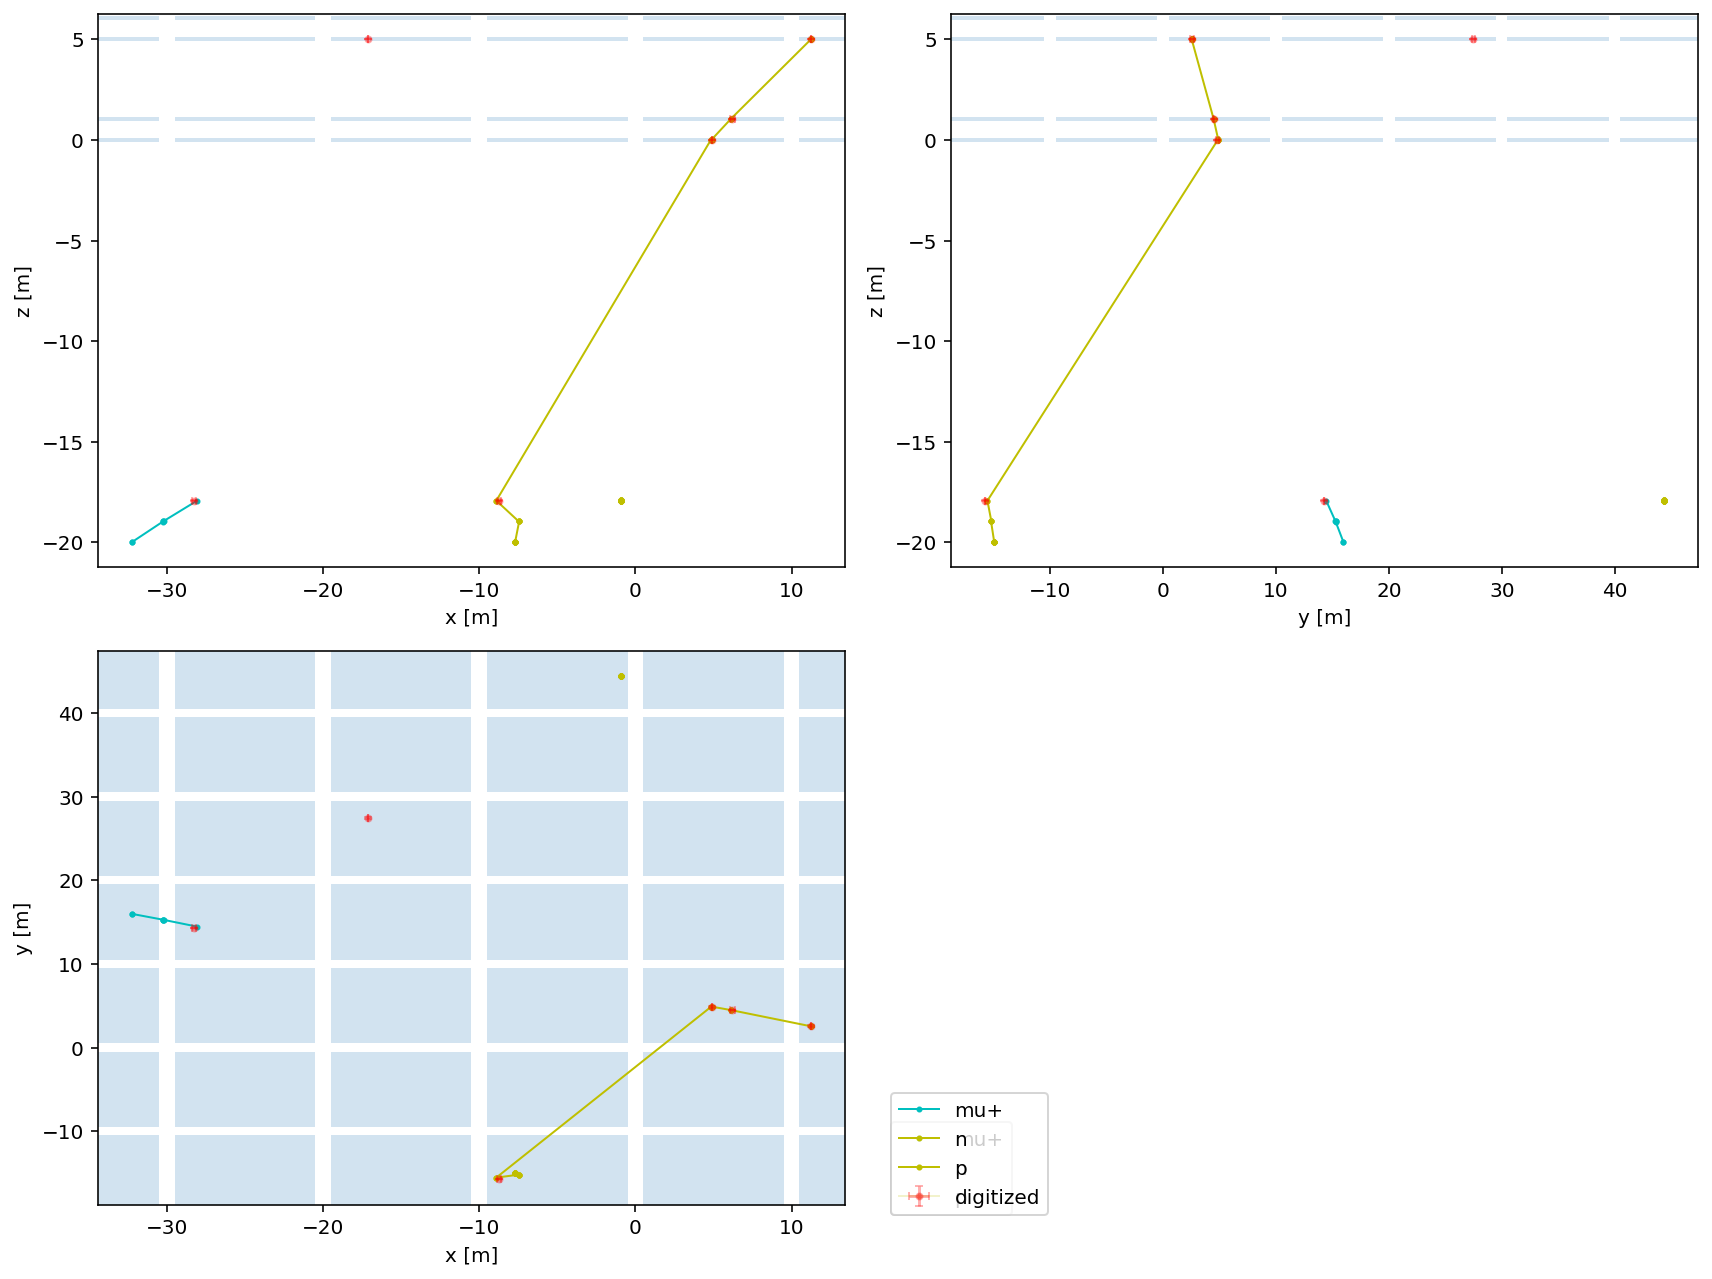

In [87]:
nplots=10
counter=0
for i in range(100):
    ev.EventNumber+=1
    ev.Tree.GetEntry(ev.EventNumber)
    # 
    # # Plot truth+digi
    # fig,axs=plt.subplots(2,2,figsize=(12,9))
    # fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
    # fig = vis.plot_digi(ev,fig=fig, disp_det_view=True);
    # plt.show()

    if len(ev.Tree.Track_k_m_y0)==0:
        print(i)
        # Plot truth+digi
        fig,axs=plt.subplots(2,2,figsize=(12,9))
        fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
#         fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True);
        fig = vis.plot_digi(ev,fig=fig, disp_det_view=True);
        plt.show()
        counter+=1
        
        if counter>nplots:
            break

---
### Backup, read one file

In [185]:
# 1. filename
pion_energy = 100 #GeV
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/pion_{pion_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)
filename = files[-1]
# filename='../../simdata/fit_study/run0.root'
# print(files)
print(filename,"\n")

# 2. Open one file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_100_GeV/20230129/191525/stat200.root 

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 

## Plot multiple truth tracks

(-1.0, 11.0)

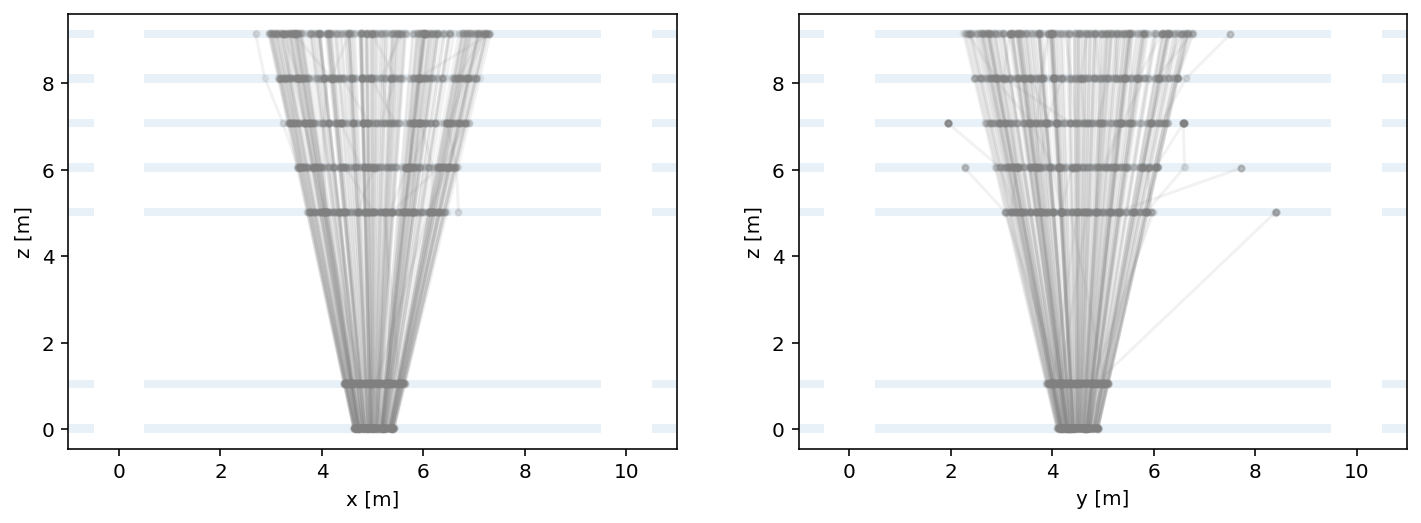

In [9]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]

for i in range(nevents):
# for i in [8,9]:
#     ev = event.Event(filename, i, tree_name=tree_name)
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            track=util.coord_cms2det(track)
            axs[0].plot(track[0],track[2],marker=".",color="grey",alpha=0.1)
            axs[1].plot(track[1],track[2],marker=".",color="grey",alpha=0.1)    
    
vis.drawdet_xz(axis=axs[0])
vis.drawdet_xz(axis=axs[1])

axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('z [m]')
axs[1].set_xlabel('y [m]')
axs[1].set_ylabel('z [m]')
axs[0].set_xlim(-1,11)
axs[1].set_xlim(-1,11)

## Plot one track with its Kalman filter reconstruction

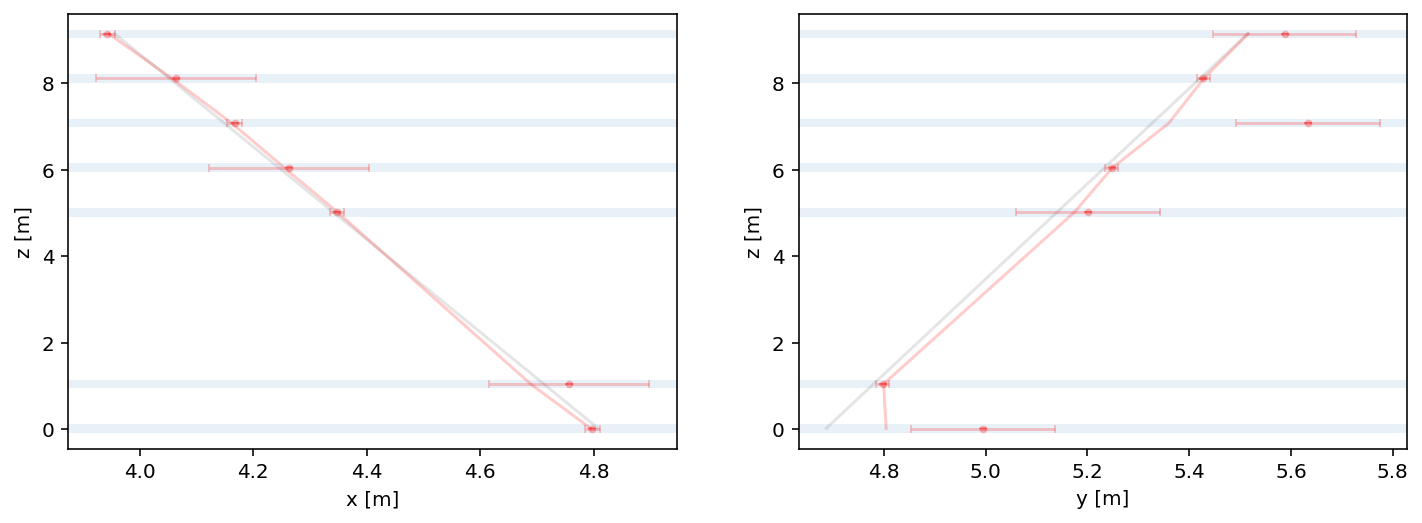

In [186]:
ev = event.Event(filename, 0, tree_name=tree_name)
ev.EventNumber=6
cut=cutflow.sample_space("")

# Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
truthtracks=ev.get_truthtrack()
event_vis = ev.get_recon_kalman()

# Plot x-z, y-z separately
fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]
for i_axis in [0,1]:
    # Plot truth tracks
    if len(truthtracks)>0:
        for track in truthtracks:
            track=util.coord_cms2det(track)
            axs[i_axis].plot(track[i_axis],track[2],color="grey",alpha=0.2)

    # Plot reconstructed tracks
    for i_track in range(len(event_vis["track_nonvertex"])):
        # Read the reconstructed track
        track=event_vis["track_nonvertex"][i_track]
        track=util.coord_cms2det(np.array(track))
        hits=[[],[],[]]
        hits_uncertainty=[[],[],[]]
        
        # Read hits of this track
        for i_hit in range(len(track[0])):
            hit=event_vis["hit_nonvertex"][i_track][i_hit]
            hit_layer = cut.in_layer(hit[1])
            hit_uncertainty = np.array(detector.Layer().uncertainty(hit_layer))
            hit=util.coord_cms2det(np.array(hit))
            hit_uncertainty=hit_uncertainty[[2,0,1]]
            for i in range(3):
                hits[i].append(hit[i])
                hits_uncertainty[i].append(hit_uncertainty[i])
        # Plot track and hits
        axs[i_axis].errorbar(hits[i_axis],hits[2],
                             xerr=hits_uncertainty[i_axis],yerr=hits_uncertainty[2],
                             color="red",capsize=2,ls='none',alpha=0.2, fmt=".")
        axs[i_axis].plot(track[i_axis],track[2],color="red",alpha=0.2)
        

    axs[i_axis].set_xlabel(xlabels[i_axis])
    axs[i_axis].set_ylabel('z [m]')
    vis.drawdet_xz(axis=axs[i_axis])


In [29]:
# 'Tree.GetEntry(1)
# print(Tree.Track_k_m_x0), print(Tree.Hit_x[0]),print(Tree.Track_k_m_y0), print(Tree.Hit_y[0]),Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0','

In [86]:
truth=[]
recon=[]
Entry=1

n_events=0
n_failed=0
# list_failed=[]

for i,filename in enumerate(tqdm(files)):
    tfile = root.TFile.Open(filename)
    tree_name = ["integral_tree","box_run"][0]
    Tree = tfile.Get(tree_name)
    
    for Entry in range(100):
        Tree.GetEntry(Entry)
        try:
            n_events+=1
            recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0]])
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0]])
        except:
            n_failed+=1
        #list_failed.append(i)

  0%|          | 0/200 [00:00<?, ?it/s]

In [87]:
n_failed/n_events

0.1803

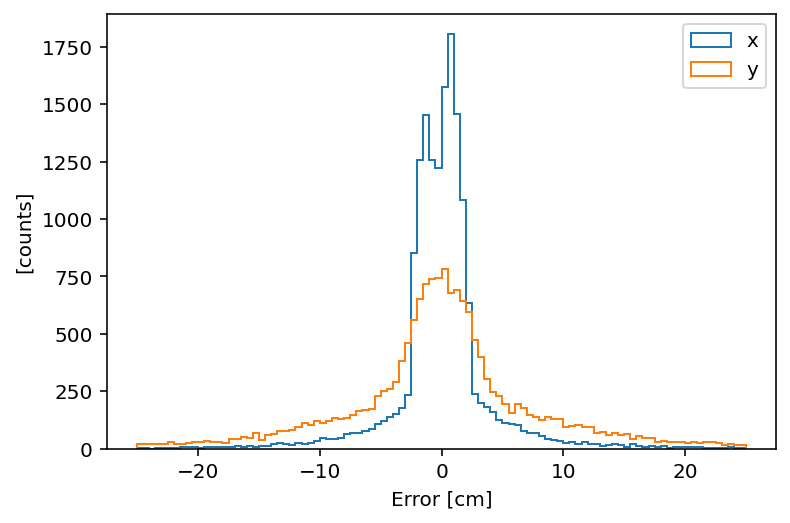

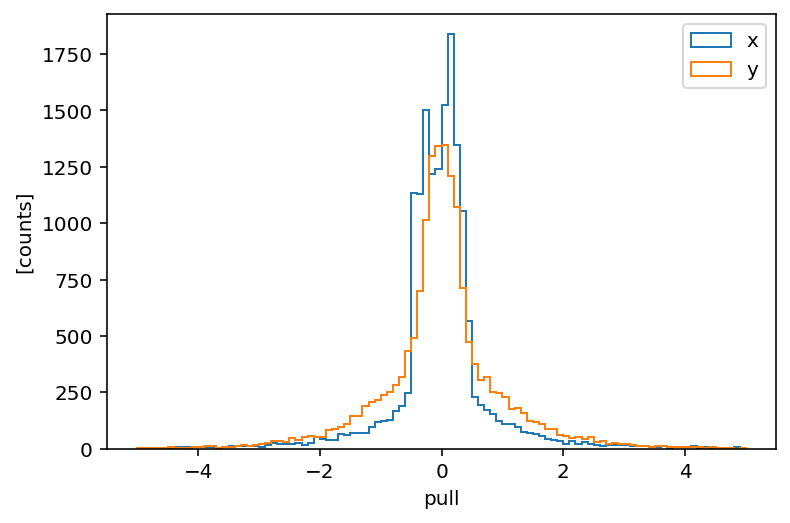

In [97]:
recon=np.array(recon)
truth=np.array(truth)
def pull(x):
    return (x-np.mean(x))/np.std(x)
plt.hist(recon[:,0]-truth[:,0],bins=100,range=(-25,25),histtype="step",label="x0");
plt.hist(recon[:,1]-truth[:,1],bins=100,range=(-25,25),histtype="step",label="y0");

plt.xlabel("Error [cm]")
plt.ylabel("[counts]")
plt.legend()
plt.show()

plt.hist(pull(recon[:,0]-truth[:,0]),bins=100,range=(-5,5),histtype="step",label="x0");
plt.hist(pull(recon[:,1]-truth[:,1]),bins=100,range=(-5,5),histtype="step",label="y0");

plt.xlabel("pull")
plt.ylabel("[counts]")
plt.legend()

In [ ]:
# /gen/pythia/process {process}

# /gen/pythia/cuts/clear
# /gen/pythia/cuts/add 13 | | 0.6:1.9 | -0.695:0.695 rad
# /gen/pythia/cuts/add 14 | | 0.6:1.9 | -0.695:0.695 rad